# Install / Import Libraries and Data

In [ ]:
!pip install tensorflow
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=5534f6f09e99912d5af69780e8df5b5538a6441532a95c82639a3a02724c1f5d
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [ ]:
#Author: Ferhat Dogan
#Import of the necessary packages
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import random as rd
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ConvLSTM2D
 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
 
from keras_self_attention import SeqSelfAttention
 
from statsmodels.tsa.arima_model import ARIMA
 
#visualization of NN
#from keras.utils.vis_utils import plot_model
#import graphviz
#from tensorflow.keras.layers.convolutional import Conv1D
#from tensorflow.keras.layers.convolutional import MaxPooling1D
 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
import csv#
import glob
import os
 
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


In [ ]:
Runway_ID = "BCN25R"
Runway = Runway_ID + "_Wxy_mm_norm_pp2"
number_features_predicted = 2
root_path = 'gdrive/My Drive/Data/' + Runway_ID + '/' 
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# !pip install PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# downloaded = drive.CreateFile({'id':"1A2vRBbAYWCOzgdLZ2wW4EplsFJZ6NaK4"})   # replace the id with id of file you want to access
# downloaded.GetContentFile('df_BCN25R_Transformed.csv') 

In [ ]:
df = pd.read_csv(root_path + Runway_ID + '_Transformed.csv')
df=df.drop(columns=['Unnamed: 0'])
df = df.reset_index()
df=df.drop(columns=['index'])

In [ ]:
# alle zeilen für <3k feet aus df nehmen
df = df.loc[(df['Radio Altitude (1, left, Capt or Only) (ft)'] < 3000)&(df['Original IDs'] > 3000)]
df = df.reset_index()
df=df.drop(columns=['index'])
df['Airport (Destination)'].value_counts()

LEBL    9978
Name: Airport (Destination), dtype: int64

# Exploratory Data Analysis

In [ ]:
df.head()

Original IDs  ... Speed of Sound (knots)
0          6348  ...             660.698907
1          6352  ...             660.775056
2          6356  ...             660.886520
3          6360  ...             660.983408
4          6364  ...             661.220802

[5 rows x 26 columns]

In [ ]:
df.describe().transpose()

count  ...          max
Original IDs                                        9978.0  ...  9772.000000
Landing Runway ID (numerical) (numerical part o...  9978.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         9978.0  ...  2996.000000
Height Above Touchdown (HAT) (ft)                   9978.0  ...  2991.430030
Pressure Altitude (ft)                              9978.0  ...  3316.000000
Wind Direction (true) (deg)                         9978.0  ...   359.296875
Wind Speed (knots)                                  9978.0  ...    50.000000
Air Temperature (outside) (deg C)                   9978.0  ...    23.002593
Best Available Latitude (deg)                       9978.0  ...    41.469695
Best Available Longitude (deg)                      9978.0  ...     2.587770
Track Angle (true; inertial or only) (deg)          9978.0  ...   357.275299
True Heading (deg)                                  9978.0  ...   359.912018
Ground Speed (kt)                                   9978.0  ...   277.000000
Airspeed (true) (knots)                             9978.0  ...   282.921075
Airspeed (calibrated; 1 or Only) (knots)            9978.0  ...   273.500000
Mach Number                                         9978.0  ...     0.432078
Air Density (ambient) (slugs/ft³)                   9978.0  ...     0.002516
Air Density (total) (slugs/ft³)                     9978.0  ...     0.002570
Air Pressure (ambient) (lbs/ft²)                    9978.0  ...  2158.755790
Air Pressure (dynamic) (lbs/ft²)                    9978.0  ...   252.328341
Air Pressure (total) (lbs/ft²)                      9978.0  ...  2224.155757
ISA Temperature (deg C)                             9978.0  ...    15.102741
Deviation from ISA Temperature (deg C)              9978.0  ...     9.647910
Speed of Sound (knots)                              9978.0  ...   670.311441

[24 rows x 8 columns]

## Correlations of Wind Speed and Wind Direction

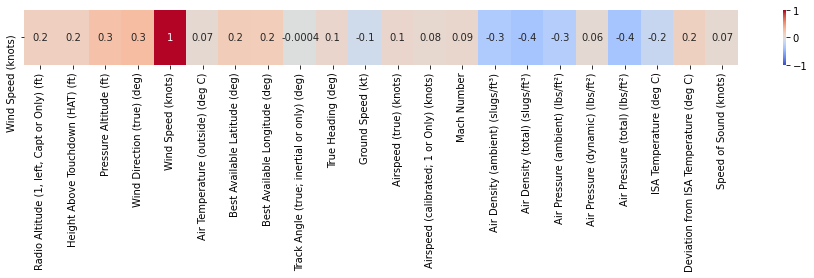

In [ ]:
fig, ax = plt.subplots(figsize=(16,1))    
sns.heatmap(df.drop(columns=['Original IDs', 'Air/Ground Switch (Main) (0=AIR)', 'Landing Runway ID (numerical) (numerical part of runway designation)']).corr().loc[['Wind Speed (knots)'],:] ,annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

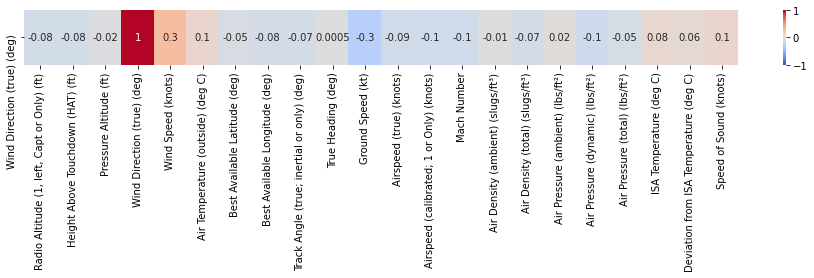

In [ ]:
fig, ax = plt.subplots(figsize=(16,1))    
sns.heatmap(df.drop(columns=['Original IDs', 'Air/Ground Switch (Main) (0=AIR)', 'Landing Runway ID (numerical) (numerical part of runway designation)']).corr().loc[['Wind Direction (true) (deg)'],:] ,annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

## Distribution of all Features

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

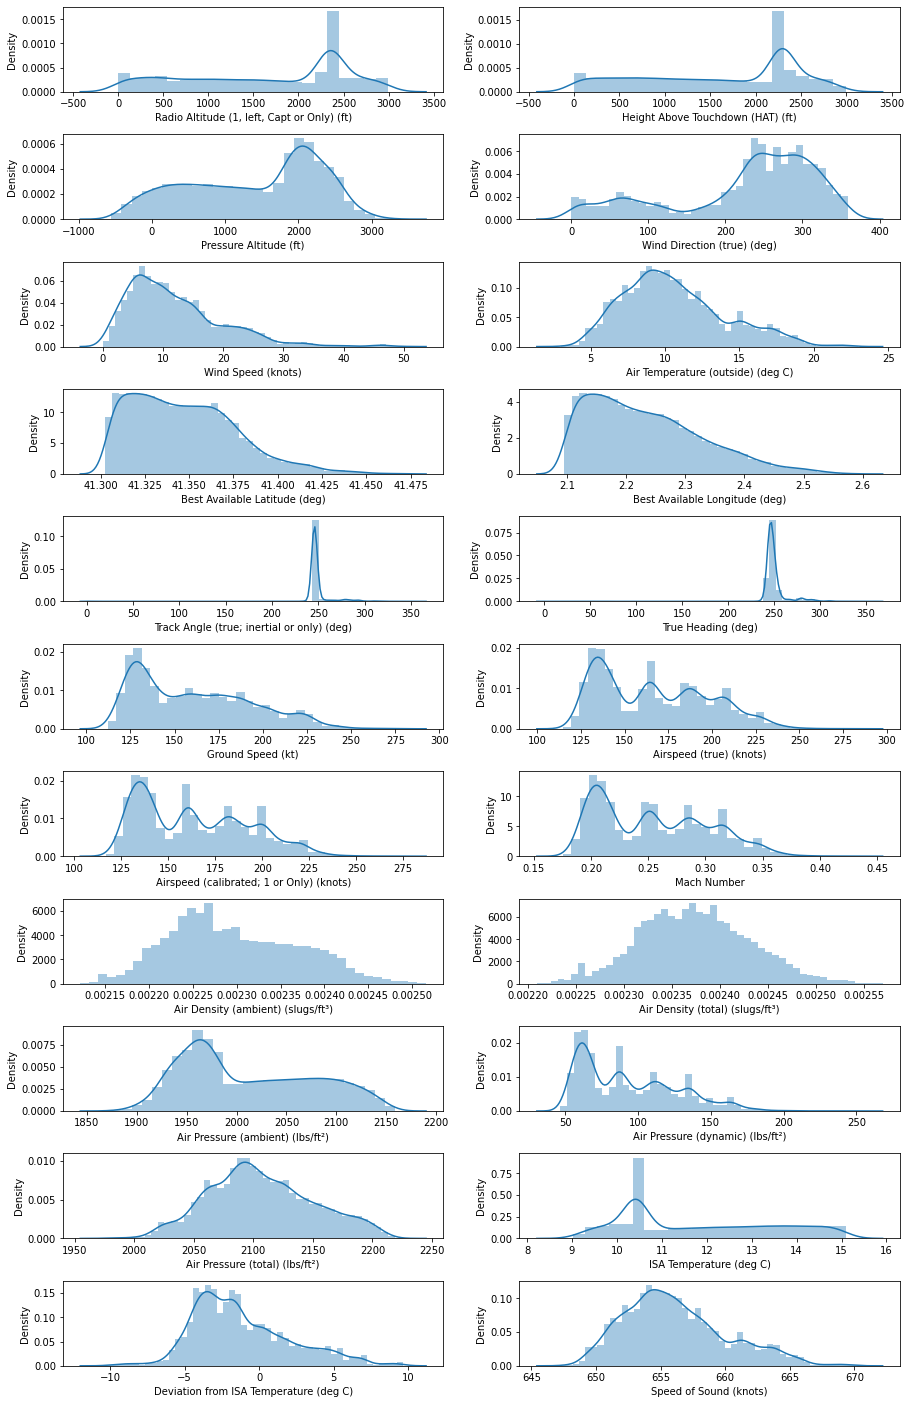

In [ ]:
f, axes = plt.subplots(11, 2, figsize=(15,25))
f.subplots_adjust(hspace=.5)
sns.distplot(df['Radio Altitude (1, left, Capt or Only) (ft)'], ax=axes[0, 0])
#axes[0,0].set_title('Radio Altitude')

sns.distplot(df['Height Above Touchdown (HAT) (ft)'], ax=axes[0, 1])
#axes[0,1].set_title('Height Above Touchdown (ft)')

sns.distplot(df['Pressure Altitude (ft)'], ax=axes[1,0])
#axes[1,0].set_title('Pressure Altitude (ft)')

sns.distplot(df['Wind Direction (true) (deg)'], ax=axes[1,1])
#axes[1,1].set_title('Wind Direction (true) (deg)')

sns.distplot(df['Wind Speed (knots)'], ax=axes[2,0])
#axes[2,0].set_title('Wind Speed (knots)')

sns.distplot(df['Air Temperature (outside) (deg C)'], ax=axes[2,1])
#axes[2,1].set_title('Air Temperature (outside) (deg C)')

sns.distplot(df['Best Available Latitude (deg)'], ax=axes[3,0],)
#axes[3,0].set_title('Best Available Latitude (deg)')

sns.distplot(df['Best Available Longitude (deg)'], ax=axes[3,1])
#axes[3,1].set_title('Best Available Longitude (deg)')

sns.distplot(df['Track Angle (true; inertial or only) (deg)'], ax=axes[4,0])
#axes[4,0].set_title('Track Angle (deg)')

sns.distplot(df['True Heading (deg)'], ax=axes[4,1])
#axes[4,1].set_title('True Heading (deg)')

sns.distplot(df['Ground Speed (kt)'], ax=axes[5,0])
#axes[5,0].set_title('Ground Speed (kt)')

sns.distplot(df['Airspeed (true) (knots)'], ax=axes[5,1])
#axes[5,1].set_title('Airspeed (true) (knots)')

sns.distplot(df['Airspeed (calibrated; 1 or Only) (knots)'], ax=axes[6,0])
#axes[6,0].set_title('Airspeed (calibrated) (knots)')

sns.distplot(df['Mach Number'], ax=axes[6,1])
#axes[6,1].set_title('Mach Number')

sns.distplot(df['Air Density (ambient) (slugs/ft³)'], ax=axes[7,0])
#axes[7,0].set_title('Air Density (ambient) (slugs/ft³)')

sns.distplot(df['Air Density (total) (slugs/ft³)'], ax=axes[7,1])
#axes[7,1].set_title('Air Density (total) (slugs/ft³)')

sns.distplot(df['Air Pressure (ambient) (lbs/ft²)'], ax=axes[8,0])
#axes[8,0].set_title('Air Pressure (ambient) (lbs/ft²)')

sns.distplot(df['Air Pressure (dynamic) (lbs/ft²)'], ax=axes[8,1])
#axes[8,1].set_title('Air Pressure (dynamic) (lbs/ft²)')

sns.distplot(df['Air Pressure (total) (lbs/ft²)'], ax=axes[9,0])
#axes[9,0].set_title('Air Pressure (total) (lbs/ft²)')

sns.distplot(df['ISA Temperature (deg C)'], ax=axes[9,1])
#axes[9,1].set_title('ISA Temperature (deg C)')

sns.distplot(df['Deviation from ISA Temperature (deg C)'], ax=axes[10,0])
#axes[10,0].set_title('Deviation from ISA Temperature (deg C)')

sns.distplot(df['Speed of Sound (knots)'], ax=axes[10,1])
#axes[10,1].set_title('Speed of Sound (knots)')

## Radio Altitude vs Wind

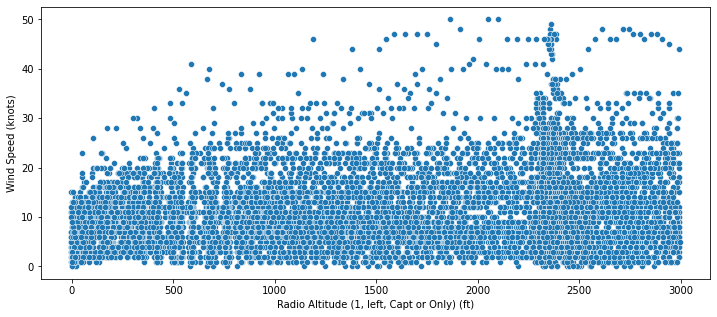

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 5)
sns.scatterplot(x="Radio Altitude (1, left, Capt or Only) (ft)", y="Wind Speed (knots)", data=df)

225.99774973692124

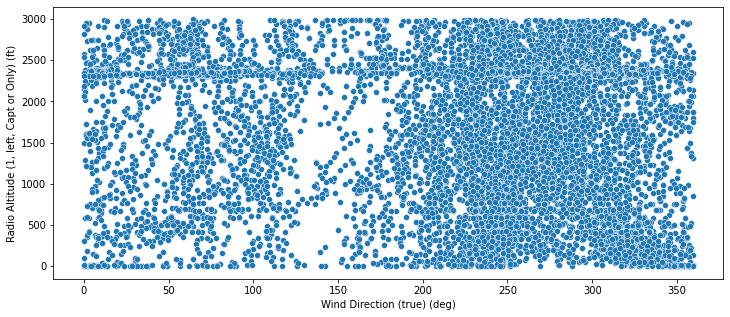

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 5)
sns.scatterplot(x="Wind Direction (true) (deg)", y="Radio Altitude (1, left, Capt or Only) (ft)", data=df)
# Mean Wind Direction <3k ft
df["Wind Direction (true) (deg)"].mean()

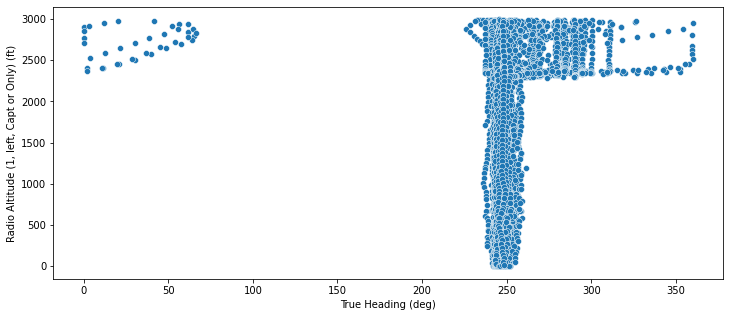

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 5)
sns.scatterplot(x="True Heading (deg)", y="Radio Altitude (1, left, Capt or Only) (ft)", data=df)

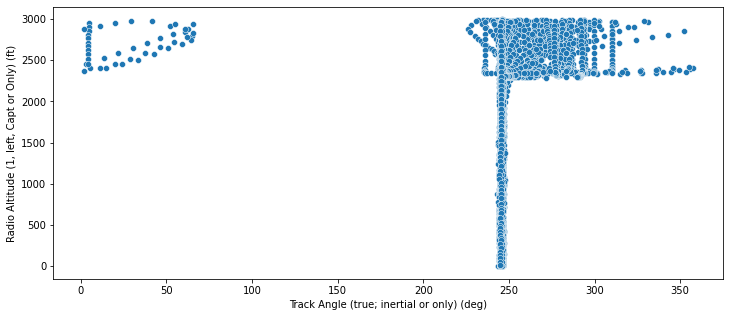

In [ ]:
 fig = plt.gcf()
fig.set_size_inches(12, 5)
sns.scatterplot(x="Track Angle (true; inertial or only) (deg)", y="Radio Altitude (1, left, Capt or Only) (ft)", data=df)

## Trajectories

# Feature Engineering, Split and Normalization

## Feature Engineering

### Wind

The wind direction is given in units of degrees. As Angles are widely spreaded values of 0 to 360, this is not good for training. Furthermore, the wind direction is not really important, if the wind is not blowing.

To make this relation easier for the model to interpret, the wind speed and wind diretion are converted into a wind vector.

In doing so, the wind direction values is converted to the corresponding radians. Then, the wind components x and y are calculated using the wind direction radians and the wind speed.

In [ ]:
ws = df.pop('Wind Speed (knots)')
#max_ws = df.pop('max. ws (kt/s)')

wd_rad = df.pop('Wind Direction (true) (deg)')*np.pi / 180

df['Wx'] = ws*np.cos(wd_rad)
df['Wy'] = ws*np.sin(wd_rad)

In [ ]:
df[['Wx', 'Wy']].head()

Wx        Wy
0 -10.896921 -7.089225
1 -11.388911 -6.268389
2  -9.638490 -7.148392
3  -8.588110 -6.873454
4 -10.583055 -5.656761

(-26.477005110654595,
 30.33978396843094,
 -45.95569258450289,
 29.411643254081845)

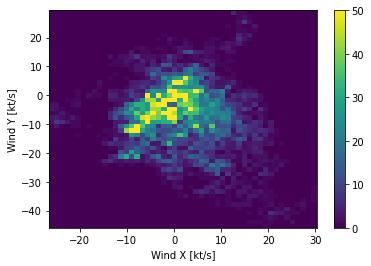

In [ ]:
# Distribution of Wind Vectors
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=50)
plt.colorbar()
plt.xlabel('Wind X [kt/s]')
plt.ylabel('Wind Y [kt/s]')
ax = plt.gca()
ax.axis('tight')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


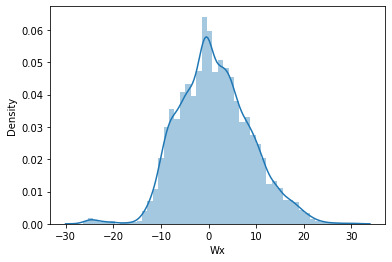

In [ ]:
ax = sns.distplot(df['Wx']) # Standardize due to Gaussian Distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


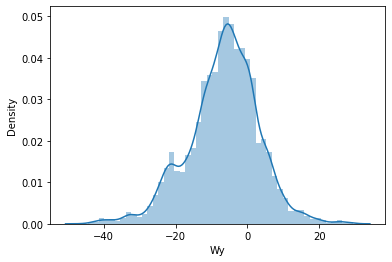

In [ ]:
ax = sns.distplot(df['Wy']) # Standardize due to Gaussian Distribution

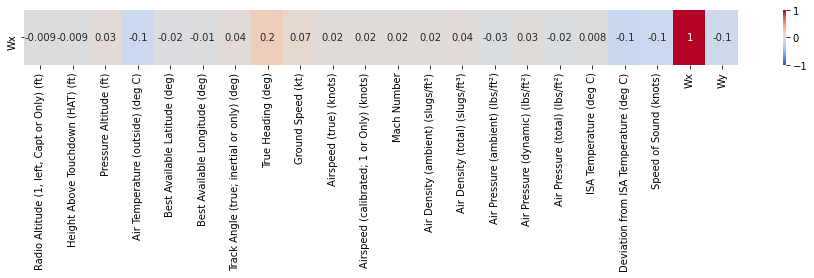

In [ ]:
fig, ax = plt.subplots(figsize=(16,1))    
sns.heatmap(df.drop(columns=['Original IDs', 'Air/Ground Switch (Main) (0=AIR)', 'Landing Runway ID (numerical) (numerical part of runway designation)']).corr().loc[['Wx'],:] ,annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

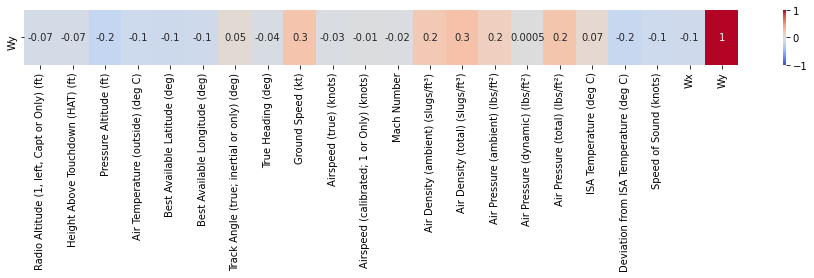

In [ ]:
fig, ax = plt.subplots(figsize=(16,1))    
sns.heatmap(df.drop(columns=['Original IDs', 'Air/Ground Switch (Main) (0=AIR)', 'Landing Runway ID (numerical) (numerical part of runway designation)']).corr().loc[['Wy'],:] ,annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Track Angle / True Heading

In [ ]:
#max_ws = df.pop('max. ws (kt/s)')

ta_rad = df.pop('Track Angle (true; inertial or only) (deg)')*np.pi / 180
th_rad = df.pop('True Heading (deg)')*np.pi / 180

In [ ]:
df['ta_rad'] = ta_rad
df['th_rad'] = th_rad

In [ ]:
df[['ta_rad', 'th_rad']].head()

ta_rad    th_rad
0  5.783106  5.689533
1  5.634310  5.539203
2  5.485514  5.387339
3  5.332116  5.238543
4  5.177184  5.082077

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


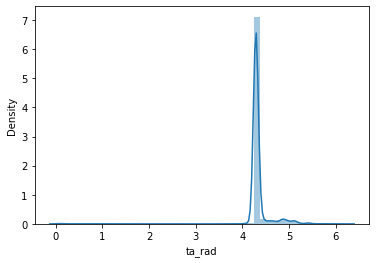

In [ ]:
ax = sns.distplot(df['ta_rad']) # Standardize due to Gaussian Distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


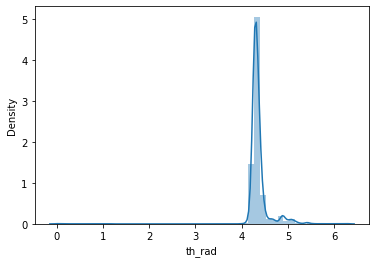

In [ ]:
ax = sns.distplot(df['th_rad']) # Standardize due to Gaussian Distribution

### Latitude / Longitude

In [ ]:
#max_ws = df.pop('max. ws (kt/s)')

lat_rad = df.pop('Best Available Latitude (deg)')*np.pi / 180
long_rad = df.pop('Best Available Longitude (deg)')*np.pi / 180

In [ ]:
df['lat_rad'] = lat_rad
df['long_rad'] = long_rad

In [ ]:
df[['ta_rad', 'th_rad']].head()

ta_rad    th_rad
0  5.783106  5.689533
1  5.634310  5.539203
2  5.485514  5.387339
3  5.332116  5.238543
4  5.177184  5.082077

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


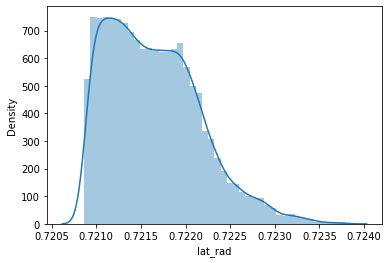

In [ ]:
ax = sns.distplot(df['lat_rad']) # Normalize

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


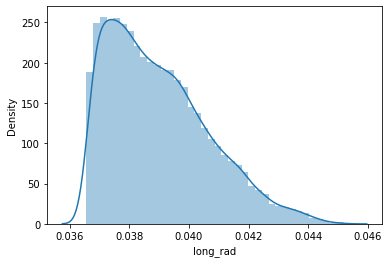

In [ ]:
ax = sns.distplot(df['long_rad']) # Normalize

In [ ]:
df.describe().transpose()

count  ...          max
Original IDs                                        9978.0  ...  9772.000000
Landing Runway ID (numerical) (numerical part o...  9978.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         9978.0  ...  2996.000000
Height Above Touchdown (HAT) (ft)                   9978.0  ...  2991.430030
Pressure Altitude (ft)                              9978.0  ...  3316.000000
Air Temperature (outside) (deg C)                   9978.0  ...    23.002593
Ground Speed (kt)                                   9978.0  ...   277.000000
Airspeed (true) (knots)                             9978.0  ...   282.921075
Airspeed (calibrated; 1 or Only) (knots)            9978.0  ...   273.500000
Mach Number                                         9978.0  ...     0.432078
Air Density (ambient) (slugs/ft³)                   9978.0  ...     0.002516
Air Density (total) (slugs/ft³)                     9978.0  ...     0.002570
Air Pressure (ambient) (lbs/ft²)                    9978.0  ...  2158.755790
Air Pressure (dynamic) (lbs/ft²)                    9978.0  ...   252.328341
Air Pressure (total) (lbs/ft²)                      9978.0  ...  2224.155757
ISA Temperature (deg C)                             9978.0  ...    15.102741
Deviation from ISA Temperature (deg C)              9978.0  ...     9.647910
Speed of Sound (knots)                              9978.0  ...   670.311441
Wx                                                  9978.0  ...    30.339784
Wy                                                  9978.0  ...    29.411643
ta_rad                                              9978.0  ...     6.235630
th_rad                                              9978.0  ...     6.281650
lat_rad                                             9978.0  ...     0.723783
long_rad                                            9978.0  ...     0.045165

[24 rows x 8 columns]

## Data Split

In [ ]:
# Delete columns with string values

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)

For data split, a split of 70%, 15% and 15% is used for training, validation and test sets. An important factor here is, that the data is not randomly shuffled before splitting, because:


1.   Consecutive order is important due to window chopping in the later step.
2.   Validation and test results are more realistic, because the model is first trained with historic data and then sees time wise future data collected after model training.



In [ ]:
#Taken from https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

num_features = df.shape[1]

In [ ]:
train_df.head()

Original IDs  ...  long_rad
0          6348  ...  0.043538
1          6352  ...  0.043490
2          6356  ...  0.043432
3          6360  ...  0.043362
4          6364  ...  0.043285

[5 rows x 24 columns]

## Sliding Window

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in+1
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        if (sequences[i][24] == sequences[i+15][24]-60):  #60 because Original IDs add up +4 every time Check if Original ID is equal, if not, the next flight has begun and this should be separated from the flight beforehand / no false interference shall occur in the time series
            # gather input and output parts of the pattern
            seq_x = sequences[i:end_ix-1, :-3]    #Everythin except the last two items 
            seq_y = sequences[end_ix-1:out_end_ix, -2:]  #the last two items
            X.append(seq_x)
            y.append(seq_y)
        else:
            i = i+15
    return array(X), array(y)

## Approach 1: Mean Normalization (Standardization)

Feature scaling through normalization (subtracting the mean and dividing by the standard deviation of each feature). Everything calculated with the training data, because models have no access to the future mean and standard deviation values in the validation and test sets.

Also, the model shouldn't have access to future values in the training set when training. Furthermore normalization should be done using moving averages. As the real-time implementation of such a neural network is not the focus of this master thesis and this procedure will result in honest metrics, the simple train_mean and std is used for validation and test data sets as well.
https://en.wikipedia.org/wiki/Feature_scaling#Mean_normalization

In [ ]:
train_mean = train_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']].mean()
train_std = train_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']].std()

train_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']] = (train_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']] - train_mean) / train_std
test_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']] = (test_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']] - train_mean) / train_std
val_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']] = (val_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']] - train_mean) / train_std

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


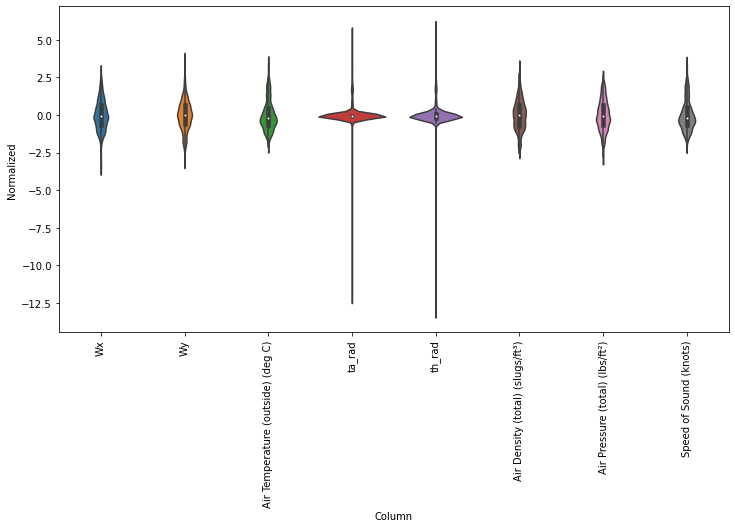

In [ ]:
# Show Distribution of Peak Values according to https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en
df_std = train_df[['Wx','Wy','Air Temperature (outside) (deg C)', 'ta_rad', 'th_rad', 'Air Density (total) (slugs/ft³)', 'Air Pressure (total) (lbs/ft²)', 'Speed of Sound (knots)']]
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_mean.keys(), rotation=90)

In [ ]:
train_df.describe().transpose()

count  ...          max
Original IDs                                        6984.0  ...  9772.000000
Landing Runway ID (numerical) (numerical part o...  6984.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         6984.0  ...  2990.000000
Height Above Touchdown (HAT) (ft)                   6984.0  ...  2991.430030
Pressure Altitude (ft)                              6984.0  ...  3316.000000
Air Temperature (outside) (deg C)                   6984.0  ...     3.550524
Ground Speed (kt)                                   6984.0  ...   277.000000
Airspeed (true) (knots)                             6984.0  ...   282.921075
Airspeed (calibrated; 1 or Only) (knots)            6984.0  ...   273.500000
Mach Number                                         6984.0  ...     0.432078
Air Density (ambient) (slugs/ft³)                   6984.0  ...     0.002516
Air Density (total) (slugs/ft³)                     6984.0  ...     3.281669
Air Pressure (ambient) (lbs/ft²)                    6984.0  ...  2158.755790
Air Pressure (dynamic) (lbs/ft²)                    6984.0  ...   252.328341
Air Pressure (total) (lbs/ft²)                      6984.0  ...     2.595295
ISA Temperature (deg C)                             6984.0  ...    15.102741
Deviation from ISA Temperature (deg C)              6984.0  ...     9.647910
Speed of Sound (knots)                              6984.0  ...     3.523940
Wx                                                  6984.0  ...     2.957531
Wy                                                  6984.0  ...     3.777361
ta_rad                                              6984.0  ...     5.472823
th_rad                                              6984.0  ...     5.895469
lat_rad                                             6984.0  ...     0.723783
long_rad                                            6984.0  ...     0.045165

[24 rows x 8 columns]

In [ ]:
test_df.describe().transpose()

count  ...          max
Original IDs                                        1497.0  ...  9168.000000
Landing Runway ID (numerical) (numerical part o...  1497.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         1497.0  ...  2991.000000
Height Above Touchdown (HAT) (ft)                   1497.0  ...  2943.208084
Pressure Altitude (ft)                              1497.0  ...  3204.000000
Air Temperature (outside) (deg C)                   1497.0  ...     2.172331
Ground Speed (kt)                                   1497.0  ...   231.000000
Airspeed (true) (knots)                             1497.0  ...   235.616471
Airspeed (calibrated; 1 or Only) (knots)            1497.0  ...   227.625000
Mach Number                                         1497.0  ...     0.361044
Air Density (ambient) (slugs/ft³)                   1497.0  ...     0.002458
Air Density (total) (slugs/ft³)                     1497.0  ...     2.217905
Air Pressure (ambient) (lbs/ft²)                    1497.0  ...  2143.875912
Air Pressure (dynamic) (lbs/ft²)                    1497.0  ...   174.942331
Air Pressure (total) (lbs/ft²)                      1497.0  ...     2.137500
ISA Temperature (deg C)                             1497.0  ...    15.096802
Deviation from ISA Temperature (deg C)              1497.0  ...     8.082761
Speed of Sound (knots)                              1497.0  ...     2.166191
Wx                                                  1497.0  ...     4.036960
Wy                                                  1497.0  ...     1.560371
ta_rad                                              1497.0  ...     5.228232
th_rad                                              1497.0  ...     5.584042
lat_rad                                             1497.0  ...     0.722968
long_rad                                            1497.0  ...     0.044145

[24 rows x 8 columns]

In [ ]:
val_df.describe().transpose()

count  ...          max
Original IDs                                        1497.0  ...  9100.000000
Landing Runway ID (numerical) (numerical part o...  1497.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         1497.0  ...  2996.000000
Height Above Touchdown (HAT) (ft)                   1497.0  ...  2939.581902
Pressure Altitude (ft)                              1497.0  ...  2768.000000
Air Temperature (outside) (deg C)                   1497.0  ...     2.400578
Ground Speed (kt)                                   1497.0  ...   246.000000
Airspeed (true) (knots)                             1497.0  ...   230.492595
Airspeed (calibrated; 1 or Only) (knots)            1497.0  ...   223.250000
Mach Number                                         1497.0  ...     0.351358
Air Density (ambient) (slugs/ft³)                   1497.0  ...     0.002497
Air Density (total) (slugs/ft³)                     1497.0  ...     2.790841
Air Pressure (ambient) (lbs/ft²)                    1497.0  ...  2158.134130
Air Pressure (dynamic) (lbs/ft²)                    1497.0  ...   168.464411
Air Pressure (total) (lbs/ft²)                      1497.0  ...     2.466095
ISA Temperature (deg C)                             1497.0  ...    15.080575
Deviation from ISA Temperature (deg C)              1497.0  ...     6.895123
Speed of Sound (knots)                              1497.0  ...     2.391824
Wx                                                  1497.0  ...     2.516984
Wy                                                  1497.0  ...     2.742060
ta_rad                                              1497.0  ...     3.245296
th_rad                                              1497.0  ...     3.376161
lat_rad                                             1497.0  ...     0.723261
long_rad                                            1497.0  ...     0.043622

[24 rows x 8 columns]

## Approach 2: Min Max Normalization

In [ ]:
#Save Original IDS


In [ ]:
train_df_norm = (train_df.loc[:, df.columns != 'Original IDs']-train_df.loc[:, df.columns != 'Original IDs'].min())/(train_df.loc[:, df.columns != 'Original IDs'].max()-train_df.loc[:, df.columns != 'Original IDs'].min())
test_df_norm = (test_df.loc[:, df.columns != 'Original IDs']-train_df.loc[:, df.columns != 'Original IDs'].min())/(train_df.loc[:, df.columns != 'Original IDs'].max()-train_df.loc[:, df.columns != 'Original IDs'].min())
val_df_norm = (val_df-train_df.loc[:, df.columns != 'Original IDs'].min())/(train_df.loc[:, df.columns != 'Original IDs'].max()-train_df.loc[:, df.columns != 'Original IDs'].min())

In [ ]:
train_df_norm.head()

Landing Runway ID (numerical) (numerical part of runway designation)  ...  long_rad
0                                                NaN                     ...  0.810841
1                                                NaN                     ...  0.805326
2                                                NaN                     ...  0.798492
3                                                NaN                     ...  0.790346
4                                                NaN                     ...  0.781444

[5 rows x 23 columns]

In [ ]:
train_df_norm['Original IDs'] = train_df['Original IDs']

In [ ]:
test_df_norm['Original IDs'] = test_df['Original IDs']
val_df_norm['Original IDs'] = val_df['Original IDs']

#### Split Min Max Normalized Training Set

In [ ]:
Wx_array_train_norm=(array(train_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_train_norm=(array(train_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)

out_seq1_train_norm = array([Wx_array_train_norm[i] for i in range(len(Wx_array_train_norm))])
out_seq2_train_norm = array([Wy_array_train_norm[i] for i in range(len(Wy_array_train_norm))])

# convert to [rows, columns] structure
# Convert Train Set to [rows, columns] structur
Wx_array_train_norm=(array(train_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_train_norm=(array(train_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)
HAT_array_train_norm=(array(train_df_norm[['Height Above Touchdown (HAT) (ft)']]['Height Above Touchdown (HAT) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ra_array_train_norm=(array(train_df_norm[['Radio Altitude (1, left, Capt or Only) (ft)']]['Radio Altitude (1, left, Capt or Only) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
pa_array_train_norm=(array(train_df_norm[['Pressure Altitude (ft)']]['Pressure Altitude (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ta_array_train_norm=(array(train_df_norm[['ta_rad']]['ta_rad'].tolist()).astype(np.float)).reshape(-1, 1)
th_array_train_norm=(array(train_df_norm[['th_rad']]['th_rad'].tolist()).astype(np.float)).reshape(-1, 1)
gs_array_train_norm=(array(train_df_norm[['Ground Speed (kt)']]['Ground Speed (kt)'].tolist()).astype(np.float)).reshape(-1, 1)
asc_array_train_norm=(array(train_df_norm[['Airspeed (calibrated; 1 or Only) (knots)']]['Airspeed (calibrated; 1 or Only) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
as_array_train_norm=(array(train_df_norm[['Airspeed (true) (knots)']]['Airspeed (true) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
lat_array_train_norm=(array(train_df_norm[['lat_rad']]['lat_rad'].tolist()).astype(np.float)).reshape(-1, 1)
long_array_train_norm=(array(train_df_norm[['long_rad']]['long_rad'].tolist()).astype(np.float)).reshape(-1, 1)
at_array_train_norm=(array(train_df_norm[['Air Temperature (outside) (deg C)']]['Air Temperature (outside) (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
mn_array_train_norm=(array(train_df_norm[['Mach Number']]['Mach Number'].tolist()).astype(np.float)).reshape(-1, 1)
ada_array_train_norm=(array(train_df_norm[['Air Density (ambient) (slugs/ft³)']]['Air Density (ambient) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
adt_array_train_norm=(array(train_df_norm[['Air Density (total) (slugs/ft³)']]['Air Density (total) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
apa_array_train_norm=(array(train_df_norm[['Air Pressure (ambient) (lbs/ft²)']]['Air Pressure (ambient) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apd_array_train_norm=(array(train_df_norm[['Air Pressure (dynamic) (lbs/ft²)']]['Air Pressure (dynamic) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apt_array_train_norm=(array(train_df_norm[['Air Pressure (total) (lbs/ft²)']]['Air Pressure (total) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
it_array_train_norm=(array(train_df_norm[['ISA Temperature (deg C)']]['ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
dit_array_train_norm=(array(train_df_norm[['Deviation from ISA Temperature (deg C)']]['Deviation from ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
sos_array_train_norm=(array(train_df_norm[['Speed of Sound (knots)']]['Speed of Sound (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
id_array_train_norm=(array(train_df_norm[['Original IDs']]['Original IDs'].tolist()).astype(np.float)).reshape(-1, 1)

Wx_array_train_norm = Wx_array_train_norm.reshape((len(Wx_array_train_norm), 1))
Wy_array_train_norm = Wy_array_train_norm.reshape((len(Wy_array_train_norm), 1))
HAT_array_train_norm = HAT_array_train_norm.reshape((len(HAT_array_train_norm), 1))
ra_array_train_norm = ra_array_train_norm.reshape((len(ra_array_train_norm), 1))
pa_array_train_norm = pa_array_train_norm.reshape((len(pa_array_train_norm), 1))
ta_array_train_norm = ta_array_train_norm.reshape((len(ta_array_train_norm), 1))
th_array_train_norm = th_array_train_norm.reshape((len(th_array_train_norm), 1))
gs_array_train_norm = gs_array_train_norm.reshape((len(gs_array_train_norm), 1))
asc_array_train_norm = asc_array_train_norm.reshape((len(asc_array_train_norm), 1))
as_array_train_norm = as_array_train_norm.reshape((len(as_array_train_norm), 1))
lat_array_train_norm = lat_array_train_norm.reshape((len(lat_array_train_norm), 1))
long_array_train_norm = long_array_train_norm.reshape((len(long_array_train_norm), 1))
at_array_train_norm = at_array_train_norm.reshape((len(at_array_train_norm), 1))
mn_array_train_norm = mn_array_train_norm.reshape((len(mn_array_train_norm), 1))
ada_array_train_norm = ada_array_train_norm.reshape((len(ada_array_train_norm), 1))
adt_array_train_norm = adt_array_train_norm.reshape((len(adt_array_train_norm), 1))
apa_array_train_norm = apa_array_train_norm.reshape((len(apa_array_train_norm), 1))
apd_array_train_norm = apd_array_train_norm.reshape((len(apd_array_train_norm), 1))
apt_array_train_norm = apt_array_train_norm.reshape((len(apt_array_train_norm), 1))
it_array_train_norm = it_array_train_norm.reshape((len(it_array_train_norm), 1))
dit_array_train_norm = dit_array_train_norm.reshape((len(dit_array_train_norm), 1))
sos_array_train_norm = sos_array_train_norm.reshape((len(sos_array_train_norm), 1))
id_array_train_norm = id_array_train_norm.reshape((len(id_array_train_norm), 1))

out_seq1_train_norm = out_seq1_train_norm.reshape((len(out_seq1_train_norm), 1))
out_seq2_train_norm = out_seq2_train_norm.reshape((len(out_seq2_train_norm), 1))
# horizontally stack columns
dataset_train_norm = hstack((Wx_array_train_norm, Wy_array_train_norm, Wx_array_train_norm, Wy_array_train_norm, HAT_array_train_norm, ra_array_train_norm, pa_array_train_norm, ta_array_train_norm, th_array_train_norm, gs_array_train_norm, asc_array_train_norm, as_array_train_norm, lat_array_train_norm, long_array_train_norm, at_array_train_norm, mn_array_train_norm, ada_array_train_norm, adt_array_train_norm, apa_array_train_norm, apd_array_train_norm, apt_array_train_norm, it_array_train_norm, dit_array_train_norm, sos_array_train_norm, id_array_train_norm, out_seq1_train_norm, out_seq2_train_norm))
# choose a number of time steps
n_steps_in, n_steps_out = 15,15
# convert into input/output
X_train_norm, y_train_norm = split_sequences(dataset_train_norm, n_steps_in, n_steps_out)
print(X_train_norm.shape, y_train_norm.shape)
# summarize the data
#for i in range(len(X_train_norm)):
#print(X_train_norm[0], y_train_norm[0])

(5609, 15, 24) (5609, 15, 2)


#### Split Min Max Normalized Test Set

In [ ]:
Wx_array_test_norm=(array(test_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_test_norm=(array(test_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)

out_seq1_test_norm = array([Wx_array_test_norm[i] for i in range(len(Wx_array_test_norm))])
out_seq2_test_norm = array([Wy_array_test_norm[i] for i in range(len(Wy_array_test_norm))])
# convert to [rows, columns] structure
# Convert Test Set to [rows, columns] structur
Wx_array_test_norm=(array(test_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_test_norm=(array(test_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)
HAT_array_test_norm=(array(test_df_norm[['Height Above Touchdown (HAT) (ft)']]['Height Above Touchdown (HAT) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ra_array_test_norm=(array(test_df_norm[['Radio Altitude (1, left, Capt or Only) (ft)']]['Radio Altitude (1, left, Capt or Only) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
pa_array_test_norm=(array(test_df_norm[['Pressure Altitude (ft)']]['Pressure Altitude (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ta_array_test_norm=(array(test_df_norm[['ta_rad']]['ta_rad'].tolist()).astype(np.float)).reshape(-1, 1)
th_array_test_norm=(array(test_df_norm[['th_rad']]['th_rad'].tolist()).astype(np.float)).reshape(-1, 1)
gs_array_test_norm=(array(test_df_norm[['Ground Speed (kt)']]['Ground Speed (kt)'].tolist()).astype(np.float)).reshape(-1, 1)
asc_array_test_norm=(array(test_df_norm[['Airspeed (calibrated; 1 or Only) (knots)']]['Airspeed (calibrated; 1 or Only) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
as_array_test_norm=(array(test_df_norm[['Airspeed (true) (knots)']]['Airspeed (true) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
lat_array_test_norm=(array(test_df_norm[['lat_rad']]['lat_rad'].tolist()).astype(np.float)).reshape(-1, 1)
long_array_test_norm=(array(test_df_norm[['long_rad']]['long_rad'].tolist()).astype(np.float)).reshape(-1, 1)
at_array_test_norm=(array(test_df_norm[['Air Temperature (outside) (deg C)']]['Air Temperature (outside) (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
mn_array_test_norm=(array(test_df_norm[['Mach Number']]['Mach Number'].tolist()).astype(np.float)).reshape(-1, 1)
ada_array_test_norm=(array(test_df_norm[['Air Density (ambient) (slugs/ft³)']]['Air Density (ambient) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
adt_array_test_norm=(array(test_df_norm[['Air Density (total) (slugs/ft³)']]['Air Density (total) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
apa_array_test_norm=(array(test_df_norm[['Air Pressure (ambient) (lbs/ft²)']]['Air Pressure (ambient) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apd_array_test_norm=(array(test_df_norm[['Air Pressure (dynamic) (lbs/ft²)']]['Air Pressure (dynamic) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apt_array_test_norm=(array(test_df_norm[['Air Pressure (total) (lbs/ft²)']]['Air Pressure (total) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
it_array_test_norm=(array(test_df_norm[['ISA Temperature (deg C)']]['ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
dit_array_test_norm=(array(test_df_norm[['Deviation from ISA Temperature (deg C)']]['Deviation from ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
sos_array_test_norm=(array(test_df_norm[['Speed of Sound (knots)']]['Speed of Sound (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
id_array_test_norm=(array(test_df_norm[['Original IDs']]['Original IDs'].tolist()).astype(np.float)).reshape(-1, 1)

Wx_array_test_norm = Wx_array_test_norm.reshape((len(Wx_array_test_norm), 1))
Wy_array_test_norm = Wy_array_test_norm.reshape((len(Wy_array_test_norm), 1))
HAT_array_test_norm = HAT_array_test_norm.reshape((len(HAT_array_test_norm), 1))
ra_array_test_norm = ra_array_test_norm.reshape((len(ra_array_test_norm), 1))
pa_array_test_norm = pa_array_test_norm.reshape((len(pa_array_test_norm), 1))
ta_array_test_norm = ta_array_test_norm.reshape((len(ta_array_test_norm), 1))
th_array_test_norm = th_array_test_norm.reshape((len(th_array_test_norm), 1))
gs_array_test_norm = gs_array_test_norm.reshape((len(gs_array_test_norm), 1))
asc_array_test_norm = asc_array_test_norm.reshape((len(asc_array_test_norm), 1))
as_array_test_norm = as_array_test_norm.reshape((len(as_array_test_norm), 1))
lat_array_test_norm = lat_array_test_norm.reshape((len(lat_array_test_norm), 1))
long_array_test_norm = long_array_test_norm.reshape((len(long_array_test_norm), 1))
at_array_test_norm = at_array_test_norm.reshape((len(at_array_test_norm), 1))
mn_array_test_norm = mn_array_test_norm.reshape((len(mn_array_test_norm), 1))
ada_array_test_norm = ada_array_test_norm.reshape((len(ada_array_test_norm), 1))
adt_array_test_norm = adt_array_test_norm.reshape((len(adt_array_test_norm), 1))
apa_array_test_norm = apa_array_test_norm.reshape((len(apa_array_test_norm), 1))
apd_array_test_norm = apd_array_test_norm.reshape((len(apd_array_test_norm), 1))
apt_array_test_norm = apt_array_test_norm.reshape((len(apt_array_test_norm), 1))
it_array_test_norm = it_array_test_norm.reshape((len(it_array_test_norm), 1))
dit_array_test_norm = dit_array_test_norm.reshape((len(dit_array_test_norm), 1))
sos_array_test_norm = sos_array_test_norm.reshape((len(sos_array_test_norm), 1))
id_array_test_norm = id_array_test_norm.reshape((len(id_array_test_norm), 1))

out_seq1_test_norm = out_seq1_test_norm.reshape((len(out_seq1_test_norm), 1))
out_seq2_test_norm = out_seq2_test_norm.reshape((len(out_seq2_test_norm), 1))
# horizontally stack columns
dataset_test_norm = hstack((Wx_array_test_norm, Wy_array_test_norm, Wx_array_test_norm, Wy_array_test_norm, HAT_array_test_norm, ra_array_test_norm, pa_array_test_norm, ta_array_test_norm, th_array_test_norm, gs_array_test_norm, asc_array_test_norm, as_array_test_norm, lat_array_test_norm, long_array_test_norm, at_array_test_norm, mn_array_test_norm, ada_array_test_norm, adt_array_test_norm, apa_array_test_norm, apd_array_test_norm, apt_array_test_norm, it_array_test_norm, dit_array_test_norm, sos_array_test_norm, id_array_test_norm, out_seq1_test_norm, out_seq2_test_norm))
# choose a number of time steps
n_steps_in, n_steps_out = 15,  15
# convert into input/output
X_test_norm, y_test_norm = split_sequences(dataset_test_norm, n_steps_in, n_steps_out)
print(X_test_norm.shape, y_test_norm.shape)
# summarize the data
#for i in range(len(X_test)):
#    print(X_test[i], y_test[i])






(1213, 15, 24) (1213, 15, 2)


#### Split Min Max Normalized Validation Set

In [ ]:
Wx_array_val_norm=(array(val_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_val_norm=(array(val_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)

out_seq1_val_norm = array([Wx_array_val_norm[i] for i in range(len(Wx_array_val_norm))])
out_seq2_val_norm = array([Wy_array_val_norm[i] for i in range(len(Wy_array_val_norm))])
# convert to [rows, columns] structure
# Convert Val Set to [rows, columns] structur
Wx_array_val_norm=(array(val_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_val_norm=(array(val_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)
HAT_array_val_norm=(array(val_df_norm[['Height Above Touchdown (HAT) (ft)']]['Height Above Touchdown (HAT) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ra_array_val_norm=(array(val_df_norm[['Radio Altitude (1, left, Capt or Only) (ft)']]['Radio Altitude (1, left, Capt or Only) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
pa_array_val_norm=(array(val_df_norm[['Pressure Altitude (ft)']]['Pressure Altitude (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ta_array_val_norm=(array(val_df_norm[['ta_rad']]['ta_rad'].tolist()).astype(np.float)).reshape(-1, 1)
th_array_val_norm=(array(val_df_norm[['th_rad']]['th_rad'].tolist()).astype(np.float)).reshape(-1, 1)
gs_array_val_norm=(array(val_df_norm[['Ground Speed (kt)']]['Ground Speed (kt)'].tolist()).astype(np.float)).reshape(-1, 1)
asc_array_val_norm=(array(val_df_norm[['Airspeed (calibrated; 1 or Only) (knots)']]['Airspeed (calibrated; 1 or Only) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
as_array_val_norm=(array(val_df_norm[['Airspeed (true) (knots)']]['Airspeed (true) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
lat_array_val_norm=(array(val_df_norm[['lat_rad']]['lat_rad'].tolist()).astype(np.float)).reshape(-1, 1)
long_array_val_norm=(array(val_df_norm[['long_rad']]['long_rad'].tolist()).astype(np.float)).reshape(-1, 1)
at_array_val_norm=(array(val_df_norm[['Air Temperature (outside) (deg C)']]['Air Temperature (outside) (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
mn_array_val_norm=(array(val_df_norm[['Mach Number']]['Mach Number'].tolist()).astype(np.float)).reshape(-1, 1)
ada_array_val_norm=(array(val_df_norm[['Air Density (ambient) (slugs/ft³)']]['Air Density (ambient) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
adt_array_val_norm=(array(val_df_norm[['Air Density (total) (slugs/ft³)']]['Air Density (total) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
apa_array_val_norm=(array(val_df_norm[['Air Pressure (ambient) (lbs/ft²)']]['Air Pressure (ambient) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apd_array_val_norm=(array(val_df_norm[['Air Pressure (dynamic) (lbs/ft²)']]['Air Pressure (dynamic) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apt_array_val_norm=(array(val_df_norm[['Air Pressure (total) (lbs/ft²)']]['Air Pressure (total) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
it_array_val_norm=(array(val_df_norm[['ISA Temperature (deg C)']]['ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
dit_array_val_norm=(array(val_df_norm[['Deviation from ISA Temperature (deg C)']]['Deviation from ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
sos_array_val_norm=(array(val_df_norm[['Speed of Sound (knots)']]['Speed of Sound (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
id_array_val_norm=(array(val_df_norm[['Original IDs']]['Original IDs'].tolist()).astype(np.float)).reshape(-1, 1)

Wx_array_val_norm = Wx_array_val_norm.reshape((len(Wx_array_val_norm), 1))
Wy_array_val_norm = Wy_array_val_norm.reshape((len(Wy_array_val_norm), 1))
HAT_array_val_norm = HAT_array_val_norm.reshape((len(HAT_array_val_norm), 1))
ra_array_val_norm = ra_array_val_norm.reshape((len(ra_array_val_norm), 1))
pa_array_val_norm = pa_array_val_norm.reshape((len(pa_array_val_norm), 1))
ta_array_val_norm = ta_array_val_norm.reshape((len(ta_array_val_norm), 1))
th_array_val_norm = th_array_val_norm.reshape((len(th_array_val_norm), 1))
gs_array_val_norm = gs_array_val_norm.reshape((len(gs_array_val_norm), 1))
asc_array_val_norm = asc_array_val_norm.reshape((len(asc_array_val_norm), 1))
as_array_val_norm = as_array_val_norm.reshape((len(as_array_val_norm), 1))
lat_array_val_norm = lat_array_val_norm.reshape((len(lat_array_val_norm), 1))
long_array_val_norm = long_array_val_norm.reshape((len(long_array_val_norm), 1))
at_array_val_norm = at_array_val_norm.reshape((len(at_array_val_norm), 1))
mn_array_val_norm = mn_array_val_norm.reshape((len(mn_array_val_norm), 1))
ada_array_val_norm = ada_array_val_norm.reshape((len(ada_array_val_norm), 1))
adt_array_val_norm = adt_array_val_norm.reshape((len(adt_array_val_norm), 1))
apa_array_val_norm = apa_array_val_norm.reshape((len(apa_array_val_norm), 1))
apd_array_val_norm = apd_array_val_norm.reshape((len(apd_array_val_norm), 1))
apt_array_val_norm = apt_array_val_norm.reshape((len(apt_array_val_norm), 1))
it_array_val_norm = it_array_val_norm.reshape((len(it_array_val_norm), 1))
dit_array_val_norm = dit_array_val_norm.reshape((len(dit_array_val_norm), 1))
sos_array_val_norm = sos_array_val_norm.reshape((len(sos_array_val_norm), 1))
id_array_val_norm = id_array_val_norm.reshape((len(id_array_val_norm), 1))


out_seq1_val_norm = out_seq1_val_norm.reshape((len(out_seq1_val_norm), 1))
out_seq2_val_norm = out_seq2_val_norm.reshape((len(out_seq2_val_norm), 1))
# horizontally stack columns
dataset_val_norm = hstack((Wx_array_val_norm, Wy_array_val_norm, Wx_array_val_norm, Wy_array_val_norm, HAT_array_val_norm, ra_array_val_norm, pa_array_val_norm, ta_array_val_norm, th_array_val_norm, gs_array_val_norm, asc_array_val_norm, as_array_val_norm, lat_array_val_norm, long_array_val_norm, at_array_val_norm, mn_array_val_norm, ada_array_val_norm, adt_array_val_norm, apa_array_val_norm, apd_array_val_norm, apt_array_val_norm, it_array_val_norm, dit_array_val_norm, sos_array_val_norm, id_array_val_norm, out_seq1_val_norm, out_seq2_val_norm))
# choose a number of time steps
n_steps_in, n_steps_out = 15, 15
# convert into input/output
X_val_norm, y_val_norm = split_sequences(dataset_val_norm, n_steps_in, n_steps_out)
print(X_val_norm.shape, y_val_norm.shape)
# summarize the data
#for i in range(len(X_val)):
#    print(X_val[i], y_val[i])







(1168, 15, 24) (1168, 15, 2)


In [ ]:
train_df_norm.describe().transpose()

count  ...     max
Landing Runway ID (numerical) (numerical part o...     0.0  ...     NaN
Radio Altitude (1, left, Capt or Only) (ft)         6984.0  ...     1.0
Height Above Touchdown (HAT) (ft)                   6984.0  ...     1.0
Pressure Altitude (ft)                              6984.0  ...     1.0
Air Temperature (outside) (deg C)                   6984.0  ...     1.0
Ground Speed (kt)                                   6984.0  ...     1.0
Airspeed (true) (knots)                             6984.0  ...     1.0
Airspeed (calibrated; 1 or Only) (knots)            6984.0  ...     1.0
Mach Number                                         6984.0  ...     1.0
Air Density (ambient) (slugs/ft³)                   6984.0  ...     1.0
Air Density (total) (slugs/ft³)                     6984.0  ...     1.0
Air Pressure (ambient) (lbs/ft²)                    6984.0  ...     1.0
Air Pressure (dynamic) (lbs/ft²)                    6984.0  ...     1.0
Air Pressure (total) (lbs/ft²)                      6984.0  ...     1.0
ISA Temperature (deg C)                             6984.0  ...     1.0
Deviation from ISA Temperature (deg C)              6984.0  ...     1.0
Speed of Sound (knots)                              6984.0  ...     1.0
Wx                                                  6984.0  ...     1.0
Wy                                                  6984.0  ...     1.0
ta_rad                                              6984.0  ...     1.0
th_rad                                              6984.0  ...     1.0
lat_rad                                             6984.0  ...     1.0
long_rad                                            6984.0  ...     1.0
Original IDs                                        6984.0  ...  9772.0

[24 rows x 8 columns]

# Deep 1D Encoder CNN

## Model

In [ ]:
model_save_name = Runway + "Deep_1D_Encoder_CNN_"
Filters = "_Filters_128-512_"
path = root_path + model_save_name 
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
def cnn_first_block(x, filters,kernel_size=2):
    i = keras.layers.Conv1D(filters,kernel_size, activation='relu')(x)
    i = keras.layers.BatchNormalization()(i)
    x = keras.layers.Conv1D(filters, kernel_size, activation='relu')(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(filters, kernel_size, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    return x

def cnn_encoding_block(x, filters,kernel_size=2):
    i = keras.layers.Conv1D(filters,kernel_size, activation='relu')(x)
    i = keras.layers.BatchNormalization()(i)
    x = keras.layers.Conv1D(filters, kernel_size, activation='relu')(i)
    return x

def output_layer(x, n_steps_out=n_steps_out):
    i = keras.layers.Flatten()(x)
    x = keras.layers.Dense(50, activation='relu')(i)
    x = keras.layers.Dense(n_steps_out*number_features_predicted)(x)
    x = keras.layers.Reshape([n_steps_out, number_features_predicted])(x)
    return x

In [ ]:
def DCNN_identity_shortcuts():
    n_features=X_train_norm.shape[2]
    inputs = keras.layers.Input(shape=(n_steps_in,n_features))
    p0 = inputs
    p0 = cnn_first_block(p0, f[3])
    p1 = cnn_encoding_block(p0, f[4])
    p2 = cnn_encoding_block(p1, f[5])
    outputs = output_layer(p2)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model_dcnn = DCNN_identity_shortcuts()
model_dcnn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_dcnn.summary()
model_dcnn.save_weights('initial.h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 24)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14, 128)           6272      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 128)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 128)           32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 128)           512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 128)           32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 128)          

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)
 
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_dcnn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_dcnn.load_weights('initial.h5')
history = model_dcnn.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.05054, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp2Deep_1D_Encoder_CNN__bs_32.h5
176/176 - 2s - loss: 0.0858 - mean_absolute_error: 0.2070 - val_loss: 0.0505 - val_mean_absolute_error: 0.1811
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.05054
176/176 - 1s - loss: 0.0245 - mean_absolute_error: 0.1149 - val_loss: 0.0679 - val_mean_absolute_error: 0.2148
Epoch 3/200

Epoch 00003: val_loss improved from 0.05054 to 0.02573, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp2Deep_1D_Encoder_CNN__bs_32.h5
176/176 - 1s - loss: 0.0248 - mean_absolute_error: 0.1136 - val_loss: 0.0257 - val_mean_absolute_error: 0.1196
Epoch 4/200

Epoch 00004: val_loss improved from 0.02573 to 0.01872, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp2Deep_1D_Encoder_CNN__bs_32.h5
176/176 - 1s - loss: 0.0161 - mean_absolute_error: 0.0944 - val_loss: 0.0187 - val_mean_absolute_error: 0.1014
E

In [ ]:
model_dcnn.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_dcnn.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0512


[0.0052825878374278545, 0.051242418587207794]

In [ ]:
 model_dcnn.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0756


[0.010217648930847645, 0.07562283426523209]

In [ ]:
model_dcnn.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0591


[0.006672913674265146, 0.059112899005413055]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_dcnn.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.506890      0.566794  0.018426  0.037194
1    0.534750   0.620656      0.482206      0.514583  0.052544  0.106073
2    0.544796   0.620843      0.516520      0.502122  0.028277  0.118721
3    0.573211   0.617240      0.541600      0.518927  0.031610  0.098313
4    0.555470   0.555096      0.530029      0.525048  0.025441  0.030048
5    0.571601   0.564905      0.464288      0.559926  0.107314  0.004978
6    0.552813   0.556533      0.562124      0.537948  0.009311  0.018585
7    0.542283   0.543212      0.533196      0.515316  0.009087  0.027896
8    0.551716   0.556998      0.477109      0.522915  0.074607  0.034083
9    0.558430   0.552767      0.421915      0.512336  0.136514  0.040431
10   0.556587   0.554328      0.511543      0.508153  0.045044  0.046175
11   0.568270   0.567223      0.475975      0.555483  0.092294  0.011740
12   0.577663   0.581305      0.405167      0.531307  0.172496  0.049998
13   0.565797   0.586258      0.500480      0.535552  0.065316  0.050706
14   0.600218   0.607245      0.524083      0.516556  0.076134  0.090689

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.496875      0.528198   0.062961   0.051042
std     0.018615   0.027907      0.043314      0.019537   0.048061   0.035586
min     0.525316   0.543212      0.405167      0.502122   0.009087   0.004978
25%     0.548256   0.555814      0.476542      0.514949   0.026859   0.028972
50%     0.556587   0.567223      0.506890      0.522915   0.052544   0.040431
75%     0.569936   0.605617      0.527056      0.536750   0.084214   0.070697
max     0.600218   0.620843      0.562124      0.566794   0.172496   0.118721

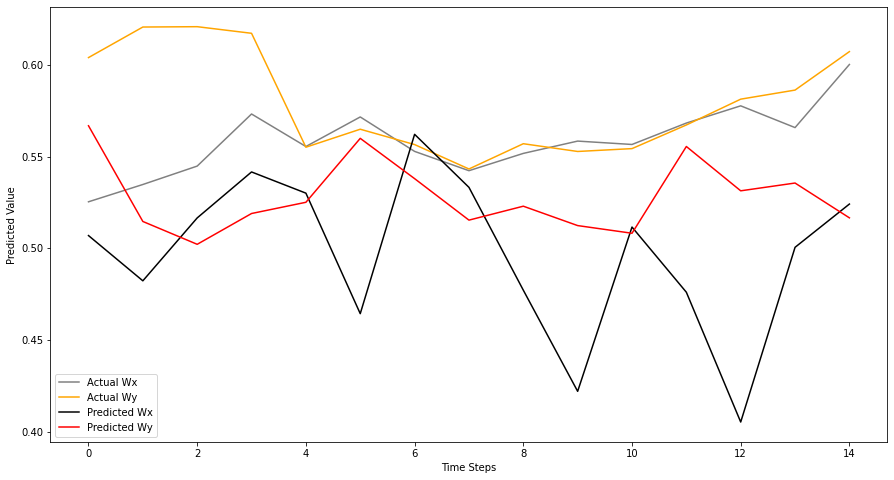

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_dcnn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_dcnn.load_weights('initial.h5')
history = model_dcnn.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.06262, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_64.h5
138/138 - 2s - loss: 0.0965 - mean_absolute_error: 0.2188 - val_loss: 0.0626 - val_mean_absolute_error: 0.2166
Epoch 2/200

Epoch 00002: val_loss improved from 0.06262 to 0.01325, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_64.h5
138/138 - 1s - loss: 0.0164 - mean_absolute_error: 0.0979 - val_loss: 0.0132 - val_mean_absolute_error: 0.0888
Epoch 3/200

Epoch 00003: val_loss improved from 0.01325 to 0.01009, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_64.h5
138/138 - 1s - loss: 0.0119 - mean_absolute_error: 0.0823 - val_loss: 0.0101 - val_mean_absolute_error: 0.0758
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.01009
138/138 - 1s - loss: 0.0094 - mean_absolute_error: 0.0728 - val_loss: 0.0104 - val_mean_absolute_error: 0.0775
Epoch 5/20

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_dcnn.load_weights('initial.h5')
history = model_dcnn.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.14728, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_128.h5
69/69 - 1s - loss: 0.2699 - mean_absolute_error: 0.4497 - val_loss: 0.1473 - val_mean_absolute_error: 0.3627
Epoch 2/200

Epoch 00002: val_loss improved from 0.14728 to 0.06905, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_128.h5
69/69 - 1s - loss: 0.0794 - mean_absolute_error: 0.2433 - val_loss: 0.0690 - val_mean_absolute_error: 0.2334
Epoch 3/200

Epoch 00003: val_loss improved from 0.06905 to 0.04067, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_128.h5
69/69 - 1s - loss: 0.0419 - mean_absolute_error: 0.1691 - val_loss: 0.0407 - val_mean_absolute_error: 0.1673
Epoch 4/200

Epoch 00004: val_loss improved from 0.04067 to 0.02884, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_128.h5
69/69 - 1s - loss: 0.0294

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize = 256
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_dcnn.load_weights('initial.h5')
history = model_dcnn.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.24018, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_256.h5
35/35 - 1s - loss: 0.3078 - mean_absolute_error: 0.5046 - val_loss: 0.2402 - val_mean_absolute_error: 0.4742
Epoch 2/200

Epoch 00002: val_loss improved from 0.24018 to 0.14390, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_256.h5
35/35 - 1s - loss: 0.1519 - mean_absolute_error: 0.3588 - val_loss: 0.1439 - val_mean_absolute_error: 0.3585
Epoch 3/200

Epoch 00003: val_loss improved from 0.14390 to 0.09452, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_256.h5
35/35 - 1s - loss: 0.0923 - mean_absolute_error: 0.2671 - val_loss: 0.0945 - val_mean_absolute_error: 0.2819
Epoch 4/200

Epoch 00004: val_loss improved from 0.09452 to 0.06633, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_256.h5
35/35 - 1s - loss: 0.0618

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize = 512
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_dcnn.load_weights('initial.h5')
history = model_dcnn.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.32631, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_512.h5
18/18 - 1s - loss: 0.3750 - mean_absolute_error: 0.5547 - val_loss: 0.3263 - val_mean_absolute_error: 0.5577
Epoch 2/200

Epoch 00002: val_loss improved from 0.32631 to 0.24751, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_512.h5
18/18 - 1s - loss: 0.2400 - mean_absolute_error: 0.4655 - val_loss: 0.2475 - val_mean_absolute_error: 0.4819
Epoch 3/200

Epoch 00003: val_loss improved from 0.24751 to 0.19130, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_512.h5
18/18 - 1s - loss: 0.1796 - mean_absolute_error: 0.3961 - val_loss: 0.1913 - val_mean_absolute_error: 0.4195
Epoch 4/200

Epoch 00004: val_loss improved from 0.19130 to 0.15154, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_Deep_1D_Encoder_CNN__bs_512.h5
18/18 - 1s - loss: 0.1380

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_dcnn_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_dcnn_mm_norm_32['batch_size'] = 32
df_dcnn_mm_norm_32 = df_dcnn_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_dcnn_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_dcnn_mm_norm_64['batch_size'] = 64
df_dcnn_mm_norm_64 = df_dcnn_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_dcnn_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_dcnn_mm_norm_128['batch_size'] = 128
df_dcnn_mm_norm_128 = df_dcnn_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_dcnn_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_dcnn_mm_norm_256['batch_size'] = 256
df_dcnn_mm_norm_256 = df_dcnn_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_dcnn_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_dcnn_mm_norm_512['batch_size'] = 512
df_dcnn_mm_norm_512 = df_dcnn_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_dcnn.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_dcnn_mm_norm_'))
df_dcnn_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_dcnn_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.075870  ...                 0.112866          32
1        1  0.014830  ...                 0.077081          32
2        2  0.010362  ...                 0.061502          32
3        3  0.008220  ...                 0.066538          32
4        4  0.007561  ...                 0.075901          32
..     ...       ...  ...                      ...         ...
56      56  0.022791  ...                 0.101635         512
57      57  0.022790  ...                 0.101664         512
58      58  0.022791  ...                 0.101628         512
59      59  0.022791  ...                 0.101656         512
60      60  0.022791  ...                 0.101635         512

[419 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

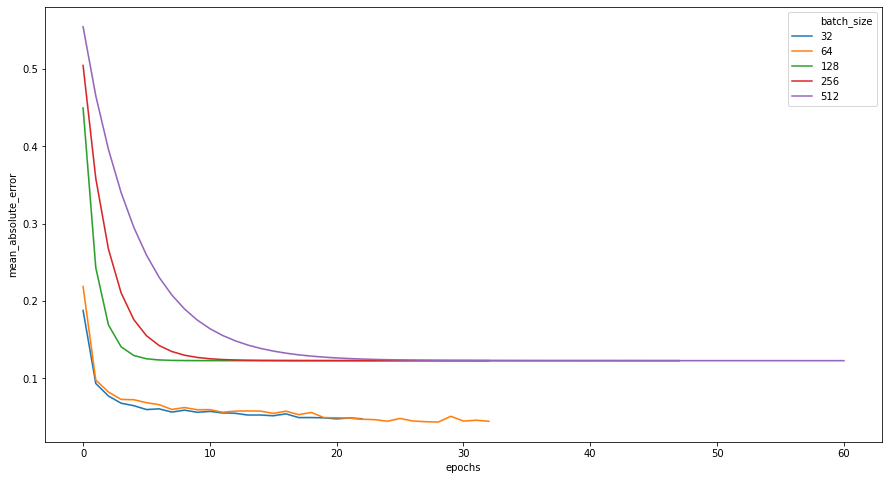

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_dcnn_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

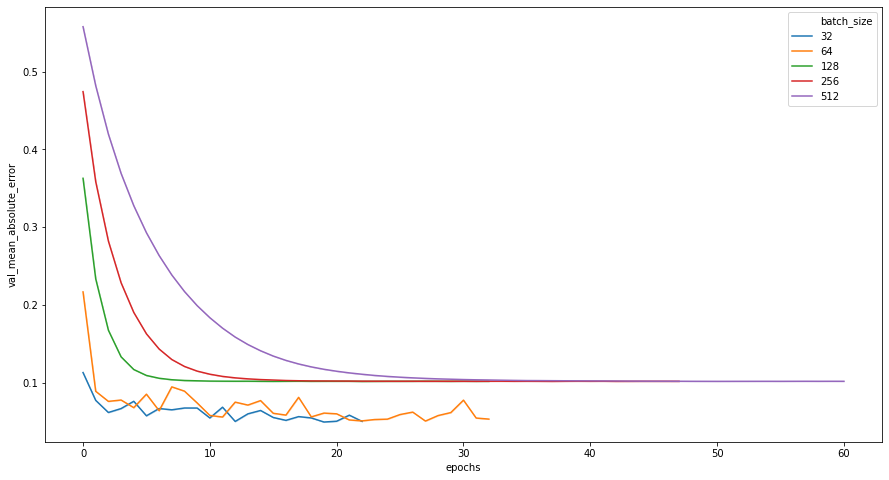

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_dcnn_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

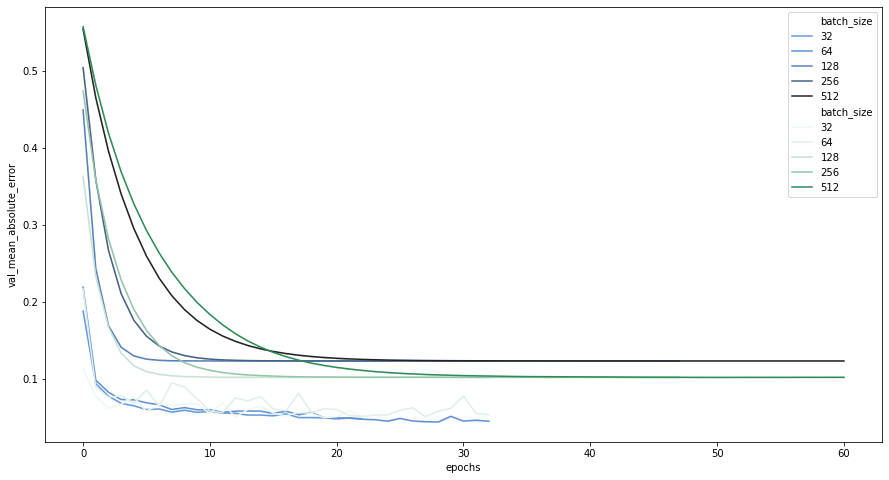

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_dcnn_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_dcnn_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_dcnn.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.522990      0.325023
1   0.274215   0.675515      0.554174      0.308816
2   0.273068   0.684810      0.535734      0.321908
3   0.273068   0.684810      0.502769      0.365852
4   0.284058   0.699703      0.540294      0.368654

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.522990      0.325023  0.259559  0.339273
1    0.274215   0.675515      0.554174      0.308816  0.279959  0.366699
2    0.273068   0.684810      0.535734      0.321908  0.262666  0.362902
3    0.273068   0.684810      0.502769      0.365852  0.229701  0.318957
4    0.284058   0.699703      0.540294      0.368654  0.256235  0.331049
5    0.295614   0.713729      0.531239      0.322127  0.235624  0.391603
6    0.283502   0.708749      0.496951      0.402570  0.213449  0.306179
7    0.307688   0.726868      0.509148      0.369061  0.201461  0.357807
8    0.295399   0.722488      0.476207      0.330079  0.180808  0.392408
9    0.295399   0.722488      0.498845      0.370295  0.203445  0.352193
10   0.295803   0.744383      0.476064      0.364770  0.180261  0.379613
11   0.310281   0.769057      0.503650      0.395236  0.193369  0.373820
12   0.309789   0.764856      0.502774      0.396747  0.192985  0.368109
13   0.327213   0.795699      0.522925      0.366200  0.195712  0.429500
14   0.332048   0.815507      0.521097      0.420226  0.189049  0.395281

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.512991      0.361838   0.218286   0.364360
std     0.020118   0.044308      0.022426      0.033767   0.033113   0.032125
min     0.263431   0.664296      0.476064      0.308816   0.180261   0.306179
25%     0.278859   0.692256      0.500807      0.327551   0.193177   0.345733
50%     0.295399   0.722488      0.509148      0.366200   0.203445   0.366699
75%     0.308738   0.754619      0.527114      0.382766   0.245930   0.385608
max     0.332048   0.815507      0.554174      0.420226   0.279959   0.429500

In [ ]:
df_prediction = df_prediction.reset_index()

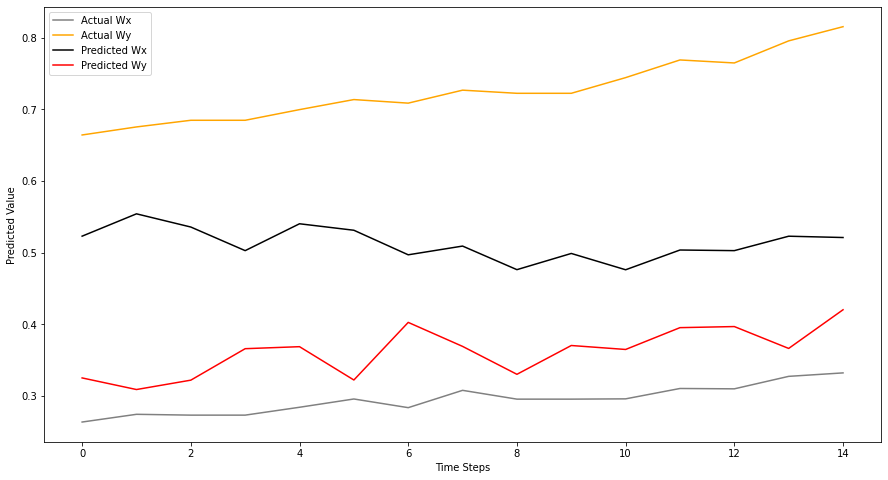

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# Deep Stacked LSTM

## Model

In [ ]:
model_save_name = Runway + "Deep_Stacked_LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
model_stacked_lstm = Sequential()
model_stacked_lstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_stacked_lstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_stacked_lstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_stacked_lstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_stacked_lstm.add(keras.layers.LSTM(100, activation='relu'))
model_stacked_lstm.add(Dense(n_steps_out*number_features_predicted))
model_stacked_lstm.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_stacked_lstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_stacked_lstm.summary()
model_stacked_lstm.save_weights('initial.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 100)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 100)           80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 2)             0

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_stacked_lstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_stacked_lstm.load_weights('initial.h5')

history = model_stacked_lstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.04151, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_Stacked_LSTM__bs_32.h5
176/176 - 20s - loss: 0.0386 - mean_absolute_error: 0.1377 - val_loss: 0.0415 - val_mean_absolute_error: 0.1561
Epoch 2/200

Epoch 00002: val_loss improved from 0.04151 to 0.02640, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_Stacked_LSTM__bs_32.h5
176/176 - 20s - loss: 0.0128 - mean_absolute_error: 0.0877 - val_loss: 0.0264 - val_mean_absolute_error: 0.1218
Epoch 3/200

Epoch 00003: val_loss improved from 0.02640 to 0.02185, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_Stacked_LSTM__bs_32.h5
176/176 - 20s - loss: 0.0103 - mean_absolute_error: 0.0758 - val_loss: 0.0218 - val_mean_absolute_error: 0.1084
Epoch 4/200

Epoch 00004: val_loss improved from 0.02185 to 0.01998, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_Stacked_LSTM__bs_32.h5
176/176 - 19s - loss: 0.0091

In [ ]:
model_stacked_lstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_stacked_lstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 2s 11ms/step - loss: 0.0070 - mean_absolute_error: 0.0597


[0.006999540142714977, 0.05966579169034958]

In [ ]:
 model_stacked_lstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 11ms/step - loss: 0.0123 - mean_absolute_error: 0.0804


[0.012344595044851303, 0.08040589839220047]

In [ ]:
model_stacked_lstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 12ms/step - loss: 0.0076 - mean_absolute_error: 0.0641


[0.0076219202019274235, 0.06405612081289291]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_stacked_lstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.586096      0.475300  0.060780  0.128689
1    0.534750   0.620656      0.588951      0.465778  0.054202  0.154878
2    0.544796   0.620843      0.576096      0.458606  0.031299  0.162237
3    0.573211   0.617240      0.560210      0.452529  0.013001  0.164712
4    0.555470   0.555096      0.546430      0.460044  0.009040  0.095051
5    0.571601   0.564905      0.544507      0.433250  0.027095  0.131654
6    0.552813   0.556533      0.534621      0.464701  0.018192  0.091832
7    0.542283   0.543212      0.498722      0.464689  0.043561  0.078523
8    0.551716   0.556998      0.503148      0.460805  0.048568  0.096193
9    0.558430   0.552767      0.500209      0.450585  0.058220  0.102182
10   0.556587   0.554328      0.495051      0.460536  0.061536  0.093792
11   0.568270   0.567223      0.511086      0.445927  0.057183  0.121296
12   0.577663   0.581305      0.493252      0.427628  0.084411  0.153677
13   0.565797   0.586258      0.487655      0.447498  0.078142  0.138760
14   0.600218   0.607245      0.490205      0.458687  0.110013  0.148558

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.527749      0.455104   0.050350   0.124135
std     0.018615   0.027907      0.036818      0.012589   0.027952   0.029234
min     0.525316   0.543212      0.487655      0.427628   0.009040   0.078523
25%     0.548256   0.555814      0.496887      0.449041   0.029197   0.095622
50%     0.556587   0.567223      0.511086      0.458687   0.054202   0.128689
75%     0.569936   0.605617      0.553320      0.462747   0.061158   0.151118
max     0.600218   0.620843      0.588951      0.475300   0.110013   0.164712

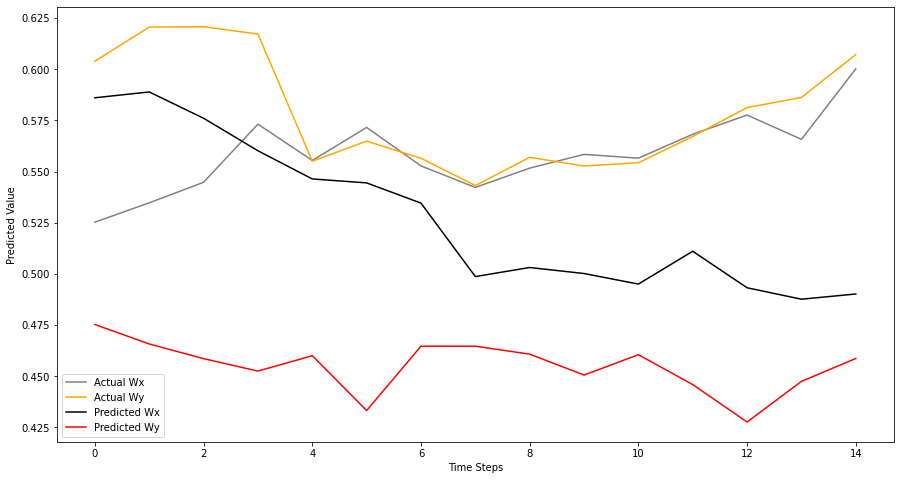

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

NameError: ignored

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_cnnlstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_cnnlstm_mm_norm_32['batch_size'] = 32
df_cnnlstm_mm_norm_32 = df_cnnlstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_cnnlstm_mm_norm_64['batch_size'] = 64
df_cnnlstm_mm_norm_64 = df_cnnlstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_cnnlstm_mm_norm_128['batch_size'] = 128
df_cnnlstm_mm_norm_128 = df_cnnlstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_cnnlstm_mm_norm_256['batch_size'] = 256
df_cnnlstm_mm_norm_256 = df_cnnlstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_cnnlstm_mm_norm_512['batch_size'] = 512
df_cnnlstm_mm_norm_512 = df_cnnlstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_cnnlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_cnnlstm_mm_norm_'))
df_cnnlstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_cnnlstm_mm_norm_results_all

#### Figure Training MAE vs Batch Size over epochs

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_cnnlstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

In [ ]:
y_actual[0]

In [ ]:
range(len(y_actual))

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

In [ ]:
df_prediction.describe()

In [ ]:
df_prediction = df_prediction.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# Deep CNN-LSTM

## Model

In [ ]:
model_save_name = Runway + "Deep_CNN-LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
model_dcnnlstm = Sequential()
model_dcnnlstm.add(keras.layers.Conv1D(128, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_dcnnlstm.add(keras.layers.Conv1D(256, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_dcnnlstm.add(keras.layers.Conv1D(512, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_dcnnlstm.add(keras.layers.MaxPooling1D())
model_dcnnlstm.add(keras.layers.LSTM(100, activation='relu'))
model_dcnnlstm.add(keras.layers.RepeatVector(n_steps_out*number_features_predicted))
model_dcnnlstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_dcnnlstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_dcnnlstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_dcnnlstm.add(keras.layers.TimeDistributed(Dense(1)))
model_dcnnlstm.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_dcnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_dcnnlstm.summary()
model_dcnnlstm.save_weights('initial.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 14, 128)           6272      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 13, 256)           65792     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 512)           262656    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               245200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 100)          

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_dcnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_dcnnlstm.load_weights('initial.h5')

history = model_dcnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.05501, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_CNN-LSTM__bs_32.h5
176/176 - 26s - loss: 0.0312 - mean_absolute_error: 0.1274 - val_loss: 0.0550 - val_mean_absolute_error: 0.1842
Epoch 2/200

Epoch 00002: val_loss improved from 0.05501 to 0.04053, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_CNN-LSTM__bs_32.h5
176/176 - 24s - loss: 0.0156 - mean_absolute_error: 0.0955 - val_loss: 0.0405 - val_mean_absolute_error: 0.1503
Epoch 3/200

Epoch 00003: val_loss improved from 0.04053 to 0.03297, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_CNN-LSTM__bs_32.h5
176/176 - 25s - loss: 0.0130 - mean_absolute_error: 0.0896 - val_loss: 0.0330 - val_mean_absolute_error: 0.1321
Epoch 4/200

Epoch 00004: val_loss improved from 0.03297 to 0.01218, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2Deep_CNN-LSTM__bs_32.h5
176/176 - 25s - loss: 0.0102 - mean_absolute

In [ ]:
model_dcnnlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_dcnnlstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 2s 14ms/step - loss: 0.0061 - mean_absolute_error: 0.0551


[0.006142144091427326, 0.05505126714706421]

In [ ]:
 model_dcnnlstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 1s 14ms/step - loss: 0.0104 - mean_absolute_error: 0.0709


[0.010449452325701714, 0.07087711989879608]

In [ ]:
model_dcnnlstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_absolute_error: 0.0555


[0.006158184725791216, 0.0555466003715992]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_dcnnlstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.520238      0.523913  0.005078  0.080076
1    0.534750   0.620656      0.502720      0.526270  0.032030  0.094386
2    0.544796   0.620843      0.517659      0.513985  0.027137  0.106857
3    0.573211   0.617240      0.536759      0.508811  0.036452  0.108430
4    0.555470   0.555096      0.551216      0.506536  0.004254  0.048559
5    0.571601   0.564905      0.546247      0.504412  0.025355  0.060492
6    0.552813   0.556533      0.538057      0.504352  0.014755  0.052181
7    0.542283   0.543212      0.530985      0.504253  0.011298  0.038959
8    0.551716   0.556998      0.524252      0.504088  0.027463  0.052910
9    0.558430   0.552767      0.515575      0.504202  0.042854  0.048565
10   0.556587   0.554328      0.509193      0.504355  0.047394  0.049972
11   0.568270   0.567223      0.506457      0.503899  0.061813  0.063324
12   0.577663   0.581305      0.504557      0.502994  0.073106  0.078311
13   0.565797   0.586258      0.502945      0.501853  0.062852  0.084405
14   0.600218   0.607245      0.501477      0.500647  0.098741  0.106598

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.520556      0.507638   0.038039   0.071602
std     0.018615   0.027907      0.016692      0.007749   0.026888   0.024109
min     0.525316   0.543212      0.501477      0.500647   0.004254   0.038959
25%     0.548256   0.555814      0.505507      0.503993   0.020055   0.051077
50%     0.556587   0.567223      0.517659      0.504352   0.032030   0.063324
75%     0.569936   0.605617      0.533872      0.507674   0.054603   0.089395
max     0.600218   0.620843      0.551216      0.526270   0.098741   0.108430

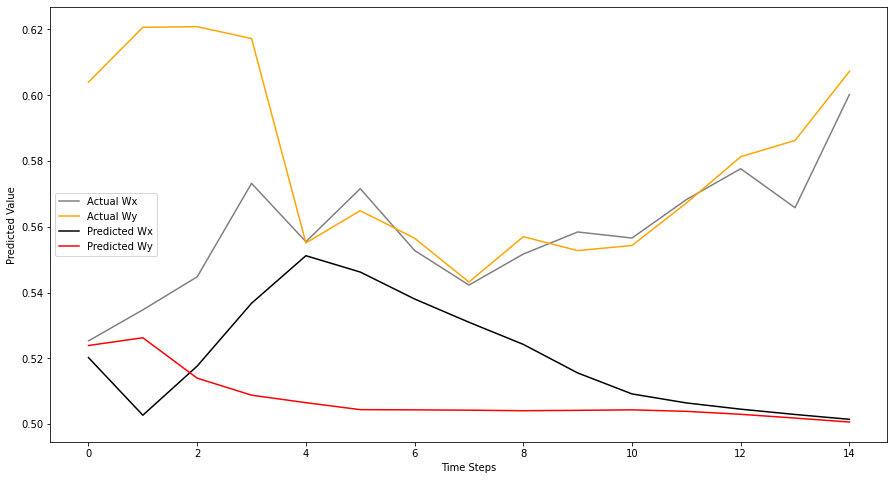

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_cnnlstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_cnnlstm_mm_norm_32['batch_size'] = 32
df_cnnlstm_mm_norm_32 = df_cnnlstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_cnnlstm_mm_norm_64['batch_size'] = 64
df_cnnlstm_mm_norm_64 = df_cnnlstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_cnnlstm_mm_norm_128['batch_size'] = 128
df_cnnlstm_mm_norm_128 = df_cnnlstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_cnnlstm_mm_norm_256['batch_size'] = 256
df_cnnlstm_mm_norm_256 = df_cnnlstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_cnnlstm_mm_norm_512['batch_size'] = 512
df_cnnlstm_mm_norm_512 = df_cnnlstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_cnnlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_cnnlstm_mm_norm_'))
df_cnnlstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_cnnlstm_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.021745  ...                 0.087814          32
1        1  0.014158  ...                 0.085521          32
2        2  0.012825  ...                 0.074947          32
3        3  0.011061  ...                 0.070147          32
4        4  0.010831  ...                 0.066583          32
..     ...       ...  ...                      ...         ...
26      26  0.010523  ...                 0.069215         512
27      27  0.010542  ...                 0.066594         512
28      28  0.010590  ...                 0.066470         512
29      29  0.010554  ...                 0.072404         512
30      30  0.010544  ...                 0.065878         512

[167 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

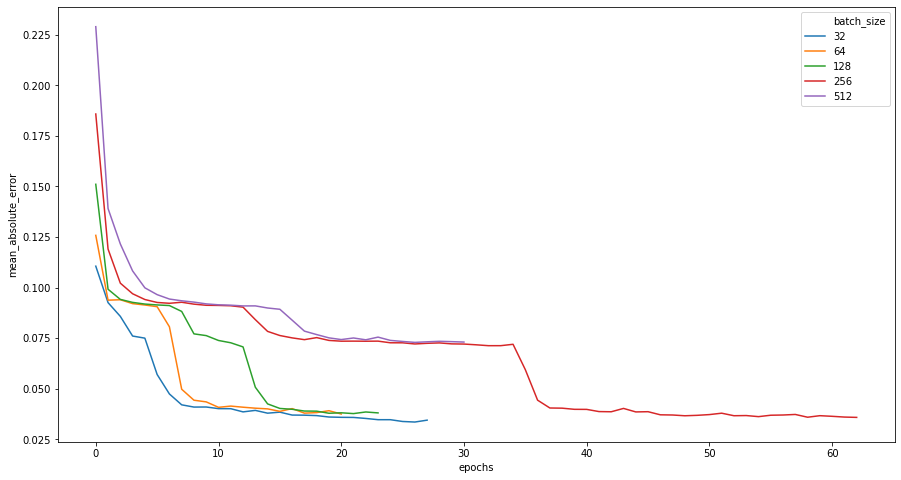

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

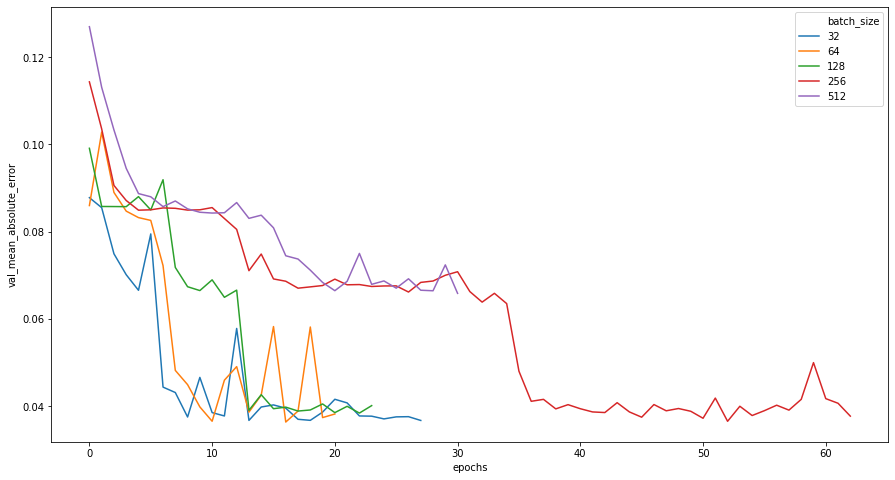

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

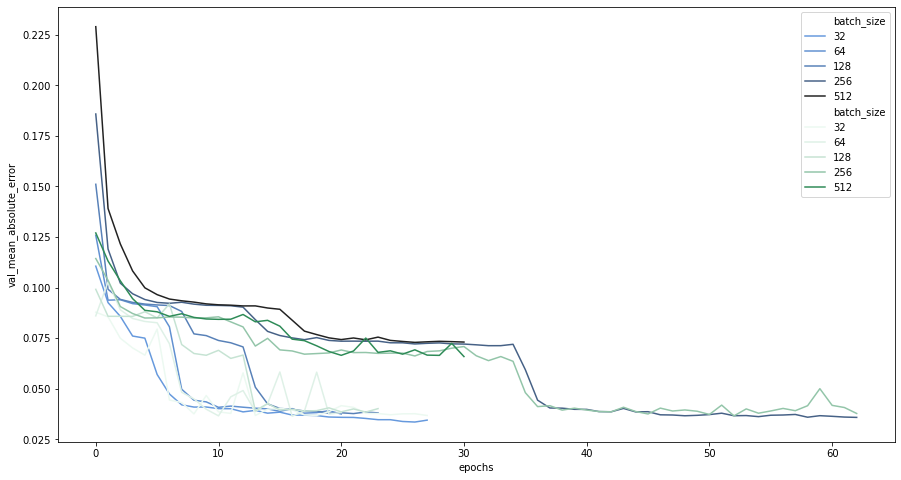

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_cnnlstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.401138      0.140027
1   0.274215   0.675515      0.360479      0.123125
2   0.273068   0.684810      0.354627      0.114037
3   0.273068   0.684810      0.351595      0.116958
4   0.284058   0.699703      0.351285      0.122289

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.401138      0.140027  0.137707  0.524269
1    0.274215   0.675515      0.360479      0.123125  0.086264  0.552391
2    0.273068   0.684810      0.354627      0.114037  0.081559  0.570773
3    0.273068   0.684810      0.351595      0.116958  0.078527  0.567852
4    0.284058   0.699703      0.351285      0.122289  0.067226  0.577414
5    0.295614   0.713729      0.351812      0.128676  0.056197  0.585054
6    0.283502   0.708749      0.353165      0.135784  0.069663  0.572965
7    0.307688   0.726868      0.355282      0.143077  0.047594  0.583791
8    0.295399   0.722488      0.357777      0.150545  0.062377  0.571943
9    0.295399   0.722488      0.359638      0.158246  0.064239  0.564242
10   0.295803   0.744383      0.361414      0.166087  0.065611  0.578296
11   0.310281   0.769057      0.363558      0.173671  0.053276  0.595385
12   0.309789   0.764856      0.366673      0.180854  0.056884  0.584001
13   0.327213   0.795699      0.369429      0.188094  0.042216  0.607606
14   0.332048   0.815507      0.371448      0.194601  0.039400  0.620907

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.361955      0.149071   0.067249   0.577126
std     0.020118   0.044308      0.012624      0.026654   0.023773   0.022484
min     0.263431   0.664296      0.351285      0.114037   0.039400   0.524269
25%     0.278859   0.692256      0.353896      0.125900   0.054737   0.569312
50%     0.295399   0.722488      0.359638      0.143077   0.064239   0.577414
75%     0.308738   0.754619      0.365115      0.169879   0.074095   0.584527
max     0.332048   0.815507      0.401138      0.194601   0.137707   0.620907

In [ ]:
df_prediction = df_prediction.reset_index()

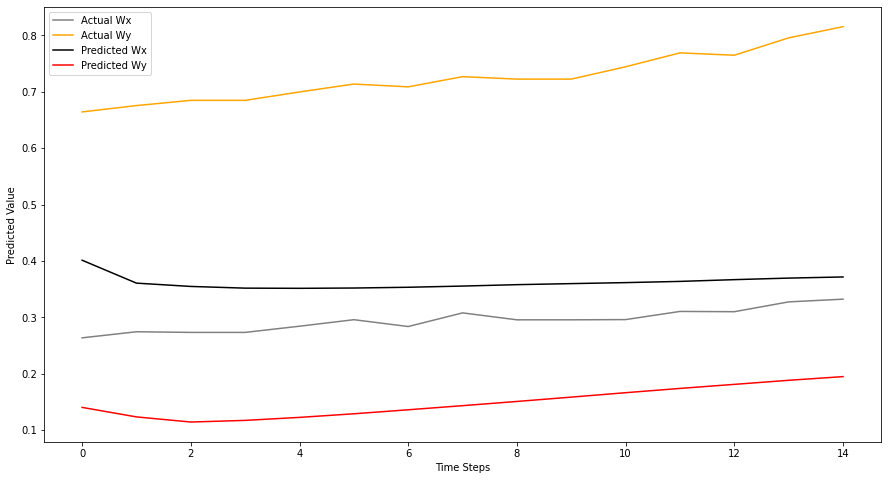

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# 1D U-Net

## Model

In [ ]:
model_save_name = Runway + "1D_U-Net_"
Filters = "_Filters_128-512_"
path = root_path + model_save_name
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
def down_block_first(x, filters,kernel_size=2, strides=1, padding = "same"):
    i = keras.layers.Conv1D(filters,kernel_size, strides, padding, activation='relu')(x)
    i = keras.layers.BatchNormalization()(i)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    p = keras.layers.MaxPooling1D(pool_size=2) (x) 
    return p

def down_block(x,filters,kernel_size=2, strides = 1, padding = "same"):
    i = keras.layers.Conv1D(filters,kernel_size, strides, padding, activation='relu')(x)
    i = keras.layers.BatchNormalization()(i)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    p = keras.layers.MaxPooling1D(pool_size=2)(x)
    return p


def cnn_block(x,filters,kernel_size=2, strides=1, padding = "same"):
    i = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    return x

def up_block(x, p, filters,kernel_size=2, strides=1, padding = "same"):
    concat = keras.layers.Concatenate()([x,p])
    i = keras.layers.Conv1D(filters,kernel_size, strides, padding, activation='relu')(concat)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    x = keras.layers.UpSampling1D(size=3)(x)
    return x

def output_layer(x, n_steps_out=n_steps_out):
    i = keras.layers.Flatten()(x)
    x = keras.layers.Dense(50, activation='relu')(i)
    x = keras.layers.Dense(n_steps_out*number_features_predicted)(x)
    x = keras.layers.Reshape([n_steps_out, number_features_predicted])(x)
    return x

In [ ]:
def U_Net_1D_identity_shortcuts():
    n_features=X_train_norm.shape[2]
    inputs = keras.layers.Input(shape=(n_steps_in,n_features))
    p0 = inputs
    p0 = down_block_first(p0, f[2])
    c0 = p0
    p1 = down_block(p0, f[3])
    c1 = p1
    p2 = down_block(p1, f[4])
    c2 = p2
    
    cm = cnn_block(p2, f[5])
    
    u1 = up_block(cm, c2, f[4])
    u2 = up_block(u1, c1, f[3])
    
    outputs = output_layer(u2)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model_unet = U_Net_1D_identity_shortcuts()
model_unet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_unet.summary()
model_unet.save_weights('initial.h5')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 24)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 15, 64)       3136        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 15, 64)       256         conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 15, 64)       8256        batch_normalization_5[0][0]      
_______________________________________________________________________________________

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_unet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_unet.load_weights('initial.h5')

history = model_unet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.12407, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_U-Net__bs_32.h5
176/176 - 3s - loss: 0.0161 - mean_absolute_error: 0.0875 - val_loss: 0.1241 - val_mean_absolute_error: 0.2980
Epoch 2/200

Epoch 00002: val_loss improved from 0.12407 to 0.04903, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_U-Net__bs_32.h5
176/176 - 2s - loss: 0.0074 - mean_absolute_error: 0.0628 - val_loss: 0.0490 - val_mean_absolute_error: 0.1810
Epoch 3/200

Epoch 00003: val_loss improved from 0.04903 to 0.02591, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_U-Net__bs_32.h5
176/176 - 2s - loss: 0.0068 - mean_absolute_error: 0.0599 - val_loss: 0.0259 - val_mean_absolute_error: 0.1208
Epoch 4/200

Epoch 00004: val_loss improved from 0.02591 to 0.01312, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_U-Net__bs_32.h5
176/176 - 2s - loss: 0.0057 - mean_absolute_error: 0.05

In [ ]:
model_unet.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_unet.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0529


[0.005251739639788866, 0.052917931228876114]

In [ ]:
 model_unet.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 4ms/step - loss: 0.0119 - mean_absolute_error: 0.0786


[0.011875932104885578, 0.07857395708560944]

In [ ]:
model_unet.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 5ms/step - loss: 0.0066 - mean_absolute_error: 0.0594


[0.006629027426242828, 0.0594136081635952]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_unet.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.515650      0.532518  0.009666  0.071470
1    0.534750   0.620656      0.546638      0.494400  0.011888  0.126256
2    0.544796   0.620843      0.551329      0.482776  0.006532  0.138067
3    0.573211   0.617240      0.519390      0.461430  0.053821  0.155810
4    0.555470   0.555096      0.486033      0.447825  0.069437  0.107270
5    0.571601   0.564905      0.480088      0.436484  0.091513  0.128420
6    0.552813   0.556533      0.535975      0.424576  0.016837  0.131957
7    0.542283   0.543212      0.494266      0.415998  0.048017  0.127213
8    0.551716   0.556998      0.514163      0.423144  0.037553  0.133854
9    0.558430   0.552767      0.459227      0.364004  0.099203  0.188763
10   0.556587   0.554328      0.511293      0.389649  0.045294  0.164679
11   0.568270   0.567223      0.487573      0.407902  0.080697  0.159321
12   0.577663   0.581305      0.510149      0.359295  0.067514  0.222010
13   0.565797   0.586258      0.496230      0.339316  0.069566  0.246941
14   0.600218   0.607245      0.516270      0.402563  0.083948  0.204682

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.508285      0.425459   0.052766   0.153781
std     0.018615   0.027907      0.025138      0.052916   0.031002   0.045878
min     0.525316   0.543212      0.459227      0.339316   0.006532   0.071470
25%     0.548256   0.555814      0.490920      0.396106   0.027195   0.127817
50%     0.556587   0.567223      0.511293      0.423144   0.053821   0.138067
75%     0.569936   0.605617      0.517830      0.454628   0.075132   0.176721
max     0.600218   0.620843      0.551329      0.532518   0.099203   0.246941

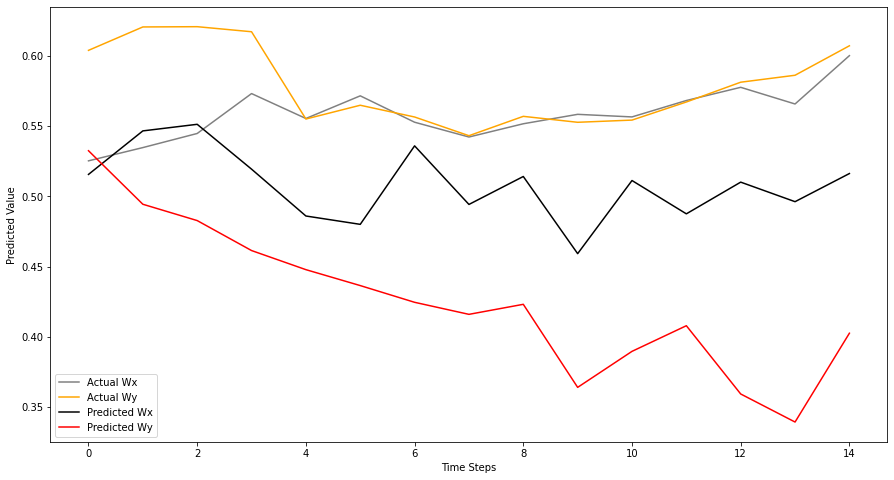

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_unet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_unet.load_weights('initial.h5')
history = model_unet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.12766, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_64.h5
138/138 - 3s - loss: 0.0200 - mean_absolute_error: 0.0883 - val_loss: 0.1277 - val_mean_absolute_error: 0.3371
Epoch 2/200

Epoch 00002: val_loss improved from 0.12766 to 0.03406, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_64.h5
138/138 - 2s - loss: 0.0061 - mean_absolute_error: 0.0564 - val_loss: 0.0341 - val_mean_absolute_error: 0.1576
Epoch 3/200

Epoch 00003: val_loss improved from 0.03406 to 0.01755, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_64.h5
138/138 - 2s - loss: 0.0046 - mean_absolute_error: 0.0476 - val_loss: 0.0176 - val_mean_absolute_error: 0.1114
Epoch 4/200

Epoch 00004: val_loss improved from 0.01755 to 0.00465, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_64.h5
138/138 - 2s - loss: 0.0045 - mean_absolute_error: 0.0471 - val_los

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_unet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_unet.load_weights('initial.h5')
history = model_unet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.16826, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_128.h5
69/69 - 3s - loss: 0.0340 - mean_absolute_error: 0.1202 - val_loss: 0.1683 - val_mean_absolute_error: 0.3917
Epoch 2/200

Epoch 00002: val_loss improved from 0.16826 to 0.09525, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_128.h5
69/69 - 1s - loss: 0.0055 - mean_absolute_error: 0.0534 - val_loss: 0.0952 - val_mean_absolute_error: 0.2855
Epoch 3/200

Epoch 00003: val_loss improved from 0.09525 to 0.04843, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_128.h5
69/69 - 1s - loss: 0.0045 - mean_absolute_error: 0.0470 - val_loss: 0.0484 - val_mean_absolute_error: 0.1933
Epoch 4/200

Epoch 00004: val_loss improved from 0.04843 to 0.02973, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_128.h5
69/69 - 1s - loss: 0.0044 - mean_absolute_error: 0.0471 - val_loss: 0

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_unet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_unet.load_weights('initial.h5')
history = model_unet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.26970, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_256.h5
35/35 - 2s - loss: 0.0579 - mean_absolute_error: 0.1663 - val_loss: 0.2697 - val_mean_absolute_error: 0.5044
Epoch 2/200

Epoch 00002: val_loss improved from 0.26970 to 0.19646, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_256.h5
35/35 - 1s - loss: 0.0075 - mean_absolute_error: 0.0638 - val_loss: 0.1965 - val_mean_absolute_error: 0.4263
Epoch 3/200

Epoch 00003: val_loss improved from 0.19646 to 0.14684, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_256.h5
35/35 - 1s - loss: 0.0050 - mean_absolute_error: 0.0498 - val_loss: 0.1468 - val_mean_absolute_error: 0.3634
Epoch 4/200

Epoch 00004: val_loss improved from 0.14684 to 0.12431, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_256.h5
35/35 - 1s - loss: 0.0042 - mean_absolute_error: 0.0452 - val_loss: 0

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_unet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_unet.load_weights('initial.h5')
history = model_unet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.31629, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_512.h5
18/18 - 2s - loss: 0.1011 - mean_absolute_error: 0.2423 - val_loss: 0.3163 - val_mean_absolute_error: 0.5487
Epoch 2/200

Epoch 00002: val_loss improved from 0.31629 to 0.24929, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_512.h5
18/18 - 1s - loss: 0.0133 - mean_absolute_error: 0.0877 - val_loss: 0.2493 - val_mean_absolute_error: 0.4837
Epoch 3/200

Epoch 00003: val_loss improved from 0.24929 to 0.20913, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_512.h5
18/18 - 1s - loss: 0.0081 - mean_absolute_error: 0.0666 - val_loss: 0.2091 - val_mean_absolute_error: 0.4404
Epoch 4/200

Epoch 00004: val_loss improved from 0.20913 to 0.17697, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_U-Net__bs_512.h5
18/18 - 1s - loss: 0.0060 - mean_absolute_error: 0.0555 - val_loss: 0

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# save model
# serialize model to JSON
model_json = model_unet.to_json()
with open(hist_csv_file_512_mm_norm + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_unet.save_weights(hist_csv_file_512_mm_norm + ".h5")
print("Saved model to disk")

Saved model to disk


## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_unet_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_unet_mm_norm_32['batch_size'] = 32
df_unet_mm_norm_32 = df_unet_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_unet_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_unet_mm_norm_64['batch_size'] = 64
df_unet_mm_norm_64 = df_unet_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_unet_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_unet_mm_norm_128['batch_size'] = 128
df_unet_mm_norm_128 = df_unet_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_unet_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_unet_mm_norm_256['batch_size'] = 256
df_unet_mm_norm_256 = df_unet_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_unet_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_unet_mm_norm_512['batch_size'] = 512
df_unet_mm_norm_512 = df_unet_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_unet.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_unet_mm_norm_'))
df_unet_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_unet_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.018219  ...                 0.169784          32
1        1  0.005731  ...                 0.059537          32
2        2  0.005529  ...                 0.062498          32
3        3  0.005006  ...                 0.038691          32
4        4  0.004416  ...                 0.048996          32
..     ...       ...  ...                      ...         ...
44      44  0.001966  ...                 0.047542         512
45      45  0.001997  ...                 0.044252         512
46      46  0.002116  ...                 0.060473         512
47      47  0.002251  ...                 0.043803         512
48      48  0.001923  ...                 0.044115         512

[289 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

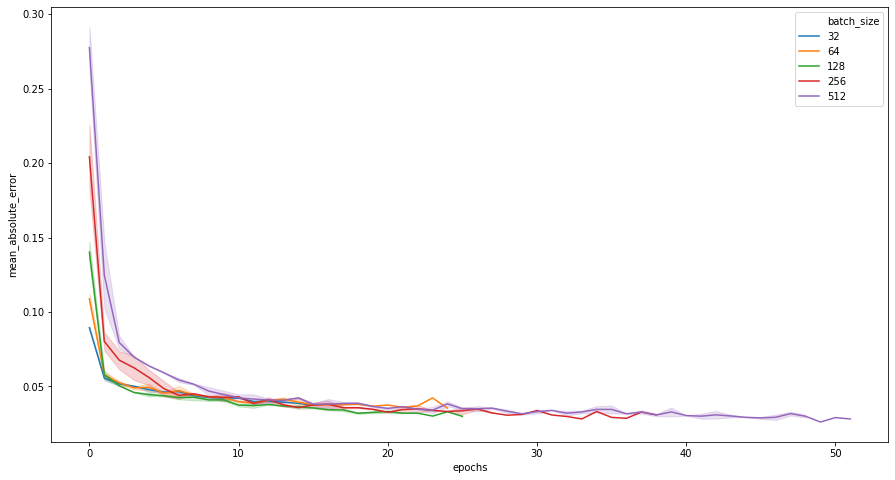

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_unet_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

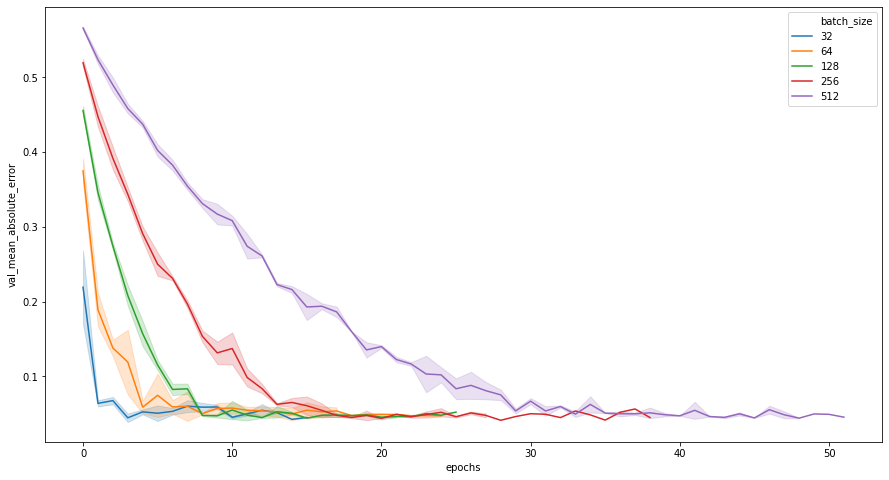

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_unet_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

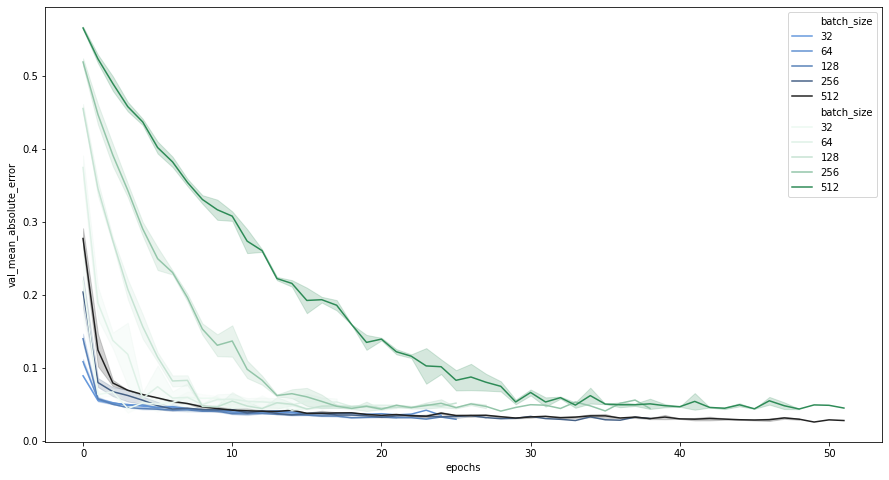

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_unet_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_unet_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_unet.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.356348      0.196919
1   0.274215   0.675515      0.413958      0.120957
2   0.273068   0.684810      0.382124      0.171508
3   0.273068   0.684810      0.396836      0.110557
4   0.284058   0.699703      0.399276      0.161698

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.356348      0.196919  0.092917  0.467377
1    0.274215   0.675515      0.413958      0.120957  0.139743  0.554558
2    0.273068   0.684810      0.382124      0.171508  0.109056  0.513302
3    0.273068   0.684810      0.396836      0.110557  0.123768  0.574253
4    0.284058   0.699703      0.399276      0.161698  0.115218  0.538005
5    0.295614   0.713729      0.349173      0.143302  0.053558  0.570428
6    0.283502   0.708749      0.440061      0.140827  0.156558  0.567922
7    0.307688   0.726868      0.363406      0.155709  0.055718  0.571159
8    0.295399   0.722488      0.359075      0.134534  0.063676  0.587954
9    0.295399   0.722488      0.358007      0.132753  0.062607  0.589734
10   0.295803   0.744383      0.368471      0.207603  0.072668  0.536780
11   0.310281   0.769057      0.402144      0.197666  0.091863  0.571390
12   0.309789   0.764856      0.352682      0.224689  0.042893  0.540167
13   0.327213   0.795699      0.372585      0.185899  0.045372  0.609800
14   0.332048   0.815507      0.387840      0.177864  0.055791  0.637643

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.380132      0.164166   0.085427   0.562032
std     0.020118   0.044308      0.026203      0.033935   0.036224   0.040485
min     0.263431   0.664296      0.349173      0.110557   0.042893   0.467377
25%     0.278859   0.692256      0.358541      0.137680   0.055755   0.539086
50%     0.295399   0.722488      0.372585      0.161698   0.072668   0.570428
75%     0.308738   0.754619      0.398056      0.191409   0.112137   0.581103
max     0.332048   0.815507      0.440061      0.224689   0.156558   0.637643

In [ ]:
df_prediction = df_prediction.reset_index()

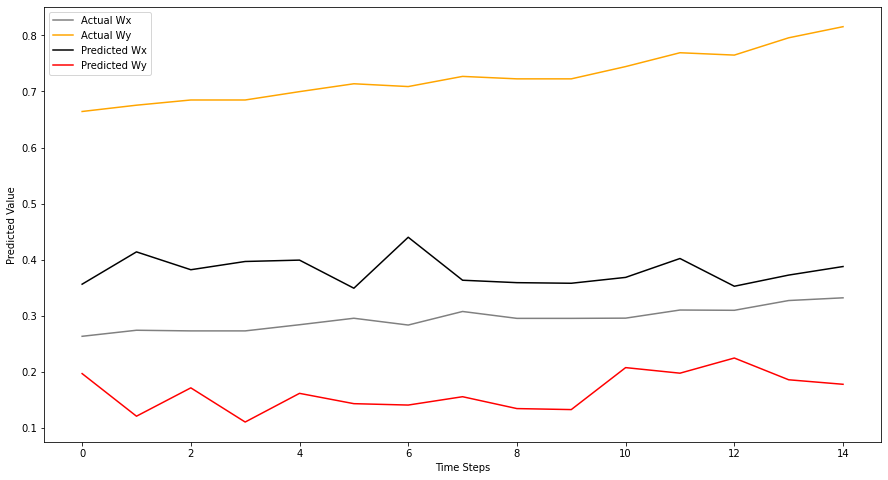

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# 1D ResU-Net

## Model

In [ ]:
model_save_name = Runway + "1D_ResU-Net_"
Filters = "_Filters_128-512_"
path = root_path + model_save_name
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
def residual_down_block_first(x, filters,kernel_size=2, strides=1, padding = "same"):
  #  print("input = ",x.shape, x)
    i = keras.layers.Conv1D(filters,kernel_size, strides, padding, activation='relu')(x)
    i = keras.layers.BatchNormalization()(i)
  #  print("after first conv shape",i.shape)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    x = keras.layers.BatchNormalization()(x)
   # print("after second conv shape",x.shape)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
   # print("after third conv shape",x.shape)
    x = keras.layers.Add()([i,x])
    #print("after residual connection shape", x.shape, x)
    p = keras.layers.MaxPooling1D(pool_size=2) (x) 
    return p

def residual_down_block(x,filters,kernel_size=2, strides = 1, padding = "same"):
    i = keras.layers.Conv1D(filters,kernel_size, strides, padding, activation='relu')(x)
    i = keras.layers.BatchNormalization()(i)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    x = keras.layers.Add()([i,x])
    p = keras.layers.MaxPooling1D(pool_size=2)(x)
    return p

def conv_block(x,filters,kernel_size=2, strides=1, padding = "same"):
    i = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    return x

def residual_up_block(x, p, filters,kernel_size=2, strides=1, padding = "same"):
    concat = keras.layers.Concatenate()([x,p])
    i = keras.layers.Conv1D(filters,kernel_size, strides, padding, activation='relu')(concat)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(i)
    x = keras.layers.Conv1D(filters, kernel_size, strides, padding, activation='relu')(x)
    x = keras.layers.Add()([i,x])
    x = keras.layers.UpSampling1D(size=3)(x)
    return x

def output_layer(x, n_steps_out=n_steps_out):
    i = keras.layers.Flatten()(x)
    x = keras.layers.Dense(50, activation='relu')(i)
    x = keras.layers.Dense(n_steps_out*number_features_predicted)(x)
    x = keras.layers.Reshape([n_steps_out, number_features_predicted])(x)
    return x

In [ ]:
def ResU_Net_1D_identity_shortcuts():
    n_features=X_train_norm.shape[2]
    inputs = keras.layers.Input(shape=(n_steps_in,n_features))
    p0 = inputs
    p0 = residual_down_block_first(p0, f[2])
    c0 = p0
    p1 = residual_down_block(p0, f[3])
    c1 = p1
    p2 = residual_down_block(p1, f[4])
    c2 = p2
    
    cm = conv_block(p2, f[5])
    
    u1 = residual_up_block(cm, c2, f[4])
    u2 = residual_up_block(u1, c1, f[3])
    
    outputs = output_layer(u2)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model_resunet = ResU_Net_1D_identity_shortcuts()
model_resunet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_resunet.summary()
model_resunet.save_weights('initial.h5')

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 24)]     0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 15, 64)       3136        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 15, 64)       256         conv1d_27[0][0]                  
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 15, 64)       8256        batch_normalization_11[0][0]     
_______________________________________________________________________________________

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_resunet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_resunet.load_weights('initial.h5')

history = model_resunet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.10558, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_ResU-Net__bs_32.h5
176/176 - 3s - loss: 0.0616 - mean_absolute_error: 0.1599 - val_loss: 0.1056 - val_mean_absolute_error: 0.2731
Epoch 2/200

Epoch 00002: val_loss improved from 0.10558 to 0.04113, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_ResU-Net__bs_32.h5
176/176 - 2s - loss: 0.0099 - mean_absolute_error: 0.0750 - val_loss: 0.0411 - val_mean_absolute_error: 0.1633
Epoch 3/200

Epoch 00003: val_loss improved from 0.04113 to 0.02254, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_ResU-Net__bs_32.h5
176/176 - 2s - loss: 0.0068 - mean_absolute_error: 0.0599 - val_loss: 0.0225 - val_mean_absolute_error: 0.1157
Epoch 4/200

Epoch 00004: val_loss improved from 0.02254 to 0.01630, saving model to gdrive/My Drive/Data/BCN25R/BCN25R_Wxy_mm_norm_pp21D_ResU-Net__bs_32.h5
176/176 - 2s - loss: 0.0063 - mean_absolute

In [ ]:
model_resunet.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_resunet.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 4ms/step - loss: 0.0060 - mean_absolute_error: 0.0553


[0.00597455445677042, 0.05530034378170967]

In [ ]:
 model_resunet.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0851


[0.013285092078149319, 0.08508790284395218]

In [ ]:
model_resunet.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0619


[0.007406184915453196, 0.06191809102892876]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_resunet.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.608501      0.514821  0.083185  0.089167
1    0.534750   0.620656      0.601486      0.508178  0.066736  0.112478
2    0.544796   0.620843      0.606705      0.500847  0.061909  0.119996
3    0.573211   0.617240      0.591460      0.501756  0.018250  0.115484
4    0.555470   0.555096      0.564706      0.427960  0.009236  0.127135
5    0.571601   0.564905      0.541740      0.480068  0.029862  0.084837
6    0.552813   0.556533      0.583040      0.489353  0.030227  0.067180
7    0.542283   0.543212      0.536561      0.495013  0.005723  0.048199
8    0.551716   0.556998      0.598094      0.457580  0.046379  0.099418
9    0.558430   0.552767      0.609002      0.480592  0.050572  0.072175
10   0.556587   0.554328      0.547882      0.479406  0.008705  0.074921
11   0.568270   0.567223      0.587095      0.441052  0.018826  0.126171
12   0.577663   0.581305      0.569152      0.460776  0.008511  0.120529
13   0.565797   0.586258      0.511281      0.515856  0.054516  0.070402
14   0.600218   0.607245      0.561532      0.499741  0.038686  0.107503

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.574549      0.483533   0.035421   0.095706
std     0.018615   0.027907      0.030117      0.026476   0.024381   0.025079
min     0.525316   0.543212      0.511281      0.427960   0.005723   0.048199
25%     0.548256   0.555814      0.554707      0.470091   0.013743   0.073548
50%     0.556587   0.567223      0.583040      0.489353   0.030227   0.099418
75%     0.569936   0.605617      0.599790      0.501301   0.052544   0.117740
max     0.600218   0.620843      0.609002      0.515856   0.083185   0.127135

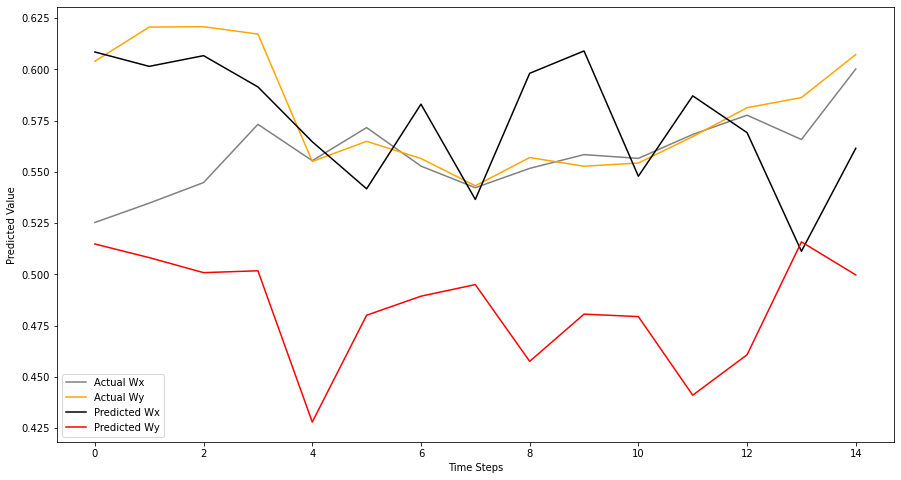

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_resunet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_resunet.load_weights('initial.h5')
history = model_resunet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.12870, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_64.h5
138/138 - 3s - loss: 0.0502 - mean_absolute_error: 0.1385 - val_loss: 0.1287 - val_mean_absolute_error: 0.3371
Epoch 2/200

Epoch 00002: val_loss improved from 0.12870 to 0.08834, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_64.h5
138/138 - 2s - loss: 0.0102 - mean_absolute_error: 0.0757 - val_loss: 0.0883 - val_mean_absolute_error: 0.2767
Epoch 3/200

Epoch 00003: val_loss improved from 0.08834 to 0.02306, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_64.h5
138/138 - 2s - loss: 0.0075 - mean_absolute_error: 0.0643 - val_loss: 0.0231 - val_mean_absolute_error: 0.1311
Epoch 4/200

Epoch 00004: val_loss improved from 0.02306 to 0.00450, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_64.h5
138/138 - 2s - loss: 0.0052 - mean_absolute_error: 0.05

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_resunet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_resunet.load_weights('initial.h5')
history = model_resunet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.20911, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_128.h5
69/69 - 2s - loss: 0.1093 - mean_absolute_error: 0.2254 - val_loss: 0.2091 - val_mean_absolute_error: 0.4398
Epoch 2/200

Epoch 00002: val_loss improved from 0.20911 to 0.13434, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_128.h5
69/69 - 1s - loss: 0.0122 - mean_absolute_error: 0.0832 - val_loss: 0.1343 - val_mean_absolute_error: 0.3447
Epoch 3/200

Epoch 00003: val_loss improved from 0.13434 to 0.09281, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_128.h5
69/69 - 1s - loss: 0.0102 - mean_absolute_error: 0.0752 - val_loss: 0.0928 - val_mean_absolute_error: 0.2799
Epoch 4/200

Epoch 00004: val_loss improved from 0.09281 to 0.06035, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_128.h5
69/69 - 1s - loss: 0.0082 - mean_absolute_error: 0.0672 -

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_resunet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_resunet.load_weights('initial.h5')
history = model_resunet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.28426, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_256.h5
35/35 - 2s - loss: 0.1713 - mean_absolute_error: 0.2936 - val_loss: 0.2843 - val_mean_absolute_error: 0.5184
Epoch 2/200

Epoch 00002: val_loss improved from 0.28426 to 0.20421, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_256.h5
35/35 - 1s - loss: 0.0167 - mean_absolute_error: 0.0984 - val_loss: 0.2042 - val_mean_absolute_error: 0.4344
Epoch 3/200

Epoch 00003: val_loss improved from 0.20421 to 0.14931, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_256.h5
35/35 - 1s - loss: 0.0116 - mean_absolute_error: 0.0805 - val_loss: 0.1493 - val_mean_absolute_error: 0.3659
Epoch 4/200

Epoch 00004: val_loss improved from 0.14931 to 0.10941, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_256.h5
35/35 - 1s - loss: 0.0101 - mean_absolute_error: 0.0745 -

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_resunet.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_resunet.load_weights('initial.h5')
history = model_resunet.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.33137, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_512.h5
18/18 - 1s - loss: 0.2668 - mean_absolute_error: 0.3788 - val_loss: 0.3314 - val_mean_absolute_error: 0.5619
Epoch 2/200

Epoch 00002: val_loss improved from 0.33137 to 0.28464, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_512.h5
18/18 - 1s - loss: 0.0520 - mean_absolute_error: 0.1783 - val_loss: 0.2846 - val_mean_absolute_error: 0.5187
Epoch 3/200

Epoch 00003: val_loss improved from 0.28464 to 0.24087, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_512.h5
18/18 - 1s - loss: 0.0164 - mean_absolute_error: 0.0985 - val_loss: 0.2409 - val_mean_absolute_error: 0.4746
Epoch 4/200

Epoch 00004: val_loss improved from 0.24087 to 0.20791, saving model to gdrive/My Drive/Data/DUS23L/DUS23L_Wxy_mm_norm_1D_ResU-Net__bs_512.h5
18/18 - 1s - loss: 0.0127 - mean_absolute_error: 0.0851 -

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_resunet_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_resunet_mm_norm_32['batch_size'] = 32
df_resunet_mm_norm_32 = df_resunet_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_resunet_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_resunet_mm_norm_64['batch_size'] = 64
df_resunet_mm_norm_64 = df_resunet_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_resunet_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_resunet_mm_norm_128['batch_size'] = 128
df_resunet_mm_norm_128 = df_resunet_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_resunet_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_resunet_mm_norm_256['batch_size'] = 256
df_resunet_mm_norm_256 = df_resunet_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_resunet_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_resunet_mm_norm_512['batch_size'] = 512
df_resunet_mm_norm_512 = df_resunet_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_resunet.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_resunet_mm_norm_'))
df_resunet_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_resunet_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.035826  ...                 0.229039          32
1        1  0.007489  ...                 0.091154          32
2        2  0.006053  ...                 0.063008          32
3        3  0.005387  ...                 0.051885          32
4        4  0.005016  ...                 0.048428          32
..     ...       ...  ...                      ...         ...
48      48  0.002811  ...                 0.055359         512
49      49  0.002737  ...                 0.054755         512
50      50  0.002769  ...                 0.048763         512
51      51  0.002847  ...                 0.048415         512
52      52  0.002629  ...                 0.053904         512

[348 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

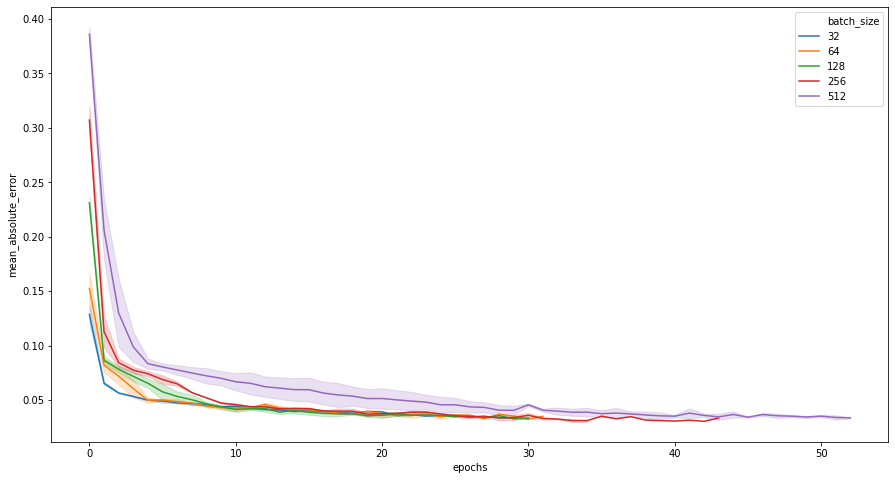

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_resunet_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

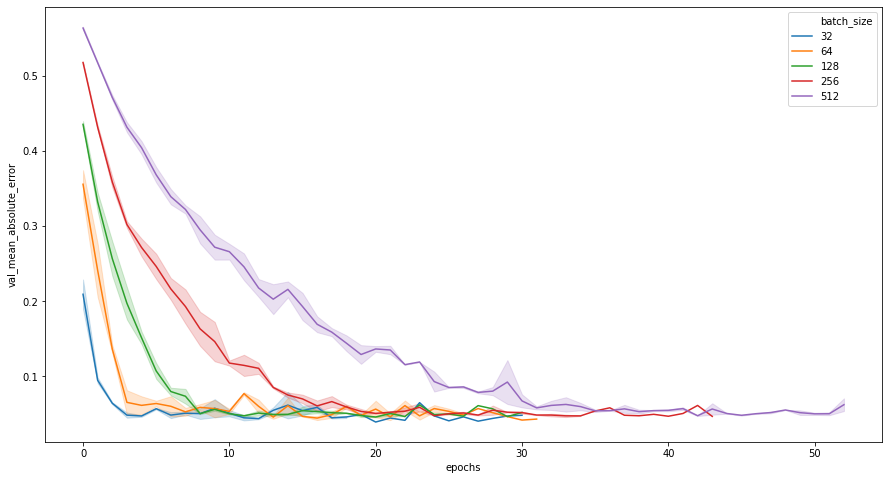

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_resunet_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

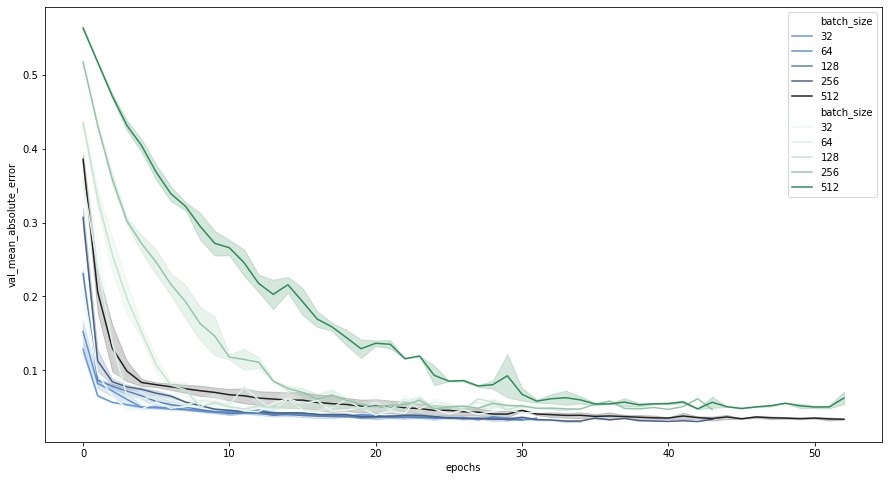

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_resunet_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_resunet_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_resunet.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.328170      0.169424
1   0.274215   0.675515      0.315007      0.192462
2   0.273068   0.684810      0.321726      0.207165
3   0.273068   0.684810      0.349589      0.190311
4   0.284058   0.699703      0.323165      0.188915

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.328170      0.169424  0.064739  0.494872
1    0.274215   0.675515      0.315007      0.192462  0.040792  0.483053
2    0.273068   0.684810      0.321726      0.207165  0.048658  0.477645
3    0.273068   0.684810      0.349589      0.190311  0.076521  0.494499
4    0.284058   0.699703      0.323165      0.188915  0.039107  0.510788
5    0.295614   0.713729      0.336665      0.181884  0.041050  0.531845
6    0.283502   0.708749      0.321164      0.217598  0.037661  0.491150
7    0.307688   0.726868      0.321596      0.205586  0.013908  0.521282
8    0.295399   0.722488      0.332422      0.223567  0.037022  0.498921
9    0.295399   0.722488      0.329133      0.231267  0.033734  0.491220
10   0.295803   0.744383      0.352555      0.235180  0.056752  0.509203
11   0.310281   0.769057      0.352956      0.227988  0.042674  0.541069
12   0.309789   0.764856      0.352320      0.245533  0.042531  0.519322
13   0.327213   0.795699      0.341221      0.245046  0.014008  0.550653
14   0.332048   0.815507      0.327200      0.256247  0.004848  0.559260

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.333659      0.214545   0.039601   0.511652
std     0.020118   0.044308      0.013075      0.026153   0.018824   0.025027
min     0.263431   0.664296      0.315007      0.169424   0.004848   0.477645
25%     0.278859   0.692256      0.322446      0.191386   0.035378   0.492860
50%     0.295399   0.722488      0.329133      0.217598   0.040792   0.509203
75%     0.308738   0.754619      0.345405      0.233224   0.045666   0.526564
max     0.332048   0.815507      0.352956      0.256247   0.076521   0.559260

In [ ]:
df_prediction = df_prediction.reset_index()

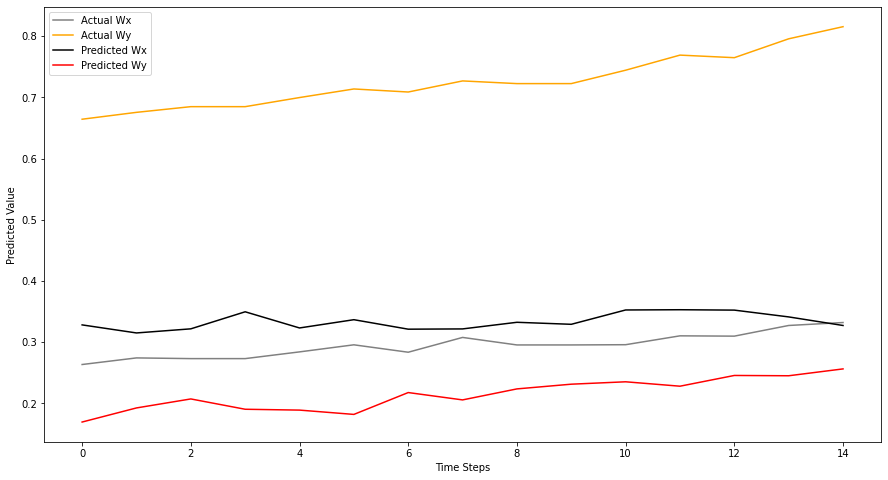

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# Bidirectional LSTM

## Model

In [ ]:
model_save_name = Runway + "BD_LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 
n_features=X_train_norm.shape[2]

In [ ]:
model_bdlstm = Sequential()
model_bdlstm.add(keras.layers.Bidirectional(LSTM(100, activation='relu'), input_shape=(n_steps_in, n_features)))
model_bdlstm.add(keras.layers.Dense(n_steps_out*number_features_predicted))
model_bdlstm.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_bdlstm.summary()
model_bdlstm.save_weights('initial.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200)               100000    
_________________________________________________________________
dense_8 (Dense)              (None, 30)                6030      
_________________________________________________________________
reshape_5 (Reshape)          (None, 15, 2)             0         
Total params: 106,030
Trainable params: 106,030
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')

history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01431, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2BD_LSTM__bs_32.h5
176/176 - 9s - loss: 0.0211 - mean_absolute_error: 0.0985 - val_loss: 0.0143 - val_mean_absolute_error: 0.0885
Epoch 2/200

Epoch 00002: val_loss improved from 0.01431 to 0.01124, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2BD_LSTM__bs_32.h5
176/176 - 8s - loss: 0.0076 - mean_absolute_error: 0.0618 - val_loss: 0.0112 - val_mean_absolute_error: 0.0767
Epoch 3/200

Epoch 00003: val_loss improved from 0.01124 to 0.01015, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2BD_LSTM__bs_32.h5
176/176 - 8s - loss: 0.0067 - mean_absolute_error: 0.0578 - val_loss: 0.0101 - val_mean_absolute_error: 0.0711
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.01015
176/176 - 8s - loss: 0.0065 - mean_absolute_error: 0.0571 - val_loss: 0.0112 - val_mean_absolute_error: 0.0748
Epoch 5/200

Epoch 00005: val_loss did not imp

In [ ]:
model_bdlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_bdlstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 5ms/step - loss: 0.0039 - mean_absolute_error: 0.0431


[0.003864794038236141, 0.04313629865646362]

In [ ]:
 model_bdlstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 5ms/step - loss: 0.0088 - mean_absolute_error: 0.0655


[0.008847147226333618, 0.065465547144413]

In [ ]:
model_bdlstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_error: 0.0519


[0.00593271991237998, 0.05192337557673454]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_bdlstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.550860      0.590560  0.025545  0.013429
1    0.534750   0.620656      0.543427      0.596939  0.008677  0.023717
2    0.544796   0.620843      0.533571      0.562926  0.011225  0.057916
3    0.573211   0.617240      0.514915      0.567311  0.058295  0.049929
4    0.555470   0.555096      0.523271      0.546929  0.032199  0.008167
5    0.571601   0.564905      0.536877      0.535316  0.034725  0.029588
6    0.552813   0.556533      0.529113      0.533026  0.023699  0.023507
7    0.542283   0.543212      0.513947      0.532636  0.028336  0.010576
8    0.551716   0.556998      0.532467      0.531138  0.019249  0.025859
9    0.558430   0.552767      0.514789      0.539588  0.043640  0.013179
10   0.556587   0.554328      0.512013      0.536916  0.044574  0.017412
11   0.568270   0.567223      0.508708      0.535998  0.059562  0.031225
12   0.577663   0.581305      0.492500      0.541948  0.085164  0.039357
13   0.565797   0.586258      0.491704      0.540853  0.074093  0.045404
14   0.600218   0.607245      0.479255      0.564252  0.120963  0.042992

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.518495      0.550423   0.044663   0.028817
std     0.018615   0.027907      0.020148      0.021230   0.030615   0.015398
min     0.525316   0.543212      0.479255      0.531138   0.008677   0.008167
25%     0.548256   0.555814      0.510361      0.535657   0.024622   0.015420
50%     0.556587   0.567223      0.514915      0.540853   0.034725   0.025859
75%     0.569936   0.605617      0.533019      0.563589   0.058928   0.041175
max     0.600218   0.620843      0.550860      0.596939   0.120963   0.057916

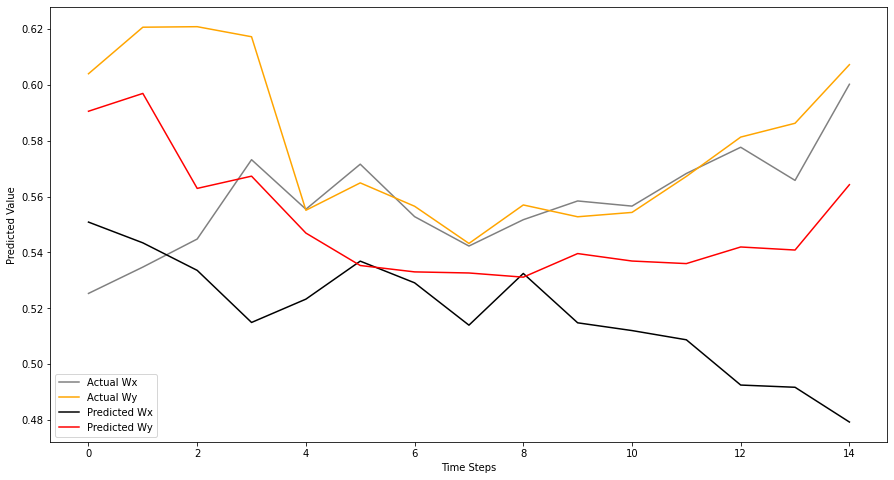

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00517, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_64.h5
138/138 - 6s - loss: 0.0281 - mean_absolute_error: 0.1106 - val_loss: 0.0052 - val_mean_absolute_error: 0.0504
Epoch 2/200

Epoch 00002: val_loss improved from 0.00517 to 0.00498, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_64.h5
138/138 - 6s - loss: 0.0056 - mean_absolute_error: 0.0517 - val_loss: 0.0050 - val_mean_absolute_error: 0.0483
Epoch 3/200

Epoch 00003: val_loss improved from 0.00498 to 0.00437, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_64.h5
138/138 - 6s - loss: 0.0049 - mean_absolute_error: 0.0468 - val_loss: 0.0044 - val_mean_absolute_error: 0.0468
Epoch 4/200

Epoch 00004: val_loss improved from 0.00437 to 0.00366, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_64.h5
138/138 - 6s - loss: 0.0047 - mean_absolute_error: 0.0460 - val_loss: 0.0037 - val_

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01194, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0483 - mean_absolute_error: 0.1577 - val_loss: 0.0119 - val_mean_absolute_error: 0.0798
Epoch 2/200

Epoch 00002: val_loss improved from 0.01194 to 0.00532, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_128.h5
69/69 - 3s - loss: 0.0084 - mean_absolute_error: 0.0665 - val_loss: 0.0053 - val_mean_absolute_error: 0.0524
Epoch 3/200

Epoch 00003: val_loss improved from 0.00532 to 0.00493, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_128.h5
69/69 - 3s - loss: 0.0058 - mean_absolute_error: 0.0523 - val_loss: 0.0049 - val_mean_absolute_error: 0.0486
Epoch 4/200

Epoch 00004: val_loss improved from 0.00493 to 0.00441, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_128.h5
69/69 - 3s - loss: 0.0051 - mean_absolute_error: 0.0483 - val_loss: 0.0044 - val_mean

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01908, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0796 - mean_absolute_error: 0.2121 - val_loss: 0.0191 - val_mean_absolute_error: 0.1042
Epoch 2/200

Epoch 00002: val_loss improved from 0.01908 to 0.01117, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0177 - mean_absolute_error: 0.1037 - val_loss: 0.0112 - val_mean_absolute_error: 0.0773
Epoch 3/200

Epoch 00003: val_loss improved from 0.01117 to 0.00540, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0087 - mean_absolute_error: 0.0684 - val_loss: 0.0054 - val_mean_absolute_error: 0.0538
Epoch 4/200

Epoch 00004: val_loss improved from 0.00540 to 0.00506, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0063 - mean_absolute_error: 0.0557 - val_loss: 0.0051 - val_mean

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.03832, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_512.h5
18/18 - 1s - loss: 0.1308 - mean_absolute_error: 0.2913 - val_loss: 0.0383 - val_mean_absolute_error: 0.1569
Epoch 2/200

Epoch 00002: val_loss improved from 0.03832 to 0.01900, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0282 - mean_absolute_error: 0.1334 - val_loss: 0.0190 - val_mean_absolute_error: 0.1039
Epoch 3/200

Epoch 00003: val_loss improved from 0.01900 to 0.01474, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0195 - mean_absolute_error: 0.1096 - val_loss: 0.0147 - val_mean_absolute_error: 0.0900
Epoch 4/200

Epoch 00004: val_loss improved from 0.01474 to 0.01085, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_BD_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0145 - mean_absolute_error: 0.0931 - val_loss: 0.0108 - val_mean

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_bdlstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_bdlstm_mm_norm_32['batch_size'] = 32
df_bdlstm_mm_norm_32 = df_bdlstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_bdlstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_bdlstm_mm_norm_64['batch_size'] = 64
df_bdlstm_mm_norm_64 = df_bdlstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_bdlstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_bdlstm_mm_norm_128['batch_size'] = 128
df_bdlstm_mm_norm_128 = df_bdlstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_bdlstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_bdlstm_mm_norm_256['batch_size'] = 256
df_bdlstm_mm_norm_256 = df_bdlstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_bdlstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_bdlstm_mm_norm_512['batch_size'] = 512
df_bdlstm_mm_norm_512 = df_bdlstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_bdlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_bdlstm_mm_norm_'))
df_bdlstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_bdlstm_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.017962  ...                 0.052290          32
1        1  0.005153  ...                 0.047714          32
2        2  0.004551  ...                 0.044788          32
3        3  0.004305  ...                 0.040563          32
4        4  0.004108  ...                 0.041369          32
..     ...       ...  ...                      ...         ...
51      51  0.003465  ...                 0.041367         512
52      52  0.003494  ...                 0.040248         512
53      53  0.003404  ...                 0.039595         512
54      54  0.003419  ...                 0.040918         512
55      55  0.003442  ...                 0.041953         512

[189 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

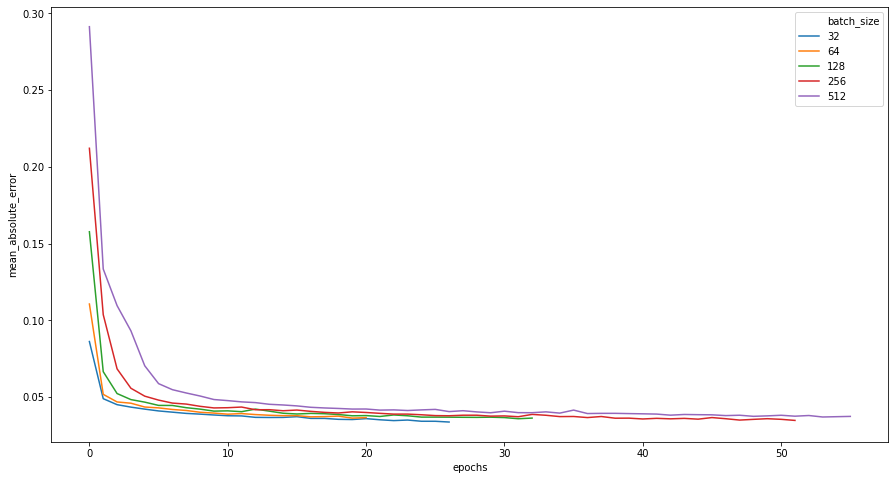

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_bdlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

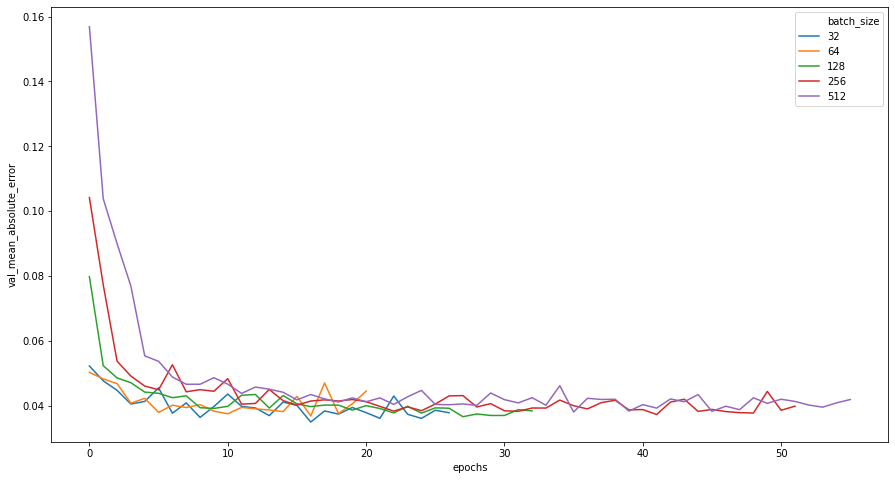

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_bdlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

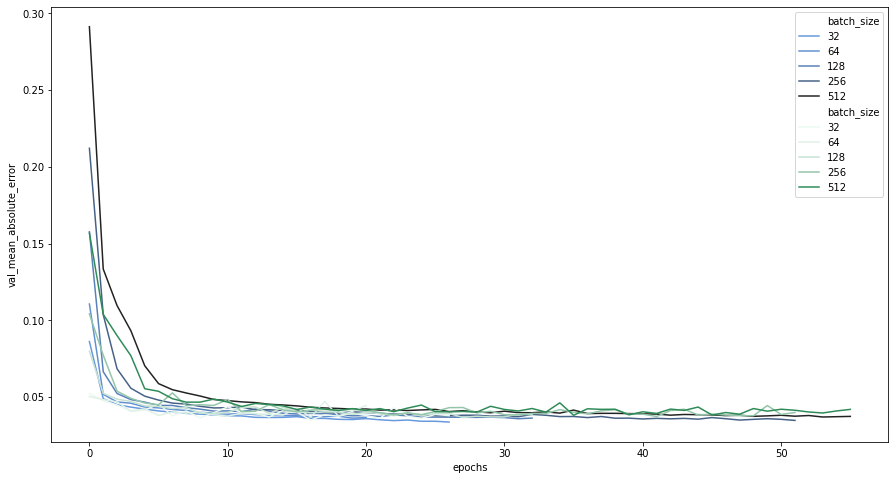

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_bdlstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_bdlstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
model_bdlstm = load_model(path + '_bs_' + '32' +'.h5')

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_bdlstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.403651      0.112760
1   0.274215   0.675515      0.391447      0.093040
2   0.273068   0.684810      0.384891      0.155806
3   0.273068   0.684810      0.384905      0.147795
4   0.284058   0.699703      0.401875      0.188498

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.403651      0.112760  0.140220  0.551536
1    0.274215   0.675515      0.391447      0.093040  0.117232  0.582475
2    0.273068   0.684810      0.384891      0.155806  0.111823  0.529004
3    0.273068   0.684810      0.384905      0.147795  0.111837  0.537015
4    0.284058   0.699703      0.401875      0.188498  0.117817  0.511205
5    0.295614   0.713729      0.414222      0.185204  0.118607  0.528525
6    0.283502   0.708749      0.402418      0.183610  0.118916  0.525138
7    0.307688   0.726868      0.388783      0.164062  0.081095  0.562806
8    0.295399   0.722488      0.388044      0.197306  0.092645  0.525181
9    0.295399   0.722488      0.392802      0.191339  0.097403  0.531148
10   0.295803   0.744383      0.407418      0.203616  0.111616  0.540767
11   0.310281   0.769057      0.415339      0.171824  0.105057  0.597232
12   0.309789   0.764856      0.410821      0.217845  0.101032  0.547010
13   0.327213   0.795699      0.348908      0.251318  0.021695  0.544382
14   0.332048   0.815507      0.394761      0.220585  0.062713  0.594922

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.395352      0.178974   0.100647   0.547223
std     0.020118   0.044308      0.016466      0.040773   0.028425   0.026247
min     0.263431   0.664296      0.348908      0.093040   0.021695   0.511205
25%     0.278859   0.692256      0.388414      0.159934   0.095024   0.528765
50%     0.295399   0.722488      0.394761      0.185204   0.111616   0.540767
75%     0.308738   0.754619      0.405535      0.200461   0.117524   0.557171
max     0.332048   0.815507      0.415339      0.251318   0.140220   0.597232

In [ ]:
df_prediction = df_prediction.reset_index()

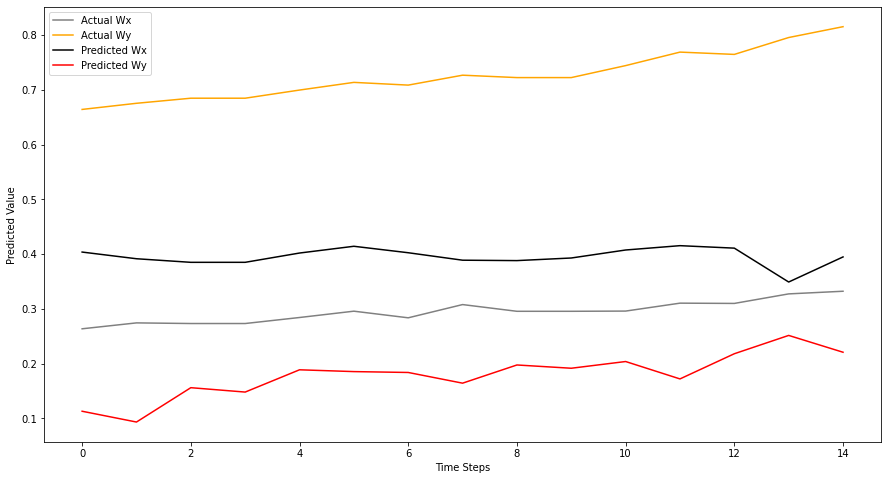

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# SBU-LSTM

## Model

In [ ]:
model_save_name = Runway + "SBU_LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
model_sbulstm = Sequential()
model_sbulstm.add(keras.layers.Bidirectional(LSTM(100, return_sequences = True, activation='relu'), input_shape=(n_steps_in, n_features)))
model_sbulstm.add(keras.layers.LSTM(100, activation='relu'))
model_sbulstm.add(keras.layers.Dense(n_steps_out*number_features_predicted))
model_sbulstm.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_sbulstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_sbulstm.summary()
model_sbulstm.save_weights('initial.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 15, 200)           100000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_9 (Dense)              (None, 30)                3030      
_________________________________________________________________
reshape_6 (Reshape)          (None, 15, 2)             0         
Total params: 223,430
Trainable params: 223,430
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_sbulstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_sbulstm.load_weights('initial.h5')

history = model_sbulstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01158, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2SBU_LSTM__bs_32.h5
176/176 - 12s - loss: 0.0203 - mean_absolute_error: 0.0959 - val_loss: 0.0116 - val_mean_absolute_error: 0.0744
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.01158
176/176 - 11s - loss: 0.0075 - mean_absolute_error: 0.0616 - val_loss: 0.0135 - val_mean_absolute_error: 0.0847
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.01158
176/176 - 11s - loss: 0.0069 - mean_absolute_error: 0.0594 - val_loss: 0.0119 - val_mean_absolute_error: 0.0764
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.01158
176/176 - 11s - loss: 0.0062 - mean_absolute_error: 0.0548 - val_loss: 0.0131 - val_mean_absolute_error: 0.0795
Epoch 5/200

Epoch 00005: val_loss improved from 0.01158 to 0.00987, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2SBU_LSTM__bs_32.h5
176/176 - 11s - loss: 0.0060 - mean_absolute_error: 0.0535 - v

In [ ]:
model_sbulstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_sbulstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0454


[0.004192521795630455, 0.04536036029458046]

In [ ]:
 model_sbulstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 7ms/step - loss: 0.0089 - mean_absolute_error: 0.0653


[0.008862758055329323, 0.06531621515750885]

In [ ]:
model_sbulstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0486


[0.005300129298120737, 0.04856957867741585]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_sbulstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.527068      0.582736  0.001752  0.021252
1    0.534750   0.620656      0.538849      0.589736  0.004099  0.030920
2    0.544796   0.620843      0.544906      0.567469  0.000109  0.053373
3    0.573211   0.617240      0.560864      0.555274  0.012347  0.061966
4    0.555470   0.555096      0.552450      0.551102  0.003020  0.003994
5    0.571601   0.564905      0.551584      0.532348  0.020018  0.032556
6    0.552813   0.556533      0.535683      0.519890  0.017130  0.036643
7    0.542283   0.543212      0.518726      0.528557  0.023557  0.014655
8    0.551716   0.556998      0.518816      0.516284  0.032899  0.040714
9    0.558430   0.552767      0.505563      0.524495  0.052866  0.028272
10   0.556587   0.554328      0.510957      0.498191  0.045629  0.056137
11   0.568270   0.567223      0.504535      0.509056  0.063734  0.058167
12   0.577663   0.581305      0.499186      0.497532  0.078477  0.083773
13   0.565797   0.586258      0.485187      0.498775  0.080610  0.087482
14   0.600218   0.607245      0.483690      0.500416  0.116527  0.106829

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.522538      0.531457   0.036852   0.047782
std     0.018615   0.027907      0.024482      0.031040   0.035169   0.028732
min     0.525316   0.543212      0.483690      0.497532   0.000109   0.003994
25%     0.548256   0.555814      0.505049      0.504736   0.008223   0.029596
50%     0.556587   0.567223      0.518816      0.524495   0.023557   0.040714
75%     0.569936   0.605617      0.541878      0.553188   0.058300   0.060067
max     0.600218   0.620843      0.560864      0.589736   0.116527   0.106829

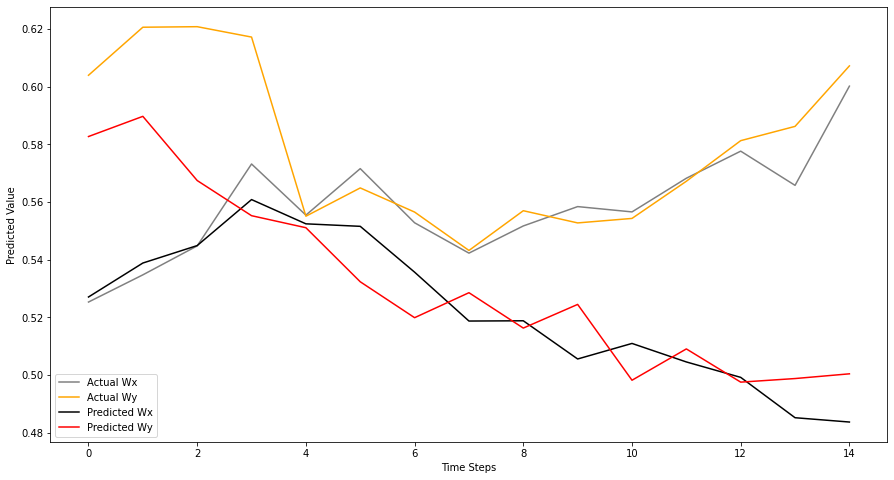

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_sbulstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_sbulstm.load_weights('initial.h5')
history = model_sbulstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00634, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_64.h5
138/138 - 9s - loss: 0.0282 - mean_absolute_error: 0.1109 - val_loss: 0.0063 - val_mean_absolute_error: 0.0608
Epoch 2/200

Epoch 00002: val_loss improved from 0.00634 to 0.00419, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_64.h5
138/138 - 9s - loss: 0.0055 - mean_absolute_error: 0.0503 - val_loss: 0.0042 - val_mean_absolute_error: 0.0453
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00419
138/138 - 9s - loss: 0.0048 - mean_absolute_error: 0.0465 - val_loss: 0.0044 - val_mean_absolute_error: 0.0484
Epoch 4/200

Epoch 00004: val_loss improved from 0.00419 to 0.00347, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_64.h5
138/138 - 9s - loss: 0.0044 - mean_absolute_error: 0.0433 - val_loss: 0.0035 - val_mean_absolute_error: 0.0398
Epoch 5/200

Epoch 00005: val_loss did not improve f

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_sbulstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_sbulstm.load_weights('initial.h5')
history = model_sbulstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00947, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_128.h5
69/69 - 5s - loss: 0.0474 - mean_absolute_error: 0.1520 - val_loss: 0.0095 - val_mean_absolute_error: 0.0731
Epoch 2/200

Epoch 00002: val_loss improved from 0.00947 to 0.00507, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_128.h5
69/69 - 5s - loss: 0.0076 - mean_absolute_error: 0.0624 - val_loss: 0.0051 - val_mean_absolute_error: 0.0504
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00507
69/69 - 4s - loss: 0.0056 - mean_absolute_error: 0.0510 - val_loss: 0.0053 - val_mean_absolute_error: 0.0514
Epoch 4/200

Epoch 00004: val_loss improved from 0.00507 to 0.00483, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0050 - mean_absolute_error: 0.0474 - val_loss: 0.0048 - val_mean_absolute_error: 0.0475
Epoch 5/200

Epoch 00005: val_loss improved from 0.00483 

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_sbulstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_sbulstm.load_weights('initial.h5')
history = model_sbulstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01686, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_256.h5
35/35 - 3s - loss: 0.0791 - mean_absolute_error: 0.2084 - val_loss: 0.0169 - val_mean_absolute_error: 0.0978
Epoch 2/200

Epoch 00002: val_loss improved from 0.01686 to 0.00851, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0146 - mean_absolute_error: 0.0932 - val_loss: 0.0085 - val_mean_absolute_error: 0.0691
Epoch 3/200

Epoch 00003: val_loss improved from 0.00851 to 0.00521, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0078 - mean_absolute_error: 0.0638 - val_loss: 0.0052 - val_mean_absolute_error: 0.0499
Epoch 4/200

Epoch 00004: val_loss improved from 0.00521 to 0.00500, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0058 - mean_absolute_error: 0.0520 - val_loss: 0.0050 - val_

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_sbulstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_sbulstm.load_weights('initial.h5')
history = model_sbulstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.02908, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_512.h5
18/18 - 2s - loss: 0.1337 - mean_absolute_error: 0.2967 - val_loss: 0.0291 - val_mean_absolute_error: 0.1334
Epoch 2/200

Epoch 00002: val_loss improved from 0.02908 to 0.01482, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0223 - mean_absolute_error: 0.1162 - val_loss: 0.0148 - val_mean_absolute_error: 0.0923
Epoch 3/200

Epoch 00003: val_loss improved from 0.01482 to 0.01101, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0156 - mean_absolute_error: 0.0968 - val_loss: 0.0110 - val_mean_absolute_error: 0.0782
Epoch 4/200

Epoch 00004: val_loss improved from 0.01101 to 0.00707, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_SBU_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0111 - mean_absolute_error: 0.0799 - val_loss: 0.0071 - val_

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_sbulstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_sbulstm_mm_norm_32['batch_size'] = 32
df_sbulstm_mm_norm_32 = df_sbulstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_sbulstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_sbulstm_mm_norm_64['batch_size'] = 64
df_sbulstm_mm_norm_64 = df_sbulstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_sbulstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_sbulstm_mm_norm_128['batch_size'] = 128
df_sbulstm_mm_norm_128 = df_sbulstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_sbulstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_sbulstm_mm_norm_256['batch_size'] = 256
df_sbulstm_mm_norm_256 = df_sbulstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_sbulstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_sbulstm_mm_norm_512['batch_size'] = 512
df_sbulstm_mm_norm_512 = df_sbulstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_sbulstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_bdlstm_mm_norm_'))
df_sbulstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_bdlstm_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.017962  ...                 0.052290          32
1        1  0.005153  ...                 0.047714          32
2        2  0.004551  ...                 0.044788          32
3        3  0.004305  ...                 0.040563          32
4        4  0.004108  ...                 0.041369          32
..     ...       ...  ...                      ...         ...
51      51  0.003465  ...                 0.041367         512
52      52  0.003494  ...                 0.040248         512
53      53  0.003404  ...                 0.039595         512
54      54  0.003419  ...                 0.040918         512
55      55  0.003442  ...                 0.041953         512

[189 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

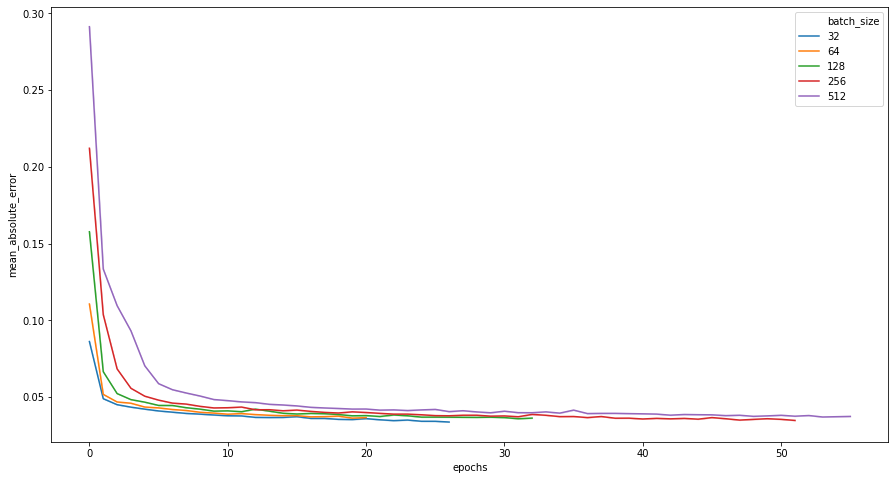

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_sbulstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

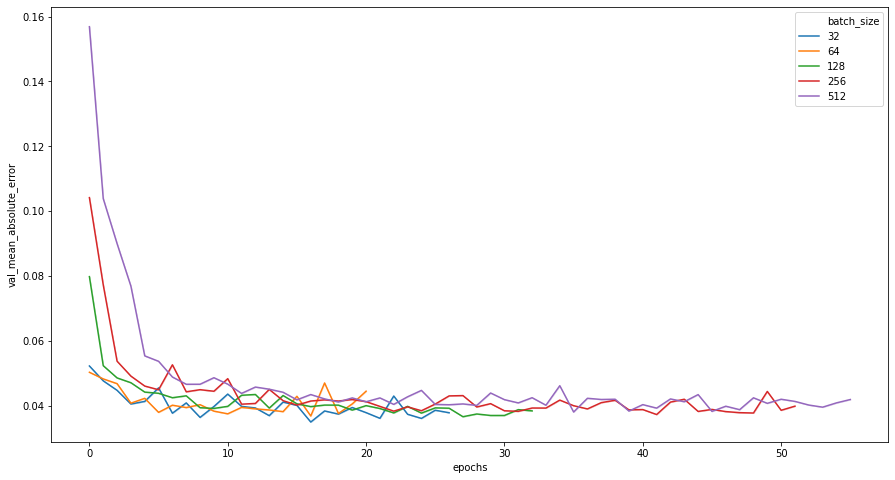

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_sbulstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

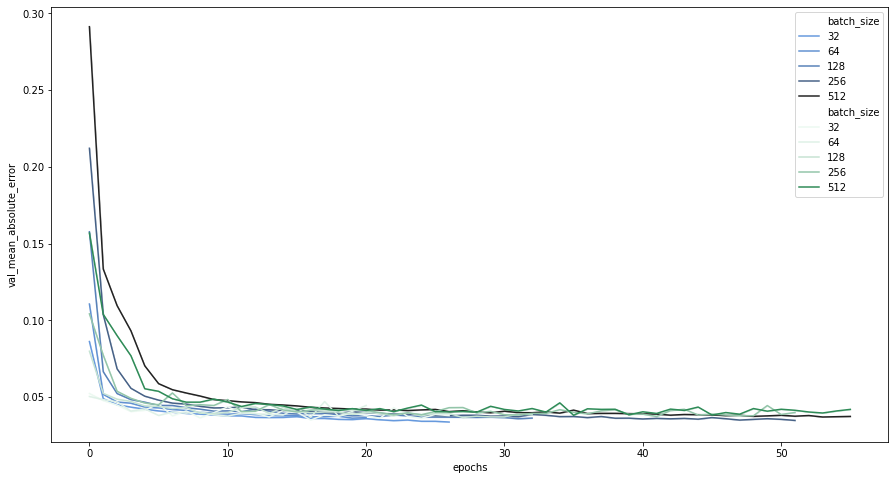

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_sbulstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_sbulstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
model_sbulstm = load_model(path + '_bs_' + '32' +'.h5')

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 8

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_sbulstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715],
       [0.32808265, 0.79968396],
       [0.3299683 , 0.80761988],
       [0.30950456, 0.82628759],
       [0.34610631, 0.81976796],
       [0.33808963, 0.83498143],
       [0.36263166, 0.83053631],
       [0.36494748, 0.79512551],
       [0.39950936, 0.85415475]])

In [ ]:
y_actual[0]

array([0.29539937, 0.72248754])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.295399   0.722488      0.351011      0.182134
1   0.295399   0.722488      0.342308      0.199833
2   0.295803   0.744383      0.337794      0.189829
3   0.310281   0.769057      0.358523      0.224894
4   0.309789   0.764856      0.353693      0.211352

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.295399   0.722488      0.351011      0.182134  0.055611  0.540353
1    0.295399   0.722488      0.342308      0.199833  0.046908  0.522654
2    0.295803   0.744383      0.337794      0.189829  0.041991  0.554554
3    0.310281   0.769057      0.358523      0.224894  0.048241  0.544162
4    0.309789   0.764856      0.353693      0.211352  0.043904  0.553503
5    0.327213   0.795699      0.352656      0.203831  0.025443  0.591868
6    0.332048   0.815507      0.357549      0.226094  0.025501  0.589413
7    0.328083   0.799684      0.350625      0.236514  0.022542  0.563170
8    0.329968   0.807620      0.351502      0.234258  0.021534  0.573362
9    0.309505   0.826288      0.361219      0.251179  0.051714  0.575109
10   0.346106   0.819768      0.357553      0.262109  0.011447  0.557659
11   0.338090   0.834981      0.373552      0.288477  0.035462  0.546505
12   0.362632   0.830536      0.357819      0.286619  0.004813  0.543917
13   0.364947   0.795126      0.358957      0.287406  0.005990  0.507720
14   0.399509   0.854155      0.362743      0.299752  0.036767  0.554402

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.329652   0.793509      0.355167      0.238952   0.031858   0.554557
std     0.029565   0.040692      0.008464      0.038742   0.016541   0.022626
min     0.295399   0.722488      0.337794      0.182134   0.004813   0.507720
25%     0.309647   0.766956      0.351256      0.207592   0.022038   0.544040
50%     0.328083   0.799684      0.357549      0.234258   0.035462   0.554402
75%     0.342098   0.823028      0.358740      0.274364   0.045406   0.568266
max     0.399509   0.854155      0.373552      0.299752   0.055611   0.591868

In [ ]:
df_prediction = df_prediction.reset_index()

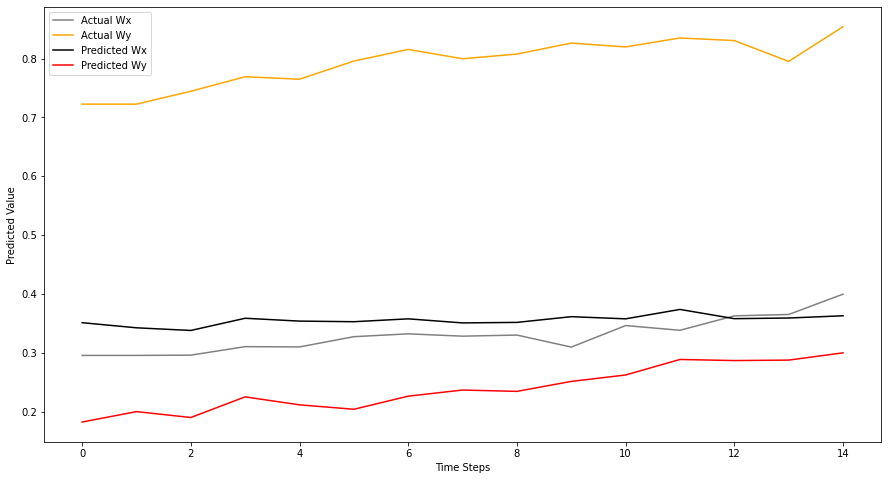

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# Encoder-Decoder LSTM

## Model

In [ ]:
model_save_name = Runway + "ED_LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
model_edlstm = Sequential()
model_edlstm.add(keras.layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model_edlstm.add(keras.layers.RepeatVector(n_steps_out*number_features_predicted))
model_edlstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_edlstm.add(keras.layers.TimeDistributed(Dense(1)))
model_edlstm.add(keras.layers.Reshape([n_steps_out,2]))
model_edlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_edlstm.summary()
model_edlstm.save_weights('initial.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               50000     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             101       
_________________________________________________________________
reshape_7 (Reshape)          (None, 15, 2)             0         
Total params: 130,501
Trainable params: 130,501
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_edlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_edlstm.load_weights('initial.h5')

history = model_edlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.05498, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2ED_LSTM__bs_32.h5
176/176 - 12s - loss: 0.0240 - mean_absolute_error: 0.1145 - val_loss: 0.0550 - val_mean_absolute_error: 0.1845
Epoch 2/200

Epoch 00002: val_loss improved from 0.05498 to 0.05336, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2ED_LSTM__bs_32.h5
176/176 - 12s - loss: 0.0153 - mean_absolute_error: 0.0936 - val_loss: 0.0534 - val_mean_absolute_error: 0.1792
Epoch 3/200

Epoch 00003: val_loss improved from 0.05336 to 0.01375, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2ED_LSTM__bs_32.h5
176/176 - 12s - loss: 0.0116 - mean_absolute_error: 0.0799 - val_loss: 0.0137 - val_mean_absolute_error: 0.0837
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.01375
176/176 - 11s - loss: 0.0079 - mean_absolute_error: 0.0643 - val_loss: 0.0191 - val_mean_absolute_error: 0.0976
Epoch 5/200

Epoch 00005: val_loss improve

In [ ]:
model_edlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_edlstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0537


[0.0059451935812830925, 0.05369769409298897]

In [ ]:
 model_edlstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_absolute_error: 0.0633


[0.008390911854803562, 0.06333383172750473]

In [ ]:
model_edlstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0520


[0.005489317234605551, 0.05203631892800331]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_edlstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.575213      0.552945  0.049897  0.051043
1    0.534750   0.620656      0.584843      0.555709  0.050093  0.064947
2    0.544796   0.620843      0.572405      0.546245  0.027609  0.074598
3    0.573211   0.617240      0.567342      0.537165  0.005869  0.080075
4    0.555470   0.555096      0.560828      0.524606  0.005358  0.030489
5    0.571601   0.564905      0.552194      0.509628  0.019408  0.055277
6    0.552813   0.556533      0.543088      0.493914  0.009725  0.062619
7    0.542283   0.543212      0.535466      0.478414  0.006817  0.064798
8    0.551716   0.556998      0.529895      0.466966  0.021821  0.090032
9    0.558430   0.552767      0.522755      0.461581  0.035675  0.091185
10   0.556587   0.554328      0.515366      0.460516  0.041221  0.093811
11   0.568270   0.567223      0.507339      0.462138  0.060930  0.105085
12   0.577663   0.581305      0.498743      0.465569  0.078920  0.115736
13   0.565797   0.586258      0.490984      0.468444  0.074812  0.117813
14   0.600218   0.607245      0.485126      0.470018  0.115092  0.137227

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.536106      0.496924   0.040216   0.082316
std     0.018615   0.027907      0.032318      0.036961   0.031975   0.028831
min     0.525316   0.543212      0.485126      0.460516   0.005358   0.030489
25%     0.548256   0.555814      0.511353      0.466267   0.014566   0.063708
50%     0.556587   0.567223      0.535466      0.478414   0.035675   0.080075
75%     0.569936   0.605617      0.564085      0.530886   0.055512   0.099448
max     0.600218   0.620843      0.584843      0.555709   0.115092   0.137227

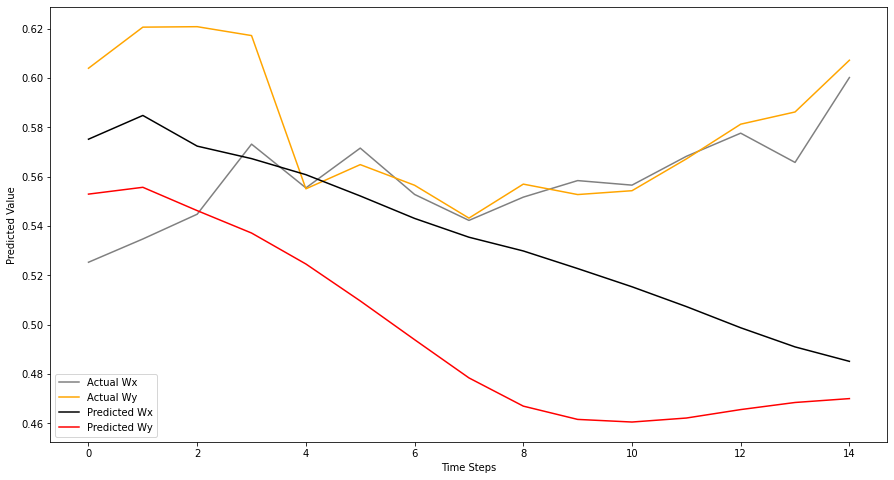

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_edlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_edlstm.load_weights('initial.h5')
history = model_edlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01344, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_64.h5
138/138 - 9s - loss: 0.0300 - mean_absolute_error: 0.1286 - val_loss: 0.0134 - val_mean_absolute_error: 0.0887
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.01344
138/138 - 9s - loss: 0.0147 - mean_absolute_error: 0.0945 - val_loss: 0.0141 - val_mean_absolute_error: 0.0909
Epoch 3/200

Epoch 00003: val_loss improved from 0.01344 to 0.01200, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_64.h5
138/138 - 9s - loss: 0.0143 - mean_absolute_error: 0.0934 - val_loss: 0.0120 - val_mean_absolute_error: 0.0838
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.01200
138/138 - 9s - loss: 0.0140 - mean_absolute_error: 0.0920 - val_loss: 0.0121 - val_mean_absolute_error: 0.0835
Epoch 5/200

Epoch 00005: val_loss improved from 0.01200 to 0.00883, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_edlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_edlstm.load_weights('initial.h5')
history = model_edlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01916, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_128.h5
69/69 - 5s - loss: 0.0431 - mean_absolute_error: 0.1560 - val_loss: 0.0192 - val_mean_absolute_error: 0.1029
Epoch 2/200

Epoch 00002: val_loss improved from 0.01916 to 0.01386, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0172 - mean_absolute_error: 0.1023 - val_loss: 0.0139 - val_mean_absolute_error: 0.0900
Epoch 3/200

Epoch 00003: val_loss improved from 0.01386 to 0.01270, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0147 - mean_absolute_error: 0.0948 - val_loss: 0.0127 - val_mean_absolute_error: 0.0860
Epoch 4/200

Epoch 00004: val_loss improved from 0.01270 to 0.01232, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0141 - mean_absolute_error: 0.0926 - val_loss: 0.0123 - val_mean

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_edlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_edlstm.load_weights('initial.h5')
history = model_edlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.03038, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_256.h5
35/35 - 3s - loss: 0.0599 - mean_absolute_error: 0.1869 - val_loss: 0.0304 - val_mean_absolute_error: 0.1244
Epoch 2/200

Epoch 00002: val_loss improved from 0.03038 to 0.01872, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0256 - mean_absolute_error: 0.1232 - val_loss: 0.0187 - val_mean_absolute_error: 0.1026
Epoch 3/200

Epoch 00003: val_loss improved from 0.01872 to 0.01429, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0182 - mean_absolute_error: 0.1046 - val_loss: 0.0143 - val_mean_absolute_error: 0.0906
Epoch 4/200

Epoch 00004: val_loss improved from 0.01429 to 0.01300, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0156 - mean_absolute_error: 0.0977 - val_loss: 0.0130 - val_mean

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_edlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_edlstm.load_weights('initial.h5')
history = model_edlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.03605, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0857 - mean_absolute_error: 0.2317 - val_loss: 0.0360 - val_mean_absolute_error: 0.1376
Epoch 2/200

Epoch 00002: val_loss improved from 0.03605 to 0.02779, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0325 - mean_absolute_error: 0.1396 - val_loss: 0.0278 - val_mean_absolute_error: 0.1195
Epoch 3/200

Epoch 00003: val_loss improved from 0.02779 to 0.02175, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0274 - mean_absolute_error: 0.1270 - val_loss: 0.0218 - val_mean_absolute_error: 0.1088
Epoch 4/200

Epoch 00004: val_loss improved from 0.02175 to 0.01868, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0224 - mean_absolute_error: 0.1152 - val_loss: 0.0187 - val_mean

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_edlstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_edlstm_mm_norm_32['batch_size'] = 32
df_edlstm_mm_norm_32 = df_edlstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_edlstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_edlstm_mm_norm_64['batch_size'] = 64
df_edlstm_mm_norm_64 = df_edlstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_edlstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_edlstm_mm_norm_128['batch_size'] = 128
df_edlstm_mm_norm_128 = df_edlstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_edlstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_edlstm_mm_norm_256['batch_size'] = 256
df_edlstm_mm_norm_256 = df_edlstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_edlstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_edlstm_mm_norm_512['batch_size'] = 512
df_edlstm_mm_norm_512 = df_edlstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_edlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_edlstm_mm_norm_'))
df_edlstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_edlstm_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.023231  ...                 0.089764          32
1        1  0.014385  ...                 0.085054          32
2        2  0.013910  ...                 0.082980          32
3        3  0.013785  ...                 0.082979          32
4        4  0.010278  ...                 0.066513          32
..     ...       ...  ...                      ...         ...
70      70  0.003412  ...                 0.037588         512
71      71  0.003474  ...                 0.039233         512
72      72  0.003420  ...                 0.037977         512
73      73  0.003443  ...                 0.037386         512
74      74  0.003398  ...                 0.040103         512

[223 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

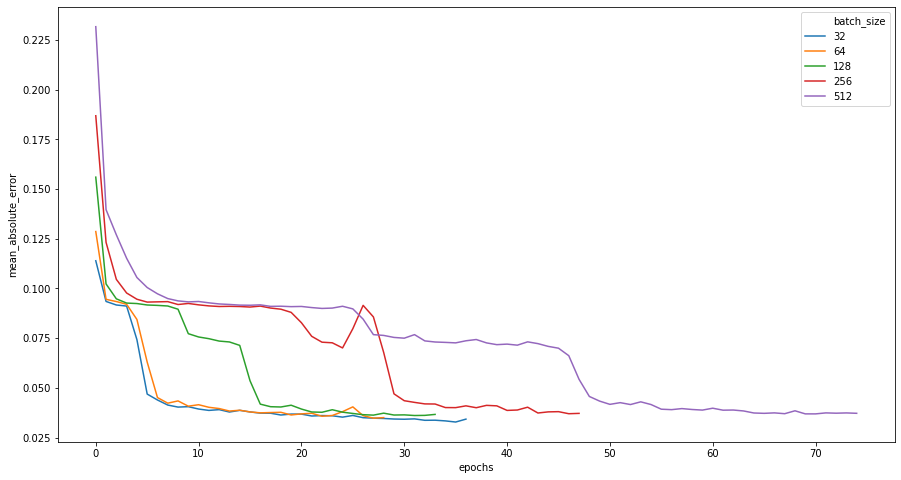

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_edlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

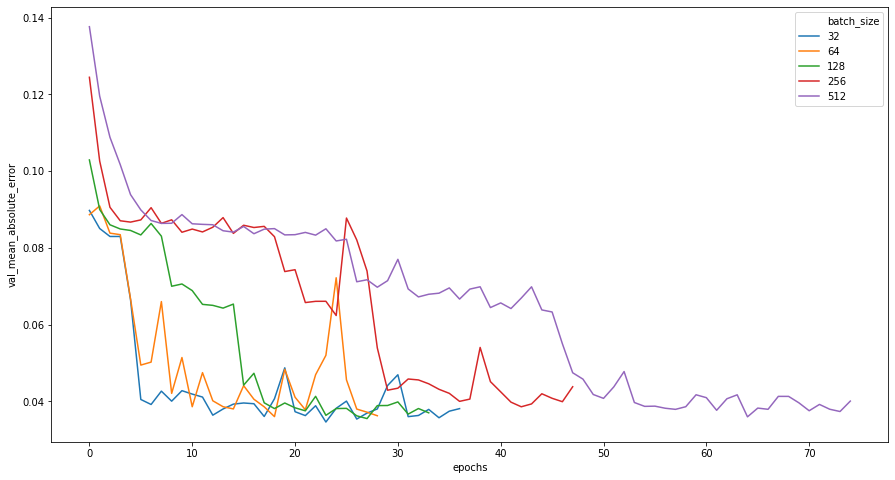

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_edlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

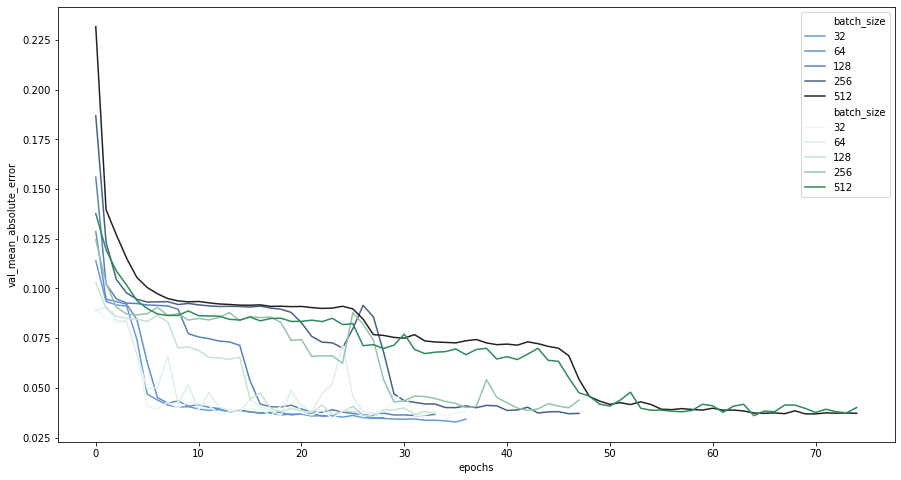

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_edlstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_edlstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_edlstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.341031      0.147805
1   0.274215   0.675515      0.310165      0.134669
2   0.273068   0.684810      0.323267      0.119999
3   0.273068   0.684810      0.332673      0.108725
4   0.284058   0.699703      0.335485      0.105399

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.341031      0.147805  0.077600  0.516492
1    0.274215   0.675515      0.310165      0.134669  0.035950  0.540846
2    0.273068   0.684810      0.323267      0.119999  0.050199  0.564811
3    0.273068   0.684810      0.332673      0.108725  0.059605  0.576085
4    0.284058   0.699703      0.335485      0.105399  0.051426  0.594304
5    0.295614   0.713729      0.336116      0.106991  0.040501  0.606738
6    0.283502   0.708749      0.336662      0.111381  0.053160  0.597368
7    0.307688   0.726868      0.337191      0.117421  0.029504  0.609447
8    0.295399   0.722488      0.337325      0.124318  0.041925  0.598169
9    0.295399   0.722488      0.336852      0.131564  0.041453  0.590923
10   0.295803   0.744383      0.335783      0.138854  0.039981  0.605529
11   0.310281   0.769057      0.334229      0.146008  0.023948  0.623049
12   0.309789   0.764856      0.332322      0.152922  0.022533  0.611934
13   0.327213   0.795699      0.330175      0.159540  0.002962  0.636160
14   0.332048   0.815507      0.327881      0.165833  0.004167  0.649674

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.332477      0.131429   0.038328   0.594769
std     0.020118   0.044308      0.007564      0.019914   0.019848   0.034446
min     0.263431   0.664296      0.310165      0.105399   0.002962   0.516492
25%     0.278859   0.692256      0.331249      0.114401   0.026726   0.583504
50%     0.295399   0.722488      0.335485      0.131564   0.040501   0.598169
75%     0.308738   0.754619      0.336757      0.146906   0.050813   0.610690
max     0.332048   0.815507      0.341031      0.165833   0.077600   0.649674

In [ ]:
df_prediction = df_prediction.reset_index()

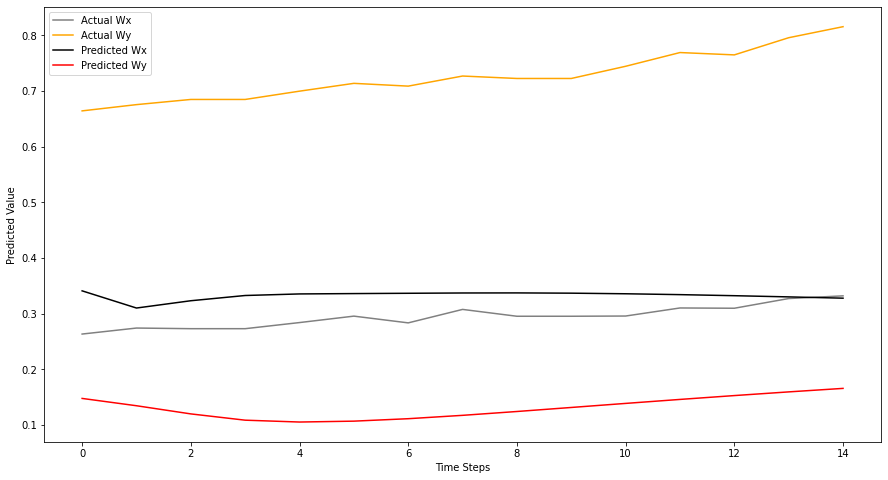

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

#  CNN-Encoder-Decoder LSTM

## Model

In [ ]:
model_save_name = Runway + "CNN_ED_LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 
n_steps_in = 15
n_steps_out = 15
f = [16, 32, 64, 128, 256, 512]

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
model_cnnlstm = Sequential()
model_cnnlstm.add(keras.layers.Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_cnnlstm.add(keras.layers.MaxPooling1D())
model_cnnlstm.add(keras.layers.LSTM(100, activation='relu'))
model_cnnlstm.add(keras.layers.RepeatVector(n_steps_out*number_features_predicted))
model_cnnlstm.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
model_cnnlstm.add(keras.layers.TimeDistributed(Dense(1)))
model_cnnlstm.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_cnnlstm.summary()
model_cnnlstm.save_weights('initial.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 14, 64)            3136      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               66000     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 100)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 100)           80400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             101       
_________________________________________________________________
reshape_8 (Reshape)          (None, 15, 2)            

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')

history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.05527, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2CNN_ED_LSTM__bs_32.h5
176/176 - 11s - loss: 0.0248 - mean_absolute_error: 0.1166 - val_loss: 0.0553 - val_mean_absolute_error: 0.1848
Epoch 2/200

Epoch 00002: val_loss improved from 0.05527 to 0.01668, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2CNN_ED_LSTM__bs_32.h5
176/176 - 11s - loss: 0.0142 - mean_absolute_error: 0.0897 - val_loss: 0.0167 - val_mean_absolute_error: 0.0930
Epoch 3/200

Epoch 00003: val_loss improved from 0.01668 to 0.01429, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2CNN_ED_LSTM__bs_32.h5
176/176 - 10s - loss: 0.0087 - mean_absolute_error: 0.0683 - val_loss: 0.0143 - val_mean_absolute_error: 0.0858
Epoch 4/200

Epoch 00004: val_loss improved from 0.01429 to 0.01002, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2CNN_ED_LSTM__bs_32.h5
176/176 - 10s - loss: 0.0078 - mean_absolute_error: 

In [ ]:
model_cnnlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_cnnlstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0582


[0.006817420944571495, 0.05818914249539375]

In [ ]:
 model_cnnlstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0684


[0.009328920394182205, 0.06840955466032028]

In [ ]:
model_cnnlstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_error: 0.0565


[0.006092552095651627, 0.0564957931637764]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_cnnlstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.545543      0.527312  0.020227  0.076677
1    0.534750   0.620656      0.556185      0.526247  0.021435  0.094408
2    0.544796   0.620843      0.542372      0.527086  0.002425  0.093757
3    0.573211   0.617240      0.536974      0.525186  0.036237  0.092054
4    0.555470   0.555096      0.534125      0.521899  0.021345  0.033196
5    0.571601   0.564905      0.531983      0.518937  0.039619  0.045967
6    0.552813   0.556533      0.530222      0.516441  0.022591  0.040092
7    0.542283   0.543212      0.528759      0.514729  0.013525  0.028483
8    0.551716   0.556998      0.527503      0.513608  0.024212  0.043390
9    0.558430   0.552767      0.526470      0.512910  0.031960  0.039857
10   0.556587   0.554328      0.525617      0.512501  0.030970  0.041827
11   0.568270   0.567223      0.524951      0.512283  0.043318  0.054940
12   0.577663   0.581305      0.524456      0.512176  0.053207  0.069129
13   0.565797   0.586258      0.524097      0.512130  0.041700  0.074128
14   0.600218   0.607245      0.523839      0.512114  0.076379  0.095131

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.532206      0.517704   0.031943   0.061536
std     0.018615   0.027907      0.009432      0.006141   0.017823   0.024572
min     0.525316   0.543212      0.523839      0.512114   0.002425   0.028483
25%     0.548256   0.555814      0.525284      0.512392   0.021390   0.040959
50%     0.556587   0.567223      0.528759      0.514729   0.030970   0.054940
75%     0.569936   0.605617      0.535549      0.523543   0.040659   0.084365
max     0.600218   0.620843      0.556185      0.527312   0.076379   0.095131

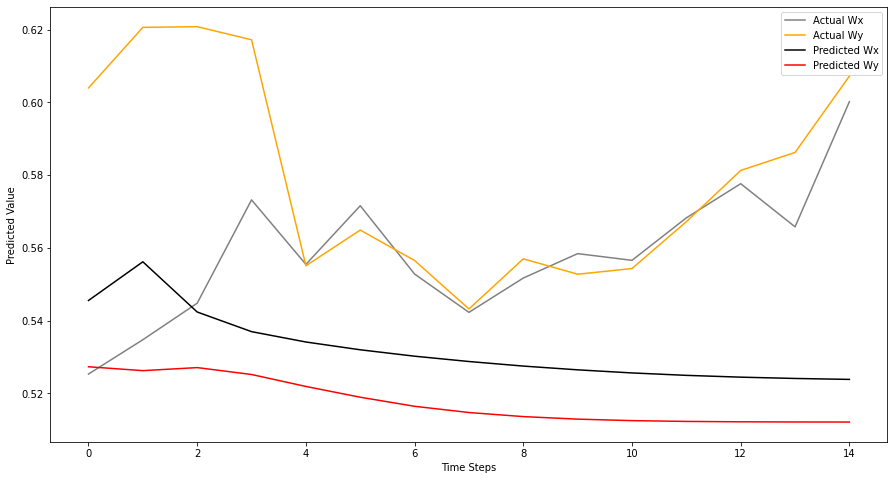

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01277, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_64.h5
138/138 - 8s - loss: 0.0287 - mean_absolute_error: 0.1258 - val_loss: 0.0128 - val_mean_absolute_error: 0.0860
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.01277
138/138 - 8s - loss: 0.0145 - mean_absolute_error: 0.0938 - val_loss: 0.0166 - val_mean_absolute_error: 0.1028
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.01277
138/138 - 8s - loss: 0.0145 - mean_absolute_error: 0.0940 - val_loss: 0.0135 - val_mean_absolute_error: 0.0890
Epoch 4/200

Epoch 00004: val_loss improved from 0.01277 to 0.01214, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_64.h5
138/138 - 8s - loss: 0.0140 - mean_absolute_error: 0.0921 - val_loss: 0.0121 - val_mean_absolute_error: 0.0847
Epoch 5/200

Epoch 00005: val_loss improved from 0.01214 to 0.01212, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_C

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01783, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0406 - mean_absolute_error: 0.1511 - val_loss: 0.0178 - val_mean_absolute_error: 0.0991
Epoch 2/200

Epoch 00002: val_loss improved from 0.01783 to 0.01288, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0161 - mean_absolute_error: 0.0992 - val_loss: 0.0129 - val_mean_absolute_error: 0.0858
Epoch 3/200

Epoch 00003: val_loss improved from 0.01288 to 0.01285, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0146 - mean_absolute_error: 0.0941 - val_loss: 0.0128 - val_mean_absolute_error: 0.0858
Epoch 4/200

Epoch 00004: val_loss improved from 0.01285 to 0.01281, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_128.h5
69/69 - 4s - loss: 0.0142 - mean_absolute_error: 0.0927 - val_loss: 0

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.02526, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0588 - mean_absolute_error: 0.1858 - val_loss: 0.0253 - val_mean_absolute_error: 0.1144
Epoch 2/200

Epoch 00002: val_loss improved from 0.02526 to 0.01908, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0235 - mean_absolute_error: 0.1190 - val_loss: 0.0191 - val_mean_absolute_error: 0.1036
Epoch 3/200

Epoch 00003: val_loss improved from 0.01908 to 0.01410, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0171 - mean_absolute_error: 0.1022 - val_loss: 0.0141 - val_mean_absolute_error: 0.0906
Epoch 4/200

Epoch 00004: val_loss improved from 0.01410 to 0.01330, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_256.h5
35/35 - 2s - loss: 0.0154 - mean_absolute_error: 0.0969 - val_loss: 0

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_cnnlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_cnnlstm.load_weights('initial.h5')
history = model_cnnlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.03077, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0843 - mean_absolute_error: 0.2290 - val_loss: 0.0308 - val_mean_absolute_error: 0.1270
Epoch 2/200

Epoch 00002: val_loss improved from 0.03077 to 0.02397, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0321 - mean_absolute_error: 0.1391 - val_loss: 0.0240 - val_mean_absolute_error: 0.1131
Epoch 3/200

Epoch 00003: val_loss improved from 0.02397 to 0.02039, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0248 - mean_absolute_error: 0.1216 - val_loss: 0.0204 - val_mean_absolute_error: 0.1033
Epoch 4/200

Epoch 00004: val_loss improved from 0.02039 to 0.01582, saving model to /content/gdrive/My Drive/DUS23L_Wxy_mm_norm_CNN_ED_LSTM__bs_512.h5
18/18 - 1s - loss: 0.0192 - mean_absolute_error: 0.1082 - val_loss: 0

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_cnnlstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_cnnlstm_mm_norm_32['batch_size'] = 32
df_cnnlstm_mm_norm_32 = df_cnnlstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_cnnlstm_mm_norm_64['batch_size'] = 64
df_cnnlstm_mm_norm_64 = df_cnnlstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_cnnlstm_mm_norm_128['batch_size'] = 128
df_cnnlstm_mm_norm_128 = df_cnnlstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_cnnlstm_mm_norm_256['batch_size'] = 256
df_cnnlstm_mm_norm_256 = df_cnnlstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_cnnlstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_cnnlstm_mm_norm_512['batch_size'] = 512
df_cnnlstm_mm_norm_512 = df_cnnlstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_cnnlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_cnnlstm_mm_norm_'))
df_cnnlstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_cnnlstm_mm_norm_results_all

epochs      loss  ...  val_mean_absolute_error  batch_size
0        0  0.021745  ...                 0.087814          32
1        1  0.014158  ...                 0.085521          32
2        2  0.012825  ...                 0.074947          32
3        3  0.011061  ...                 0.070147          32
4        4  0.010831  ...                 0.066583          32
..     ...       ...  ...                      ...         ...
26      26  0.010523  ...                 0.069215         512
27      27  0.010542  ...                 0.066594         512
28      28  0.010590  ...                 0.066470         512
29      29  0.010554  ...                 0.072404         512
30      30  0.010544  ...                 0.065878         512

[167 rows x 6 columns]

#### Figure Training MAE vs Batch Size over epochs

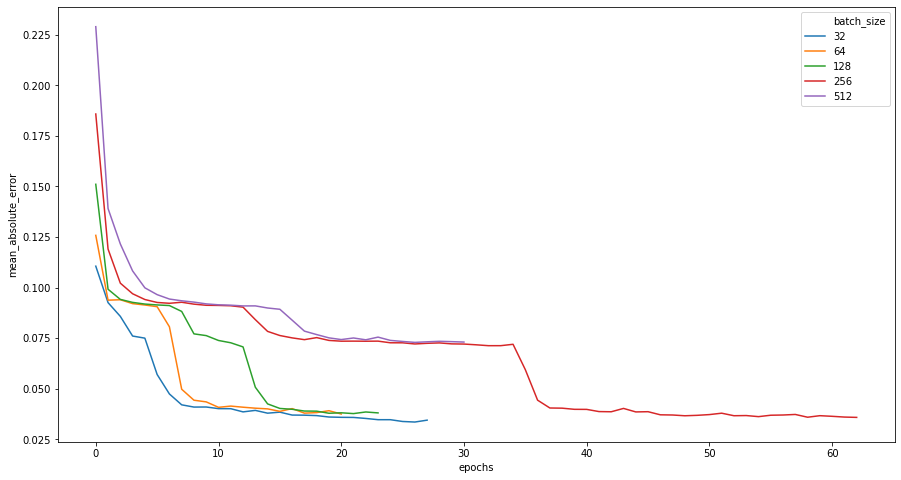

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

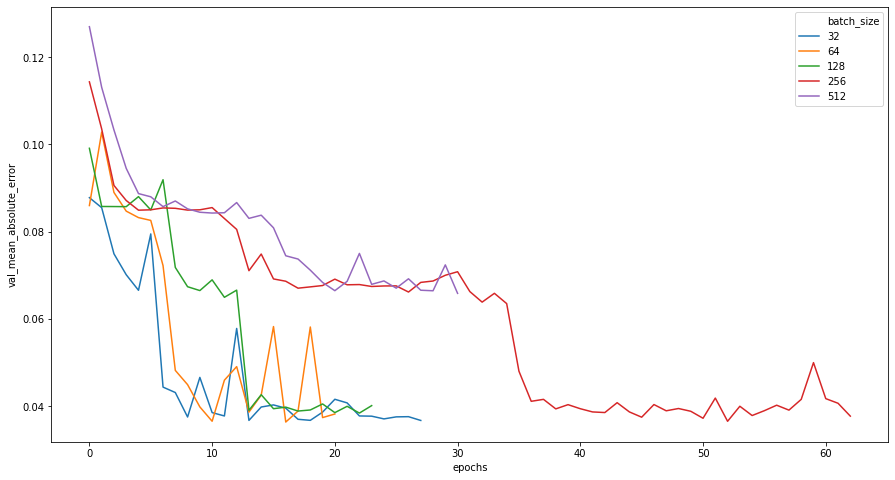

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

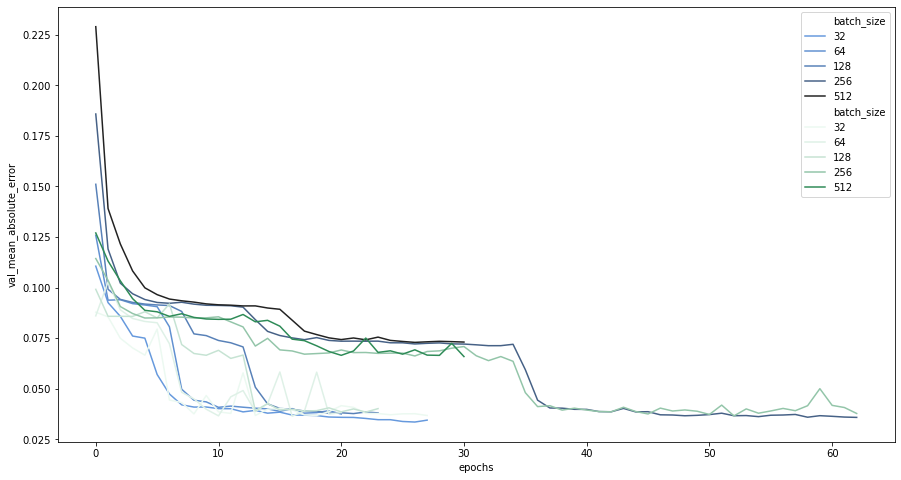

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

(1, 15, 23)


In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_cnnlstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

array([[0.26343076, 0.66429628],
       [0.27421489, 0.67551531],
       [0.2730679 , 0.68480991],
       [0.2730679 , 0.68480991],
       [0.28405817, 0.69970305],
       [0.29561449, 0.71372935],
       [0.28350213, 0.70874892],
       [0.30768786, 0.72686795],
       [0.29539937, 0.72248754],
       [0.29539937, 0.72248754],
       [0.29580268, 0.74438302],
       [0.31028114, 0.7690566 ],
       [0.30978892, 0.76485586],
       [0.32721304, 0.79569926],
       [0.33204824, 0.81550715]])

In [ ]:
y_actual[0]

array([0.26343076, 0.66429628])

In [ ]:
range(len(y_actual))

range(0, 15)

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy
0   0.263431   0.664296      0.401138      0.140027
1   0.274215   0.675515      0.360479      0.123125
2   0.273068   0.684810      0.354627      0.114037
3   0.273068   0.684810      0.351595      0.116958
4   0.284058   0.699703      0.351285      0.122289

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.263431   0.664296      0.401138      0.140027  0.137707  0.524269
1    0.274215   0.675515      0.360479      0.123125  0.086264  0.552391
2    0.273068   0.684810      0.354627      0.114037  0.081559  0.570773
3    0.273068   0.684810      0.351595      0.116958  0.078527  0.567852
4    0.284058   0.699703      0.351285      0.122289  0.067226  0.577414
5    0.295614   0.713729      0.351812      0.128676  0.056197  0.585054
6    0.283502   0.708749      0.353165      0.135784  0.069663  0.572965
7    0.307688   0.726868      0.355282      0.143077  0.047594  0.583791
8    0.295399   0.722488      0.357777      0.150545  0.062377  0.571943
9    0.295399   0.722488      0.359638      0.158246  0.064239  0.564242
10   0.295803   0.744383      0.361414      0.166087  0.065611  0.578296
11   0.310281   0.769057      0.363558      0.173671  0.053276  0.595385
12   0.309789   0.764856      0.366673      0.180854  0.056884  0.584001
13   0.327213   0.795699      0.369429      0.188094  0.042216  0.607606
14   0.332048   0.815507      0.371448      0.194601  0.039400  0.620907

In [ ]:
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.294705   0.726197      0.361955      0.149071   0.067249   0.577126
std     0.020118   0.044308      0.012624      0.026654   0.023773   0.022484
min     0.263431   0.664296      0.351285      0.114037   0.039400   0.524269
25%     0.278859   0.692256      0.353896      0.125900   0.054737   0.569312
50%     0.295399   0.722488      0.359638      0.143077   0.064239   0.577414
75%     0.308738   0.754619      0.365115      0.169879   0.074095   0.584527
max     0.332048   0.815507      0.401138      0.194601   0.137707   0.620907

In [ ]:
df_prediction = df_prediction.reset_index()

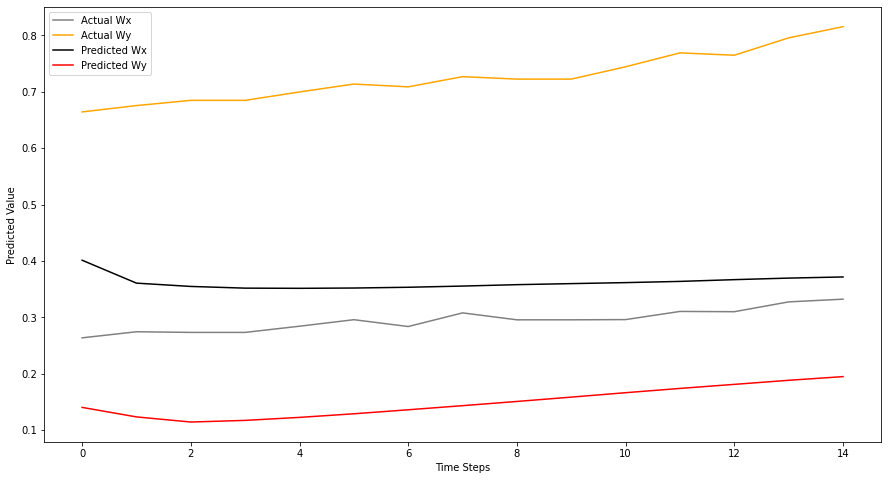

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# ConvLSTM

## Model

In [ ]:
model_save_name = Runway + "ConvLSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
n_seq=1
model_convlstm = Sequential()
model_convlstm.add(keras.layers.ConvLSTM2D(64, (1,2), activation='relu', input_shape=(n_seq, 1, n_steps_in, n_features)))
model_convlstm.add(keras.layers.Flatten())
model_convlstm.add(keras.layers.Dense(n_steps_out*number_features_predicted))
model_convlstm.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_convlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_convlstm.summary()
model_convlstm.save_weights('initial.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 14, 64)         45312     
_________________________________________________________________
flatten_3 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                26910     
_________________________________________________________________
reshape_9 (Reshape)          (None, 15, 2)             0         
Total params: 72,222
Trainable params: 72,222
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
X_train_norm_convlstm = X_train_norm.reshape(len(X_train_norm),1,1,n_steps_in,n_features)
X_test_norm_convlstm = X_test_norm.reshape(len(X_test_norm),1,1,n_steps_in,n_features)
X_val_norm_convlstm = X_val_norm.reshape(len(X_val_norm),1,1,n_steps_in,n_features)


### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_convlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_convlstm.load_weights('initial.h5')

history = model_convlstm.fit(X_train_norm_convlstm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm_convlstm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01006, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2ConvLSTM__bs_32.h5
176/176 - 2s - loss: 0.0241 - mean_absolute_error: 0.1093 - val_loss: 0.0101 - val_mean_absolute_error: 0.0712
Epoch 2/200

Epoch 00002: val_loss improved from 0.01006 to 0.00872, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2ConvLSTM__bs_32.h5
176/176 - 2s - loss: 0.0086 - mean_absolute_error: 0.0655 - val_loss: 0.0087 - val_mean_absolute_error: 0.0652
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00872
176/176 - 2s - loss: 0.0078 - mean_absolute_error: 0.0620 - val_loss: 0.0090 - val_mean_absolute_error: 0.0656
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.00872
176/176 - 2s - loss: 0.0072 - mean_absolute_error: 0.0597 - val_loss: 0.0096 - val_mean_absolute_error: 0.0669
Epoch 5/200

Epoch 00005: val_loss did not improve from 0.00872
176/176 - 2s - loss: 0.0070 - mean_absolute_error: 0.0590 - val_lo

In [ ]:
model_convlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_convlstm.evaluate(X_train_norm_convlstm, y_train_norm, batch_size=32)

176/176 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0622


[0.007960955612361431, 0.0622122548520565]

In [ ]:
 model_convlstm.evaluate(X_test_norm_convlstm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0652


[0.008719298988580704, 0.06515675783157349]

In [ ]:
model_convlstm.evaluate(X_val_norm_convlstm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 3ms/step - loss: 0.0064 - mean_absolute_error: 0.0565


[0.006351833697408438, 0.05645318329334259]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm_convlstm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 1,1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_convlstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.583458      0.510780  0.058143  0.093208
1    0.534750   0.620656      0.583927      0.511946  0.049177  0.108709
2    0.544796   0.620843      0.575833      0.504180  0.031036  0.116663
3    0.573211   0.617240      0.589210      0.524170  0.015999  0.093070
4    0.555470   0.555096      0.596895      0.532672  0.041425  0.022424
5    0.571601   0.564905      0.592227      0.534834  0.020626  0.030071
6    0.552813   0.556533      0.594325      0.527119  0.041512  0.029414
7    0.542283   0.543212      0.596678      0.524854  0.054395  0.018358
8    0.551716   0.556998      0.593211      0.518967  0.041495  0.038031
9    0.558430   0.552767      0.592907      0.515102  0.034477  0.037665
10   0.556587   0.554328      0.602307      0.503595  0.045721  0.050733
11   0.568270   0.567223      0.594572      0.511176  0.026303  0.056046
12   0.577663   0.581305      0.591888      0.498586  0.014225  0.082719
13   0.565797   0.586258      0.589076      0.489593  0.023279  0.096665
14   0.600218   0.607245      0.586562      0.495053  0.013655  0.112192

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.590872      0.513508   0.034098   0.065731
std     0.018615   0.027907      0.006507      0.013674   0.014700   0.035789
min     0.525316   0.543212      0.575833      0.489593   0.013655   0.018358
25%     0.548256   0.555814      0.587819      0.503887   0.021952   0.033868
50%     0.556587   0.567223      0.592227      0.511946   0.034477   0.056046
75%     0.569936   0.605617      0.594449      0.524512   0.043616   0.094937
max     0.600218   0.620843      0.602307      0.534834   0.058143   0.116663

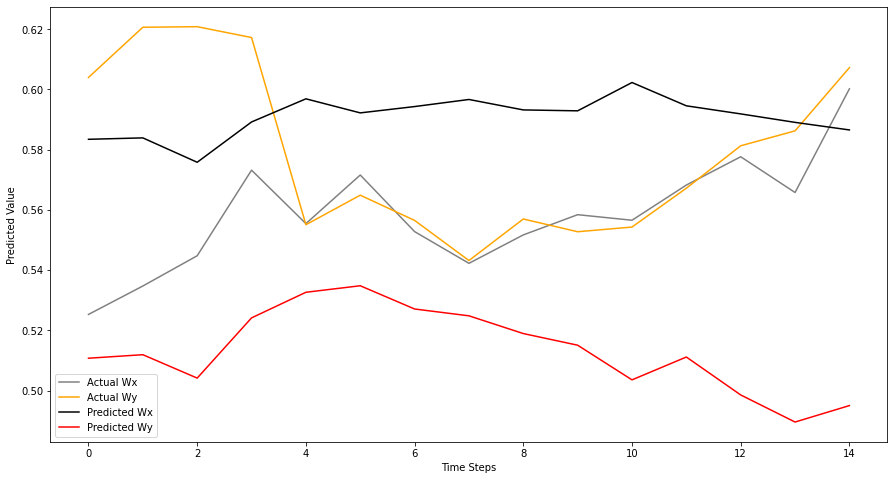

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_convlstm_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_convlstm_mm_norm_32['batch_size'] = 32
df_convlstm_mm_norm_32 = df_convlstm_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_convlstm_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_convlstm_mm_norm_64['batch_size'] = 64
df_convlstm_mm_norm_64 = df_convlstm_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_convlstm_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_convlstm_mm_norm_128['batch_size'] = 128
df_convlstm_mm_norm_128 = df_convlstm_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_convlstm_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_convlstm_mm_norm_256['batch_size'] = 256
df_convlstm_mm_norm_256 = df_convlstm_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_convlstm_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_convlstm_mm_norm_512['batch_size'] = 512
df_convlstm_mm_norm_512 = df_convlstm_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_convlstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_cnnlstm_mm_norm_'))
df_cnnlstm_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_cnnlstm_mm_norm_results_all

#### Figure Training MAE vs Batch Size over epochs

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_cnnlstm_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_cnnlstm_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23)) #15 = n steps in, 23 = number of features

In [ ]:
print(X_actual.shape)

In [ ]:
#Further Reshaping for ConvLSTM 
X_actual = X_actual.reshape(len(X_actual),1,1,15,23)

In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_convlstm.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

In [ ]:
y_actual[0]

In [ ]:
range(len(y_actual))

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

In [ ]:
df_prediction.describe()

In [ ]:
df_prediction = df_prediction.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# LSTM-AT-CNN

## Model

In [ ]:
model_save_name = Runway + "LSTM_AT_CNN_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [ ]:
n_features=X_train_norm.shape[2]

In [ ]:
model_lstmatcnn = Sequential()
model_lstmatcnn.add(LSTM(100, activation = 'relu', input_shape = (n_steps_in, n_features), return_sequences=True))
model_lstmatcnn.add(SeqSelfAttention(
					    kernel_regularizer=keras.regularizers.l2(1e-4), 
					    bias_regularizer=keras.regularizers.l1(1e-4), 
					    attention_regularizer_weight=1e-4,
					    attention_activation='sigmoid', 
					    name='Attention'))
model_lstmatcnn.add(keras.layers.Conv1D(128, 2, activation='relu'))
model_lstmatcnn.add(keras.layers.MaxPooling1D(2))
model_lstmatcnn.add(keras.layers.Dropout(0.25))
model_lstmatcnn.add(keras.layers.Activation('relu')) 
model_lstmatcnn.add(keras.layers.Conv1D(256, 2, activation='relu'))
model_lstmatcnn.add(keras.layers.MaxPooling1D(2))
model_lstmatcnn.add(keras.layers.Dropout(0.25))
model_lstmatcnn.add(keras.layers.Activation('relu')) 
model_lstmatcnn.add(keras.layers.Conv1D(512, 2, activation='relu'))
model_lstmatcnn.add(keras.layers.MaxPooling1D(2))
model_lstmatcnn.add(keras.layers.Dropout(0.25))
model_lstmatcnn.add(keras.layers.Activation('relu')) 
model_lstmatcnn.add(keras.layers.Dense(1))
model_lstmatcnn.add(keras.layers.Activation('linear')) 
model_lstmatcnn.add(keras.layers.Dense(n_steps_out*number_features_predicted))
model_lstmatcnn.add(keras.layers.Reshape([n_steps_out, number_features_predicted]))
model_lstmatcnn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_lstmatcnn.summary()
model_lstmatcnn.save_weights('initial.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 15, 100)           50000     
_________________________________________________________________
Attention (SeqSelfAttention) (None, None, 100)         6465      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, None, 128)         25728     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
activation (Activation)      (None, None, 128)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, None, 256)        

## Training

In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### Min Max Normalized Training Dataset

#### Batch Size 32

In [ ]:
batchsize=32
model_lstmatcnn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_lstmatcnn.load_weights('initial.h5')

history = model_lstmatcnn.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.11759, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2LSTM_AT_CNN__bs_32.h5
176/176 - 5s - loss: 0.1594 - mean_absolute_error: 0.3183 - val_loss: 0.1176 - val_mean_absolute_error: 0.2711
Epoch 2/200

Epoch 00002: val_loss improved from 0.11759 to 0.06158, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2LSTM_AT_CNN__bs_32.h5
176/176 - 5s - loss: 0.0512 - mean_absolute_error: 0.1632 - val_loss: 0.0616 - val_mean_absolute_error: 0.1921
Epoch 3/200

Epoch 00003: val_loss improved from 0.06158 to 0.04792, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2LSTM_AT_CNN__bs_32.h5
176/176 - 5s - loss: 0.0224 - mean_absolute_error: 0.1103 - val_loss: 0.0479 - val_mean_absolute_error: 0.1693
Epoch 4/200

Epoch 00004: val_loss improved from 0.04792 to 0.04573, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2LSTM_AT_CNN__bs_32.h5
176/176 - 5s - loss: 0.0164 - mean_absolute_error: 0.09

In [ ]:
model_lstmatcnn.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_lstmatcnn.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.0855


[0.013366537168622017, 0.08552191406488419]

In [ ]:
 model_lstmatcnn.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 6ms/step - loss: 0.0407 - mean_absolute_error: 0.1516


[0.04067065939307213, 0.15157295763492584]

In [ ]:
model_lstmatcnn.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_absolute_error: 0.0805


[0.011906769126653671, 0.08054226636886597]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,24))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_lstmatcnn.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.583542      0.463352  0.058226  0.140636
1    0.534750   0.620656      0.585053      0.462750  0.050303  0.157905
2    0.544796   0.620843      0.585136      0.460387  0.040340  0.160455
3    0.573211   0.617240      0.584927      0.460681  0.011717  0.156560
4    0.555470   0.555096      0.587925      0.459626  0.032455  0.095469
5    0.571601   0.564905      0.585734      0.459431  0.014132  0.105473
6    0.552813   0.556533      0.587603      0.460480  0.034790  0.096053
7    0.542283   0.543212      0.588476      0.461020  0.046192  0.082192
8    0.551716   0.556998      0.589342      0.460836  0.037626  0.096161
9    0.558430   0.552767      0.590091      0.460970  0.031662  0.091797
10   0.556587   0.554328      0.588307      0.461200  0.031720  0.093127
11   0.568270   0.567223      0.588540      0.461688  0.020270  0.105534
12   0.577663   0.581305      0.588892      0.462665  0.011229  0.118640
13   0.565797   0.586258      0.587099      0.463605  0.021302  0.122653
14   0.600218   0.607245      0.586488      0.464514  0.013730  0.142730

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.587144      0.461547   0.030380   0.117693
std     0.018615   0.027907      0.001912      0.001504   0.014741   0.027245
min     0.525316   0.543212      0.583542      0.459431   0.011229   0.082192
25%     0.548256   0.555814      0.585435      0.460580   0.017201   0.095761
50%     0.556587   0.567223      0.587603      0.461020   0.031720   0.105534
75%     0.569936   0.605617      0.588508      0.462708   0.038983   0.141683
max     0.600218   0.620843      0.590091      0.464514   0.058226   0.160455

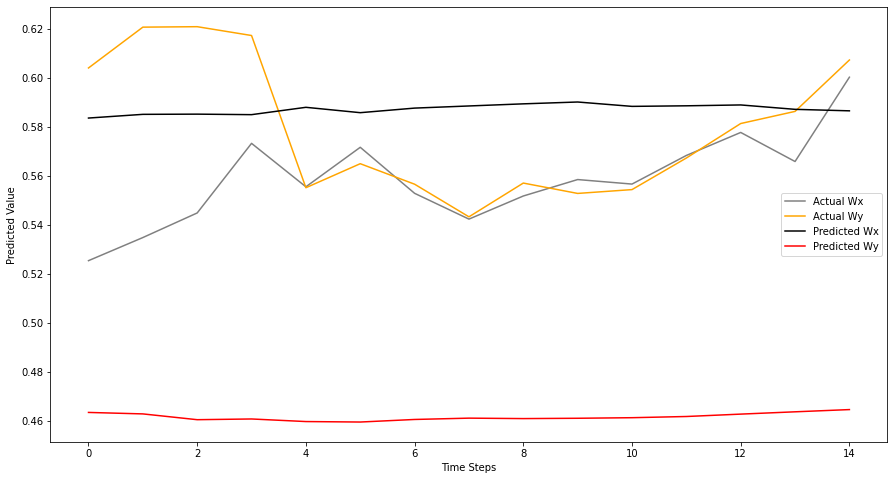

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 64

In [ ]:
batchsize=64
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es, mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_64_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_64_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 128

In [ ]:
batchsize=128
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_128_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_128_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 256

In [ ]:
batchsize=256
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_256_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_256_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

#### Batch Size 512

In [ ]:
batchsize=512
model_bdlstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bdlstm.load_weights('initial.h5')
history = model_bdlstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_512_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_512_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

## Results

### Min-Max normalized Results

#### Load Data

In [ ]:
df_lstmatcnn_mm_norm_32 = pd.read_csv(hist_csv_file_32_mm_norm)
df_lstmatcnn_mm_norm_32['batch_size'] = 32
df_lstmatcnn_mm_norm_32 = df_lstmatcnn_mm_norm_32.rename(columns={"Unnamed: 0" : "epochs"})

df_lstmatcnn_mm_norm_64 = pd.read_csv(hist_csv_file_64_mm_norm)
df_lstmatcnn_mm_norm_64['batch_size'] = 64
df_lstmatcnn_mm_norm_64 = df_lstmatcnn_mm_norm_64.rename(columns={"Unnamed: 0" : "epochs"})

df_lstmatcnn_mm_norm_128 = pd.read_csv(hist_csv_file_128_mm_norm)
df_lstmatcnn_mm_norm_128['batch_size'] = 128
df_lstmatcnn_mm_norm_128 = df_lstmatcnn_mm_norm_128.rename(columns={"Unnamed: 0" : "epochs"})

df_lstmatcnn_mm_norm_256 = pd.read_csv(hist_csv_file_256_mm_norm)
df_lstmatcnn_mm_norm_256['batch_size'] = 256
df_lstmatcnn_mm_norm_256 = df_lstmatcnn_mm_norm_256.rename(columns={"Unnamed: 0" : "epochs"})

df_lstmatcnn_mm_norm_512 = pd.read_csv(hist_csv_file_512_mm_norm)
df_lstmatcnn_mm_norm_512['batch_size'] = 512
df_lstmatcnn_mm_norm_512 = df_lstmatcnn_mm_norm_512.rename(columns={"Unnamed: 0" : "epochs"})

model_lstmatcnn.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
pdList = []
pdList.extend(value for name, value in locals().items() if name.startswith('df_lstmatcnn_mm_norm_'))
df_lstmatcnn_mm_norm_results_all = pd.concat(pdList)

In [ ]:
df_lstmatcnn_mm_norm_results_all

#### Figure Training MAE vs Batch Size over epochs

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="mean_absolute_error", data=df_lstmatcnn_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

In [ ]:
#figure training mae vs validation mae

#### Figure Validation MAE vs Batch Size over epochs

In [ ]:
palette = sns.color_palette("tab10",5)
fig, ax = plt.subplots(figsize=(15,8)) 
ax = sns.lineplot(x="epochs", y="val_mean_absolute_error", data=df_lstmatcnn_mm_norm_results_all, hue = "batch_size", legend = 'full', palette = palette)

#### Batch Size Training MAE vs Validation MAE over epochs

In [ ]:
palette1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
palette2 = sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "epochs", y="mean_absolute_error", data = df_lstmatcnn_mm_norm_results_all, hue = "batch_size", palette = palette1, legend = "full")

# Green Colors
sns.lineplot(x = "epochs", y="val_mean_absolute_error", data = df_lstmatcnn_mm_norm_results_all, hue = "batch_size", palette = palette2, legend = "full")

#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)

In [ ]:
# Position in the dataset to compare predicted and actual values
j = 0

In [ ]:
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]

In [ ]:
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,23))

In [ ]:
print(X_actual.shape)

In [ ]:
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_lstmatcnn.predict(X_actual)

In [ ]:
ypredict = ypredict.reshape((-1,2))

In [ ]:
y_wx_predict = list()
y_wy_predict = list()

for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)

In [ ]:
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)

In [ ]:
#ypredict = ypredict.flatten() 
#print(ypredict)

In [ ]:
y_actual = array(y_val_norm[j])
#print(y_actual)

In [ ]:
y_actual

In [ ]:
y_actual[0]

In [ ]:
range(len(y_actual))

In [ ]:
y_wx_actual = list()
y_wy_actual = list()

for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)

In [ ]:
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

In [ ]:
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])

In [ ]:
df_prediction.head()

In [ ]:
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

In [ ]:
df_prediction.describe()

In [ ]:
df_prediction = df_prediction.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')

# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()

In [ ]:
# direction change hit ratio (dchr)

# Univariate Baseline LSTM

## Sliding Window

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        if (sequences[i][2] == sequences[i+15][2]-60):  #60 because Original IDs add up +4 every time Check if Original ID is equal, if not, the next flight has begun and this should be separated from the flight beforehand / no false interference shall occur in the time series
            # gather input and output parts of the pattern
            seq_x = sequences[i:end_ix, :-1]    #Everythin except the last two items 
            seq_y = sequences[end_ix:out_end_ix, :-1]  #the last two items
            X.append(seq_x)
            y.append(seq_y)
        else:
            i = i+15
    return array(X), array(y)

## Approach 1: Mean Normalization (Standardization)

Feature scaling through normalization (subtracting the mean and dividing by the standard deviation of each feature). Everything calculated with the training data, because models have no access to the future mean and standard deviation values in the validation and test sets.

Also, the model shouldn't have access to future values in the training set when training. Furthermore normalization should be done using moving averages. As the real-time implementation of such a neural network is not the focus of this master thesis and this procedure will result in honest metrics, the simple train_mean and std is used for validation and test data sets as well.
https://en.wikipedia.org/wiki/Feature_scaling#Mean_normalization

In [ ]:
train_mean = train_df[['Wx','Wy']].mean()
train_std = train_df[['Wx','Wy']].std()

train_df[['Wx','Wy']] = (train_df[['Wx','Wy']] - train_mean) / train_std
test_df[['Wx','Wy']] = (test_df[['Wx','Wy']] - train_mean) / train_std
val_df[['Wx','Wy']] = (val_df[['Wx','Wy']] - train_mean) / train_std

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


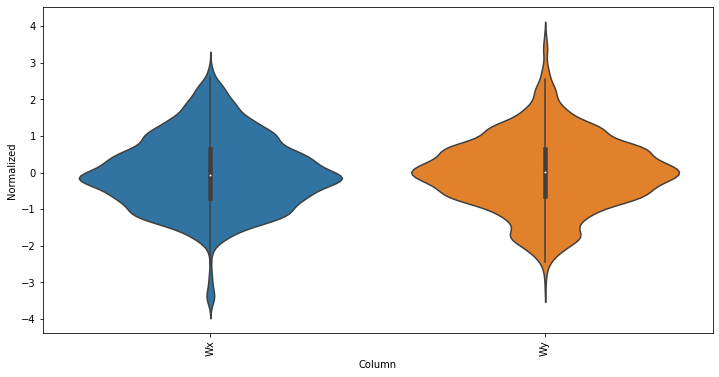

In [ ]:
# Show Distribution of Peak Values according to https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en
df_std = train_df[['Wx','Wy']]
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_mean.keys(), rotation=90)

In [ ]:
train_df.describe().transpose()

count  ...          max
Original IDs                                        6984.0  ...  9772.000000
Landing Runway ID (numerical) (numerical part o...  6984.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         6984.0  ...  2990.000000
Height Above Touchdown (HAT) (ft)                   6984.0  ...  2991.430030
Pressure Altitude (ft)                              6984.0  ...  3316.000000
Air Temperature (outside) (deg C)                   6984.0  ...     3.550524
Ground Speed (kt)                                   6984.0  ...   277.000000
Airspeed (true) (knots)                             6984.0  ...   282.921075
Airspeed (calibrated; 1 or Only) (knots)            6984.0  ...   273.500000
Mach Number                                         6984.0  ...     0.432078
Air Density (ambient) (slugs/ft³)                   6984.0  ...     0.002516
Air Density (total) (slugs/ft³)                     6984.0  ...     3.281669
Air Pressure (ambient) (lbs/ft²)                    6984.0  ...  2158.755790
Air Pressure (dynamic) (lbs/ft²)                    6984.0  ...   252.328341
Air Pressure (total) (lbs/ft²)                      6984.0  ...     2.595295
ISA Temperature (deg C)                             6984.0  ...    15.102741
Deviation from ISA Temperature (deg C)              6984.0  ...     9.647910
Speed of Sound (knots)                              6984.0  ...     3.523940
Wx                                                  6984.0  ...     2.957531
Wy                                                  6984.0  ...     3.777361
ta_rad                                              6984.0  ...     5.472823
th_rad                                              6984.0  ...     5.895469
lat_rad                                             6984.0  ...     0.723783
long_rad                                            6984.0  ...     0.045165

[24 rows x 8 columns]

In [ ]:
test_df.describe().transpose()

count  ...          max
Original IDs                                        1497.0  ...  9168.000000
Landing Runway ID (numerical) (numerical part o...  1497.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         1497.0  ...  2991.000000
Height Above Touchdown (HAT) (ft)                   1497.0  ...  2943.208084
Pressure Altitude (ft)                              1497.0  ...  3204.000000
Air Temperature (outside) (deg C)                   1497.0  ...     2.172331
Ground Speed (kt)                                   1497.0  ...   231.000000
Airspeed (true) (knots)                             1497.0  ...   235.616471
Airspeed (calibrated; 1 or Only) (knots)            1497.0  ...   227.625000
Mach Number                                         1497.0  ...     0.361044
Air Density (ambient) (slugs/ft³)                   1497.0  ...     0.002458
Air Density (total) (slugs/ft³)                     1497.0  ...     2.217905
Air Pressure (ambient) (lbs/ft²)                    1497.0  ...  2143.875912
Air Pressure (dynamic) (lbs/ft²)                    1497.0  ...   174.942331
Air Pressure (total) (lbs/ft²)                      1497.0  ...     2.137500
ISA Temperature (deg C)                             1497.0  ...    15.096802
Deviation from ISA Temperature (deg C)              1497.0  ...     8.082761
Speed of Sound (knots)                              1497.0  ...     2.166191
Wx                                                  1497.0  ...     4.036960
Wy                                                  1497.0  ...     1.560371
ta_rad                                              1497.0  ...     5.228232
th_rad                                              1497.0  ...     5.584042
lat_rad                                             1497.0  ...     0.722968
long_rad                                            1497.0  ...     0.044145

[24 rows x 8 columns]

In [ ]:
val_df.describe().transpose()

count  ...          max
Original IDs                                        1497.0  ...  9100.000000
Landing Runway ID (numerical) (numerical part o...  1497.0  ...    25.000000
Radio Altitude (1, left, Capt or Only) (ft)         1497.0  ...  2996.000000
Height Above Touchdown (HAT) (ft)                   1497.0  ...  2939.581902
Pressure Altitude (ft)                              1497.0  ...  2768.000000
Air Temperature (outside) (deg C)                   1497.0  ...     2.400578
Ground Speed (kt)                                   1497.0  ...   246.000000
Airspeed (true) (knots)                             1497.0  ...   230.492595
Airspeed (calibrated; 1 or Only) (knots)            1497.0  ...   223.250000
Mach Number                                         1497.0  ...     0.351358
Air Density (ambient) (slugs/ft³)                   1497.0  ...     0.002497
Air Density (total) (slugs/ft³)                     1497.0  ...     2.790841
Air Pressure (ambient) (lbs/ft²)                    1497.0  ...  2158.134130
Air Pressure (dynamic) (lbs/ft²)                    1497.0  ...   168.464411
Air Pressure (total) (lbs/ft²)                      1497.0  ...     2.466095
ISA Temperature (deg C)                             1497.0  ...    15.080575
Deviation from ISA Temperature (deg C)              1497.0  ...     6.895123
Speed of Sound (knots)                              1497.0  ...     2.391824
Wx                                                  1497.0  ...     2.516984
Wy                                                  1497.0  ...     2.742060
ta_rad                                              1497.0  ...     3.245296
th_rad                                              1497.0  ...     3.376161
lat_rad                                             1497.0  ...     0.723261
long_rad                                            1497.0  ...     0.043622

[24 rows x 8 columns]

## Approach 2: Min Max Normalization

In [ ]:
#Save Original IDS


In [ ]:
train_df_norm = (train_df.loc[:, df.columns != 'Original IDs']-train_df.loc[:, df.columns != 'Original IDs'].min())/(train_df.loc[:, df.columns != 'Original IDs'].max()-train_df.loc[:, df.columns != 'Original IDs'].min())
test_df_norm = (test_df.loc[:, df.columns != 'Original IDs']-train_df.loc[:, df.columns != 'Original IDs'].min())/(train_df.loc[:, df.columns != 'Original IDs'].max()-train_df.loc[:, df.columns != 'Original IDs'].min())
val_df_norm = (val_df-train_df.loc[:, df.columns != 'Original IDs'].min())/(train_df.loc[:, df.columns != 'Original IDs'].max()-train_df.loc[:, df.columns != 'Original IDs'].min())

In [ ]:
train_df_norm.head()

Landing Runway ID (numerical) (numerical part of runway designation)  ...  long_rad
0                                                NaN                     ...  0.810841
1                                                NaN                     ...  0.805326
2                                                NaN                     ...  0.798492
3                                                NaN                     ...  0.790346
4                                                NaN                     ...  0.781444

[5 rows x 23 columns]

In [ ]:
train_df_norm['Original IDs'] = train_df['Original IDs']

In [ ]:
test_df_norm['Original IDs'] = test_df['Original IDs']
val_df_norm['Original IDs'] = val_df['Original IDs']

#### Split Min Max Normalized Training Set

In [ ]:
Wx_array_train_norm=(array(train_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_train_norm=(array(train_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)

out_seq1_train_norm = array([Wx_array_train_norm[i] for i in range(len(Wx_array_train_norm))])
out_seq2_train_norm = array([Wy_array_train_norm[i] for i in range(len(Wy_array_train_norm))])

# convert to [rows, columns] structure
# Convert Train Set to [rows, columns] structur
Wx_array_train_norm=(array(train_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_train_norm=(array(train_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)
HAT_array_train_norm=(array(train_df_norm[['Height Above Touchdown (HAT) (ft)']]['Height Above Touchdown (HAT) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ra_array_train_norm=(array(train_df_norm[['Radio Altitude (1, left, Capt or Only) (ft)']]['Radio Altitude (1, left, Capt or Only) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
pa_array_train_norm=(array(train_df_norm[['Pressure Altitude (ft)']]['Pressure Altitude (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ta_array_train_norm=(array(train_df_norm[['ta_rad']]['ta_rad'].tolist()).astype(np.float)).reshape(-1, 1)
th_array_train_norm=(array(train_df_norm[['th_rad']]['th_rad'].tolist()).astype(np.float)).reshape(-1, 1)
gs_array_train_norm=(array(train_df_norm[['Ground Speed (kt)']]['Ground Speed (kt)'].tolist()).astype(np.float)).reshape(-1, 1)
asc_array_train_norm=(array(train_df_norm[['Airspeed (calibrated; 1 or Only) (knots)']]['Airspeed (calibrated; 1 or Only) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
as_array_train_norm=(array(train_df_norm[['Airspeed (true) (knots)']]['Airspeed (true) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
lat_array_train_norm=(array(train_df_norm[['lat_rad']]['lat_rad'].tolist()).astype(np.float)).reshape(-1, 1)
long_array_train_norm=(array(train_df_norm[['long_rad']]['long_rad'].tolist()).astype(np.float)).reshape(-1, 1)
at_array_train_norm=(array(train_df_norm[['Air Temperature (outside) (deg C)']]['Air Temperature (outside) (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
mn_array_train_norm=(array(train_df_norm[['Mach Number']]['Mach Number'].tolist()).astype(np.float)).reshape(-1, 1)
ada_array_train_norm=(array(train_df_norm[['Air Density (ambient) (slugs/ft³)']]['Air Density (ambient) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
adt_array_train_norm=(array(train_df_norm[['Air Density (total) (slugs/ft³)']]['Air Density (total) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
apa_array_train_norm=(array(train_df_norm[['Air Pressure (ambient) (lbs/ft²)']]['Air Pressure (ambient) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apd_array_train_norm=(array(train_df_norm[['Air Pressure (dynamic) (lbs/ft²)']]['Air Pressure (dynamic) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apt_array_train_norm=(array(train_df_norm[['Air Pressure (total) (lbs/ft²)']]['Air Pressure (total) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
it_array_train_norm=(array(train_df_norm[['ISA Temperature (deg C)']]['ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
dit_array_train_norm=(array(train_df_norm[['Deviation from ISA Temperature (deg C)']]['Deviation from ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
sos_array_train_norm=(array(train_df_norm[['Speed of Sound (knots)']]['Speed of Sound (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
id_array_train_norm=(array(train_df_norm[['Original IDs']]['Original IDs'].tolist()).astype(np.float)).reshape(-1, 1)

Wx_array_train_norm = Wx_array_train_norm.reshape((len(Wx_array_train_norm), 1))
Wy_array_train_norm = Wy_array_train_norm.reshape((len(Wy_array_train_norm), 1))
HAT_array_train_norm = HAT_array_train_norm.reshape((len(HAT_array_train_norm), 1))
ra_array_train_norm = ra_array_train_norm.reshape((len(ra_array_train_norm), 1))
pa_array_train_norm = pa_array_train_norm.reshape((len(pa_array_train_norm), 1))
ta_array_train_norm = ta_array_train_norm.reshape((len(ta_array_train_norm), 1))
th_array_train_norm = th_array_train_norm.reshape((len(th_array_train_norm), 1))
gs_array_train_norm = gs_array_train_norm.reshape((len(gs_array_train_norm), 1))
asc_array_train_norm = asc_array_train_norm.reshape((len(asc_array_train_norm), 1))
as_array_train_norm = as_array_train_norm.reshape((len(as_array_train_norm), 1))
lat_array_train_norm = lat_array_train_norm.reshape((len(lat_array_train_norm), 1))
long_array_train_norm = long_array_train_norm.reshape((len(long_array_train_norm), 1))
at_array_train_norm = at_array_train_norm.reshape((len(at_array_train_norm), 1))
mn_array_train_norm = mn_array_train_norm.reshape((len(mn_array_train_norm), 1))
ada_array_train_norm = ada_array_train_norm.reshape((len(ada_array_train_norm), 1))
adt_array_train_norm = adt_array_train_norm.reshape((len(adt_array_train_norm), 1))
apa_array_train_norm = apa_array_train_norm.reshape((len(apa_array_train_norm), 1))
apd_array_train_norm = apd_array_train_norm.reshape((len(apd_array_train_norm), 1))
apt_array_train_norm = apt_array_train_norm.reshape((len(apt_array_train_norm), 1))
it_array_train_norm = it_array_train_norm.reshape((len(it_array_train_norm), 1))
dit_array_train_norm = dit_array_train_norm.reshape((len(dit_array_train_norm), 1))
sos_array_train_norm = sos_array_train_norm.reshape((len(sos_array_train_norm), 1))
id_array_train_norm = id_array_train_norm.reshape((len(id_array_train_norm), 1))

out_seq1_train_norm = out_seq1_train_norm.reshape((len(out_seq1_train_norm), 1))
out_seq2_train_norm = out_seq2_train_norm.reshape((len(out_seq2_train_norm), 1))
# horizontally stack columns
dataset_train_norm = hstack((Wx_array_train_norm, Wy_array_train_norm, id_array_train_norm))
# choose a number of time steps
n_steps_in, n_steps_out = 15,15
# convert into input/output
X_train_norm, y_train_norm = split_sequences(dataset_train_norm, n_steps_in, n_steps_out)
print(X_train_norm.shape, y_train_norm.shape)
# summarize the data
#for i in range(len(X_train_norm)):
#print(X_train_norm[0], y_train_norm[0])

(5609, 15, 2) (5609, 15, 2)


#### Split Min Max Normalized Test Set

In [ ]:
Wx_array_test_norm=(array(test_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_test_norm=(array(test_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)

out_seq1_test_norm = array([Wx_array_test_norm[i] for i in range(len(Wx_array_test_norm))])
out_seq2_test_norm = array([Wy_array_test_norm[i] for i in range(len(Wy_array_test_norm))])
# convert to [rows, columns] structure
# Convert Test Set to [rows, columns] structur
Wx_array_test_norm=(array(test_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_test_norm=(array(test_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)
HAT_array_test_norm=(array(test_df_norm[['Height Above Touchdown (HAT) (ft)']]['Height Above Touchdown (HAT) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ra_array_test_norm=(array(test_df_norm[['Radio Altitude (1, left, Capt or Only) (ft)']]['Radio Altitude (1, left, Capt or Only) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
pa_array_test_norm=(array(test_df_norm[['Pressure Altitude (ft)']]['Pressure Altitude (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ta_array_test_norm=(array(test_df_norm[['ta_rad']]['ta_rad'].tolist()).astype(np.float)).reshape(-1, 1)
th_array_test_norm=(array(test_df_norm[['th_rad']]['th_rad'].tolist()).astype(np.float)).reshape(-1, 1)
gs_array_test_norm=(array(test_df_norm[['Ground Speed (kt)']]['Ground Speed (kt)'].tolist()).astype(np.float)).reshape(-1, 1)
asc_array_test_norm=(array(test_df_norm[['Airspeed (calibrated; 1 or Only) (knots)']]['Airspeed (calibrated; 1 or Only) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
as_array_test_norm=(array(test_df_norm[['Airspeed (true) (knots)']]['Airspeed (true) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
lat_array_test_norm=(array(test_df_norm[['lat_rad']]['lat_rad'].tolist()).astype(np.float)).reshape(-1, 1)
long_array_test_norm=(array(test_df_norm[['long_rad']]['long_rad'].tolist()).astype(np.float)).reshape(-1, 1)
at_array_test_norm=(array(test_df_norm[['Air Temperature (outside) (deg C)']]['Air Temperature (outside) (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
mn_array_test_norm=(array(test_df_norm[['Mach Number']]['Mach Number'].tolist()).astype(np.float)).reshape(-1, 1)
ada_array_test_norm=(array(test_df_norm[['Air Density (ambient) (slugs/ft³)']]['Air Density (ambient) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
adt_array_test_norm=(array(test_df_norm[['Air Density (total) (slugs/ft³)']]['Air Density (total) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
apa_array_test_norm=(array(test_df_norm[['Air Pressure (ambient) (lbs/ft²)']]['Air Pressure (ambient) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apd_array_test_norm=(array(test_df_norm[['Air Pressure (dynamic) (lbs/ft²)']]['Air Pressure (dynamic) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apt_array_test_norm=(array(test_df_norm[['Air Pressure (total) (lbs/ft²)']]['Air Pressure (total) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
it_array_test_norm=(array(test_df_norm[['ISA Temperature (deg C)']]['ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
dit_array_test_norm=(array(test_df_norm[['Deviation from ISA Temperature (deg C)']]['Deviation from ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
sos_array_test_norm=(array(test_df_norm[['Speed of Sound (knots)']]['Speed of Sound (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
id_array_test_norm=(array(test_df_norm[['Original IDs']]['Original IDs'].tolist()).astype(np.float)).reshape(-1, 1)

Wx_array_test_norm = Wx_array_test_norm.reshape((len(Wx_array_test_norm), 1))
Wy_array_test_norm = Wy_array_test_norm.reshape((len(Wy_array_test_norm), 1))
HAT_array_test_norm = HAT_array_test_norm.reshape((len(HAT_array_test_norm), 1))
ra_array_test_norm = ra_array_test_norm.reshape((len(ra_array_test_norm), 1))
pa_array_test_norm = pa_array_test_norm.reshape((len(pa_array_test_norm), 1))
ta_array_test_norm = ta_array_test_norm.reshape((len(ta_array_test_norm), 1))
th_array_test_norm = th_array_test_norm.reshape((len(th_array_test_norm), 1))
gs_array_test_norm = gs_array_test_norm.reshape((len(gs_array_test_norm), 1))
asc_array_test_norm = asc_array_test_norm.reshape((len(asc_array_test_norm), 1))
as_array_test_norm = as_array_test_norm.reshape((len(as_array_test_norm), 1))
lat_array_test_norm = lat_array_test_norm.reshape((len(lat_array_test_norm), 1))
long_array_test_norm = long_array_test_norm.reshape((len(long_array_test_norm), 1))
at_array_test_norm = at_array_test_norm.reshape((len(at_array_test_norm), 1))
mn_array_test_norm = mn_array_test_norm.reshape((len(mn_array_test_norm), 1))
ada_array_test_norm = ada_array_test_norm.reshape((len(ada_array_test_norm), 1))
adt_array_test_norm = adt_array_test_norm.reshape((len(adt_array_test_norm), 1))
apa_array_test_norm = apa_array_test_norm.reshape((len(apa_array_test_norm), 1))
apd_array_test_norm = apd_array_test_norm.reshape((len(apd_array_test_norm), 1))
apt_array_test_norm = apt_array_test_norm.reshape((len(apt_array_test_norm), 1))
it_array_test_norm = it_array_test_norm.reshape((len(it_array_test_norm), 1))
dit_array_test_norm = dit_array_test_norm.reshape((len(dit_array_test_norm), 1))
sos_array_test_norm = sos_array_test_norm.reshape((len(sos_array_test_norm), 1))
id_array_test_norm = id_array_test_norm.reshape((len(id_array_test_norm), 1))

out_seq1_test_norm = out_seq1_test_norm.reshape((len(out_seq1_test_norm), 1))
out_seq2_test_norm = out_seq2_test_norm.reshape((len(out_seq2_test_norm), 1))
# horizontally stack columns
dataset_test_norm = hstack((Wx_array_test_norm, Wy_array_test_norm, id_array_test_norm))
# choose a number of time steps
n_steps_in, n_steps_out = 15,  15
# convert into input/output
X_test_norm, y_test_norm = split_sequences(dataset_test_norm, n_steps_in, n_steps_out)
print(X_test_norm.shape, y_test_norm.shape)
# summarize the data
#for i in range(len(X_test)):
#    print(X_test[i], y_test[i])






(1213, 15, 2) (1213, 15, 2)


#### Split Min Max Normalized Validation Set

In [ ]:
Wx_array_val_norm=(array(val_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_val_norm=(array(val_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)

out_seq1_val_norm = array([Wx_array_val_norm[i] for i in range(len(Wx_array_val_norm))])
out_seq2_val_norm = array([Wy_array_val_norm[i] for i in range(len(Wy_array_val_norm))])
# convert to [rows, columns] structure
# Convert Val Set to [rows, columns] structur
Wx_array_val_norm=(array(val_df_norm[['Wx']]['Wx'].tolist()).astype(np.float)).reshape(-1, 1)
Wy_array_val_norm=(array(val_df_norm[['Wy']]['Wy'].tolist()).astype(np.float)).reshape(-1, 1)
HAT_array_val_norm=(array(val_df_norm[['Height Above Touchdown (HAT) (ft)']]['Height Above Touchdown (HAT) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ra_array_val_norm=(array(val_df_norm[['Radio Altitude (1, left, Capt or Only) (ft)']]['Radio Altitude (1, left, Capt or Only) (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
pa_array_val_norm=(array(val_df_norm[['Pressure Altitude (ft)']]['Pressure Altitude (ft)'].tolist()).astype(np.float)).reshape(-1, 1)
ta_array_val_norm=(array(val_df_norm[['ta_rad']]['ta_rad'].tolist()).astype(np.float)).reshape(-1, 1)
th_array_val_norm=(array(val_df_norm[['th_rad']]['th_rad'].tolist()).astype(np.float)).reshape(-1, 1)
gs_array_val_norm=(array(val_df_norm[['Ground Speed (kt)']]['Ground Speed (kt)'].tolist()).astype(np.float)).reshape(-1, 1)
asc_array_val_norm=(array(val_df_norm[['Airspeed (calibrated; 1 or Only) (knots)']]['Airspeed (calibrated; 1 or Only) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
as_array_val_norm=(array(val_df_norm[['Airspeed (true) (knots)']]['Airspeed (true) (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
lat_array_val_norm=(array(val_df_norm[['lat_rad']]['lat_rad'].tolist()).astype(np.float)).reshape(-1, 1)
long_array_val_norm=(array(val_df_norm[['long_rad']]['long_rad'].tolist()).astype(np.float)).reshape(-1, 1)
at_array_val_norm=(array(val_df_norm[['Air Temperature (outside) (deg C)']]['Air Temperature (outside) (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
mn_array_val_norm=(array(val_df_norm[['Mach Number']]['Mach Number'].tolist()).astype(np.float)).reshape(-1, 1)
ada_array_val_norm=(array(val_df_norm[['Air Density (ambient) (slugs/ft³)']]['Air Density (ambient) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
adt_array_val_norm=(array(val_df_norm[['Air Density (total) (slugs/ft³)']]['Air Density (total) (slugs/ft³)'].tolist()).astype(np.float)).reshape(-1, 1)
apa_array_val_norm=(array(val_df_norm[['Air Pressure (ambient) (lbs/ft²)']]['Air Pressure (ambient) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apd_array_val_norm=(array(val_df_norm[['Air Pressure (dynamic) (lbs/ft²)']]['Air Pressure (dynamic) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
apt_array_val_norm=(array(val_df_norm[['Air Pressure (total) (lbs/ft²)']]['Air Pressure (total) (lbs/ft²)'].tolist()).astype(np.float)).reshape(-1, 1)
it_array_val_norm=(array(val_df_norm[['ISA Temperature (deg C)']]['ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
dit_array_val_norm=(array(val_df_norm[['Deviation from ISA Temperature (deg C)']]['Deviation from ISA Temperature (deg C)'].tolist()).astype(np.float)).reshape(-1, 1)
sos_array_val_norm=(array(val_df_norm[['Speed of Sound (knots)']]['Speed of Sound (knots)'].tolist()).astype(np.float)).reshape(-1, 1)
id_array_val_norm=(array(val_df_norm[['Original IDs']]['Original IDs'].tolist()).astype(np.float)).reshape(-1, 1)

Wx_array_val_norm = Wx_array_val_norm.reshape((len(Wx_array_val_norm), 1))
Wy_array_val_norm = Wy_array_val_norm.reshape((len(Wy_array_val_norm), 1))
HAT_array_val_norm = HAT_array_val_norm.reshape((len(HAT_array_val_norm), 1))
ra_array_val_norm = ra_array_val_norm.reshape((len(ra_array_val_norm), 1))
pa_array_val_norm = pa_array_val_norm.reshape((len(pa_array_val_norm), 1))
ta_array_val_norm = ta_array_val_norm.reshape((len(ta_array_val_norm), 1))
th_array_val_norm = th_array_val_norm.reshape((len(th_array_val_norm), 1))
gs_array_val_norm = gs_array_val_norm.reshape((len(gs_array_val_norm), 1))
asc_array_val_norm = asc_array_val_norm.reshape((len(asc_array_val_norm), 1))
as_array_val_norm = as_array_val_norm.reshape((len(as_array_val_norm), 1))
lat_array_val_norm = lat_array_val_norm.reshape((len(lat_array_val_norm), 1))
long_array_val_norm = long_array_val_norm.reshape((len(long_array_val_norm), 1))
at_array_val_norm = at_array_val_norm.reshape((len(at_array_val_norm), 1))
mn_array_val_norm = mn_array_val_norm.reshape((len(mn_array_val_norm), 1))
ada_array_val_norm = ada_array_val_norm.reshape((len(ada_array_val_norm), 1))
adt_array_val_norm = adt_array_val_norm.reshape((len(adt_array_val_norm), 1))
apa_array_val_norm = apa_array_val_norm.reshape((len(apa_array_val_norm), 1))
apd_array_val_norm = apd_array_val_norm.reshape((len(apd_array_val_norm), 1))
apt_array_val_norm = apt_array_val_norm.reshape((len(apt_array_val_norm), 1))
it_array_val_norm = it_array_val_norm.reshape((len(it_array_val_norm), 1))
dit_array_val_norm = dit_array_val_norm.reshape((len(dit_array_val_norm), 1))
sos_array_val_norm = sos_array_val_norm.reshape((len(sos_array_val_norm), 1))
id_array_val_norm = id_array_val_norm.reshape((len(id_array_val_norm), 1))


out_seq1_val_norm = out_seq1_val_norm.reshape((len(out_seq1_val_norm), 1))
out_seq2_val_norm = out_seq2_val_norm.reshape((len(out_seq2_val_norm), 1))
# horizontally stack columns
dataset_val_norm = hstack((Wx_array_val_norm, Wy_array_val_norm, id_array_val_norm))
# choose a number of time steps
n_steps_in, n_steps_out = 15, 15
# convert into input/output
X_val_norm, y_val_norm = split_sequences(dataset_val_norm, n_steps_in, n_steps_out)
print(X_val_norm.shape, y_val_norm.shape)
# summarize the data
#for i in range(len(X_val)):
#    print(X_val[i], y_val[i])







(1168, 15, 2) (1168, 15, 2)


In [ ]:
train_df_norm.describe().transpose()

count  ...     max
Landing Runway ID (numerical) (numerical part o...     0.0  ...     NaN
Radio Altitude (1, left, Capt or Only) (ft)         6984.0  ...     1.0
Height Above Touchdown (HAT) (ft)                   6984.0  ...     1.0
Pressure Altitude (ft)                              6984.0  ...     1.0
Air Temperature (outside) (deg C)                   6984.0  ...     1.0
Ground Speed (kt)                                   6984.0  ...     1.0
Airspeed (true) (knots)                             6984.0  ...     1.0
Airspeed (calibrated; 1 or Only) (knots)            6984.0  ...     1.0
Mach Number                                         6984.0  ...     1.0
Air Density (ambient) (slugs/ft³)                   6984.0  ...     1.0
Air Density (total) (slugs/ft³)                     6984.0  ...     1.0
Air Pressure (ambient) (lbs/ft²)                    6984.0  ...     1.0
Air Pressure (dynamic) (lbs/ft²)                    6984.0  ...     1.0
Air Pressure (total) (lbs/ft²)                      6984.0  ...     1.0
ISA Temperature (deg C)                             6984.0  ...     1.0
Deviation from ISA Temperature (deg C)              6984.0  ...     1.0
Speed of Sound (knots)                              6984.0  ...     1.0
Wx                                                  6984.0  ...     1.0
Wy                                                  6984.0  ...     1.0
ta_rad                                              6984.0  ...     1.0
th_rad                                              6984.0  ...     1.0
lat_rad                                             6984.0  ...     1.0
long_rad                                            6984.0  ...     1.0
Original IDs                                        6984.0  ...  9772.0

[24 rows x 8 columns]

## Model

In [ ]:
model_save_name = Runway + "BL_LSTM_"
Filters = "_Filters_128-512_"
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [ ]:
n_features=X_train_norm.shape[2]
print(n_features)

2


In [ ]:
model_bllstm = Sequential()
model_bllstm.add(keras.layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model_bllstm.add(keras.layers.Dense(n_steps_out*number_features_predicted))
model_bllstm.add(keras.layers.Reshape([n_steps_out,2]))
model_bllstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
model_bllstm.summary()
model_bllstm.save_weights('initial.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_15 (Dense)             (None, 30)                3030      
_________________________________________________________________
reshape_11 (Reshape)         (None, 15, 2)             0         
Total params: 44,230
Trainable params: 44,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Batchsize 1 doesnt fit
optimizer = keras.optimizers.Adam(lr=0.01)

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

## Batch Size 32

In [ ]:
batchsize=32
model_bllstm.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]) #Configures the model for training.
mc = ModelCheckpoint(path + '_bs_' + str(batchsize) +'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# fit model
model_bllstm.load_weights('initial.h5')

history = model_bllstm.fit(X_train_norm, y_train_norm, batch_size=batchsize, validation_data=(X_test_norm, y_test_norm), epochs=200, verbose=2, callbacks=[es,mc])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.01677, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2BL_LSTM__bs_32.h5
176/176 - 5s - loss: 0.0364 - mean_absolute_error: 0.1263 - val_loss: 0.0168 - val_mean_absolute_error: 0.0947
Epoch 2/200

Epoch 00002: val_loss improved from 0.01677 to 0.01392, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2BL_LSTM__bs_32.h5
176/176 - 4s - loss: 0.0091 - mean_absolute_error: 0.0679 - val_loss: 0.0139 - val_mean_absolute_error: 0.0852
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.01392
176/176 - 4s - loss: 0.0089 - mean_absolute_error: 0.0663 - val_loss: 0.0152 - val_mean_absolute_error: 0.0892
Epoch 4/200

Epoch 00004: val_loss improved from 0.01392 to 0.01080, saving model to /content/gdrive/My Drive/BCN25R_Wxy_mm_norm_pp2BL_LSTM__bs_32.h5
176/176 - 4s - loss: 0.0086 - mean_absolute_error: 0.0647 - val_loss: 0.0108 - val_mean_absolute_error: 0.0734
Epoch 5/200

Epoch 00005: val_loss improved fr

In [ ]:
model_bllstm.load_weights(path + '_bs_' + '32' +'.h5')

In [ ]:
 model_bllstm.evaluate(X_train_norm, y_train_norm, batch_size=32)

176/176 [==============================] - 1s 3ms/step - loss: 0.0083 - mean_absolute_error: 0.0635


[0.008277732878923416, 0.06349600106477737]

In [ ]:
 model_bllstm.evaluate(X_test_norm, y_test_norm, batch_size=32)

38/38 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0670


[0.008914832957088947, 0.06701196730136871]

In [ ]:
model_bllstm.evaluate(X_val_norm, y_val_norm, batch_size=32)

37/37 [==============================] - 0s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0586


[0.006562625523656607, 0.05855661258101463]

In [ ]:
 
#### Validation Data: Figure Prediction vs Actual Values over n_steps_out (feed n_steps_in)
 
# Position in the dataset to compare predicted and actual values
j = 30
 
#X Actual = Values which are feeded into the Network to predict y
X_actual = X_val_norm[j]
 
#Reshape X_actual to 3D to feed the network afterwards
X_actual = X_actual.reshape((-1, 15,2))
 
 
# Feed the network and get the prediction as the output (ypredict)
ypredict = model_bllstm.predict(X_actual)
 
ypredict = ypredict.reshape((-1,2))
 
y_wx_predict = list()
y_wy_predict = list()
 
for i in range(len(ypredict)):
  y_wx_predict_temp = ypredict[i][0]
  y_wy_predict_temp = ypredict[i][1]
  y_wx_predict.append(y_wx_predict_temp)
  y_wy_predict.append(y_wy_predict_temp)
 
y_wx_predict = array(y_wx_predict)
y_wy_predict = array(y_wy_predict)
 
#ypredict = ypredict.flatten() 
#print(ypredict)
 
y_actual = array(y_val_norm[j])
#print(y_actual)
 
 
y_wx_actual = list()
y_wy_actual = list()
 
for i in range(len(y_actual)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)
 
# Create Dataframe of X_actual and y predict
df_prediction = pd.DataFrame({'Actual Wx': y_wx_actual, 'Actual Wy': y_wy_actual, 'Predicted Wx': y_wx_predict, 'Predicted Wy': y_wy_predict}, columns=['Actual Wx', 'Actual Wy', 'Predicted Wx', 'Predicted Wy'])
 
 
df_prediction['Error Wx'] = abs(df_prediction['Actual Wx'] - df_prediction['Predicted Wx'])
df_prediction['Error Wy'] = abs(df_prediction['Actual Wy'] - df_prediction['Predicted Wy'])
df_prediction

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy  Error Wx  Error Wy
0    0.525316   0.603988      0.561168      0.597559  0.035852  0.006429
1    0.534750   0.620656      0.572210      0.588098  0.037460  0.032558
2    0.544796   0.620843      0.585791      0.579753  0.040994  0.041090
3    0.573211   0.617240      0.586873      0.578312  0.013662  0.038928
4    0.555470   0.555096      0.583779      0.567847  0.028309  0.012751
5    0.571601   0.564905      0.593537      0.552108  0.021935  0.012797
6    0.552813   0.556533      0.588383      0.552713  0.035570  0.003820
7    0.542283   0.543212      0.596535      0.553670  0.054251  0.010458
8    0.551716   0.556998      0.601355      0.545408  0.049639  0.011589
9    0.558430   0.552767      0.588350      0.534962  0.029920  0.017805
10   0.556587   0.554328      0.594872      0.530560  0.038285  0.023768
11   0.568270   0.567223      0.582362      0.517747  0.014093  0.049475
12   0.577663   0.581305      0.578279      0.513494  0.000616  0.067811
13   0.565797   0.586258      0.577988      0.503392  0.012191  0.082866
14   0.600218   0.607245      0.581828      0.498729  0.018390  0.108515

In [ ]:
 
df_prediction.describe()

Actual Wx  Actual Wy  Predicted Wx  Predicted Wy   Error Wx   Error Wy
count  15.000000  15.000000     15.000000     15.000000  15.000000  15.000000
mean    0.558595   0.579240      0.584887      0.547624   0.028745   0.034711
std     0.018615   0.027907      0.010148      0.031005   0.015033   0.030923
min     0.525316   0.543212      0.561168      0.498729   0.000616   0.003820
25%     0.548256   0.555814      0.580054      0.524154   0.016241   0.012170
50%     0.556587   0.567223      0.585791      0.552108   0.029920   0.023768
75%     0.569936   0.605617      0.590960      0.573079   0.037873   0.045283
max     0.600218   0.620843      0.601355      0.597559   0.054251   0.108515

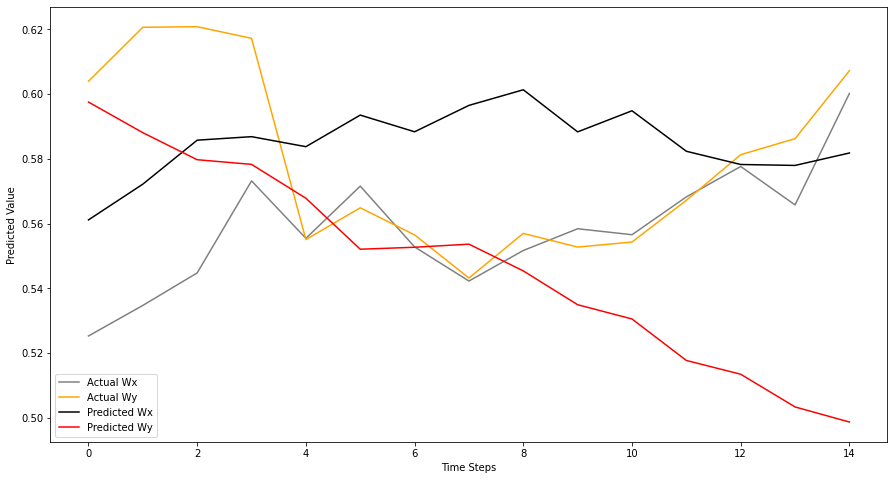

In [ ]:
 
df_prediction = df_prediction.reset_index()
 
fig, ax = plt.subplots(figsize=(15,8))
 
# Blue Colors
sns.lineplot(x = "index", y="Actual Wx", data = df_prediction,  color='grey', label = 'Actual Wx')
sns.lineplot(x = "index", y="Actual Wy", data = df_prediction,  color='orange', label = 'Actual Wy')
 
# Predicted Red Colors
sns.lineplot(x = "index", y="Predicted Wx", data = df_prediction,  color='black', label = 'Predicted Wx')
sns.lineplot(x = "index", y="Predicted Wy", data = df_prediction,  color='red', label = 'Predicted Wy')
plt.xlabel("Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
 
# direction change hit ratio (dchr)

In [ ]:
# Save Training Results  
hist_df = pd.DataFrame(history.history) 
savepath = path + 'batch_size_' + str(batchsize) + '_'
hist_csv_file_32_mm_norm = savepath + 'min_max_norm_' + str(n_steps_in) + '_steps_in ' + str(n_steps_out) + '_steps_out.csv'  
with open(hist_csv_file_32_mm_norm, mode='w') as f:
    hist_df.to_csv(f)

# ARIMA

## Model

## Rolling Forecast ARIMA Model
Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=ARIMA%20with%20Python&text=Define%20the%20model%20by%20calling,or%20times%20to%20be%20predicted.
The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

In [ ]:
series = train_df_norm[['Wx']]
test_series = test_df_norm[['Wx']]
X_train = series.values
X_test = test_series.values
train, test = X_train, X_test
history = [x for x in train]
predictions = list()

In [ ]:
train

array([[0.31910025],
       [0.30902365],
       [0.34487454],
       ...,
       [0.7448794 ],
       [0.77265824],
       [0.96562159]])

In [ ]:
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps = 15)

In [ ]:
output[0]

array([0.80610403, 0.80056714, 0.79588971, 0.79911714, 0.79882971,
       0.79932724, 0.79866504, 0.79907672, 0.79886819, 0.79907355,
       0.79896514, 0.7990756 , 0.79903363, 0.79910054, 0.79909128])

In [ ]:
for t in range(len(test)):
  model = ARIMA(history, order=(5,1,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast(steps = 15)
  yhat = output[t]
  predictions.append(yhat)
  for i in range(15):
    obs = test[i]
    history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

TypeError: ignored

In [ ]:
len(predictions)*15

15720

In [ ]:
error = sum(predictions)/len(test)
print('Test MAE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

TypeError: ignored

In [ ]:
len(X_train_norm)

6955

In [ ]:
Wx = X_train_norm[0][0][0] #ersten eintrag erhöhen für weitere werte

0.3191002467927452

In [ ]:
Wy = X_train_norm[0][0][1] #ersten eintrag nach oben ändern für weitere werte

In [ ]:
for i in range(len(X_train_norm)):
  y_wx_actual_temp = y_actual[i][0]
  y_wy_actual_temp = y_actual[i][1]
  y_wx_actual.append(y_wx_actual_temp)
  y_wy_actual.append(y_wy_actual_temp)
 
y_wx_actual = array(y_wx_actual)
y_wy_actual = array(y_wy_actual)

## Training / Grid Search

In [ ]:
model_fit = model_arima.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.Wx   No. Observations:                 9977
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  65.827
Method:                       css-mle   S.D. of innovations              0.240
Date:                Thu, 08 Oct 2020   AIC                           -117.654
Time:                        10:26:29   BIC                            -67.197
Sample:                             1   HQIC                          -100.573
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.108      0.914      -0.004       0.005
ar.L1.D.Wx    -0.1681      0.010    -16.797      0.000      -0.188      -0.148
ar.L2.D.Wx     0.0182      0.010      1.793      0.0

## Results

In [ ]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())